## Multiple case comparison

## Packages

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import matplotlib.dates as mdates
import pickle
import seaborn as sns

import nygrid.run_nygrid as ng_run
import nygrid.nygrid as ng_grid
import nygrid.postprocessing as ng_post

In [2]:
# Set up directories
cwd = os.getcwd()
if 'examples' in cwd:
    parent_dir = os.path.dirname(cwd)
    data_dir = os.path.join(parent_dir, 'data')
else:
    data_dir = os.path.join(cwd, 'data')

fig_dir = os.path.join(os.path.dirname(data_dir), 'figures')
print('Figure directory: {}'.format(fig_dir))

results_dir = os.path.join(os.path.dirname(data_dir), 'results')
print('Results directory: {}'.format(results_dir))

Figure directory: /mnt/Bo_HDD/NYgrid-python/figures
Results directory: /mnt/Bo_HDD/NYgrid-python/results


## Read grid data

In [3]:
# Cost modifiers
ext_cost_factor = 0.0
# fo_cost_factor = 1.0
fo_cost_factor = 0.5

# Simulation time settings
valid_days = 14
lookahead_days = 2

valid_hours = 24 * valid_days
lookahead_hours = 24 * lookahead_days

sim_start_time = datetime(2018, 1, 1, 0, 0, 0)
sim_end_time = datetime(2018, 12, 31, 23, 0, 0)
timestamp_list = pd.date_range(
    sim_start_time, sim_end_time, freq=f'{valid_days}D')

In [4]:
gen_fuel_rename = {
    'NU_UR': 'Nuclear',
    'CC_NG': 'Combined Cycle (NG)',
    'ST_BIT': 'Steam Turbine (BIT)', 
    'ST_FO6': 'Steam Turbine (FO6)',
    'ST_NG': 'Steam Turbine (NG)',
    'CT_FO2': 'Combustion Turbine (FO2)',
    'CT_KER': 'Combustion Turbine (KER)',
    'CT_NG': 'Combustion Turbine (NG)',
    'Other_Other': 'Other',
    'Import_Import': 'Import (or Export)',
    'DCLine_F': 'DC Line (From)',
    'DCLine_T': 'DC Line (To)',
    'HY_WAT': 'Hydro',
    'PSH': 'Pumped Hydro Storage',
    'PV_SUN': 'Utility-scale PV',
    'LBW': 'Land-based Wind',
    'OSW': 'Offshore Wind',
    'BES': 'Battery Storage',
}

# Pumped hydro storage units
phs_names = [
    'Gilboa 1 (IIFO - 1/1/2019)', 'Gilboa 2', 
    'Gilboa 3', 'Gilboa 4', 'Lewiston PS'
]

# Offshore wind units
osw_names = [
    'Attentive Energy', 'Beacon Wind', 
    'Community Offshore Wind', 'Empire Offshore Wind',
    'Mid-Atlantic Offshore Wind', 'Sunrise Wind'
]

zone_order = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K',
              'NE', 'PJM', 'IESO', 'HQ']

## Read OPF results

### A. 2018NewParams

In [5]:
sim_name_2018NewParams = f'2018NewParams_ext{ext_cost_factor}_fo{fo_cost_factor}_daily'

grid_data_dir = os.path.join(data_dir, 'grid', '2018NewParams')
assert os.path.exists(
    grid_data_dir), f'Grid data directory not found: {grid_data_dir}'

sim_results_dir = os.path.join(results_dir, sim_name_2018NewParams)
assert os.path.exists(
    sim_results_dir), f'Results directory not found: {sim_results_dir}'

# Read load and generation profiles
grid_prop_2018NewParams = ng_run.read_grid_prop(grid_data_dir)
display(grid_prop_2018NewParams.keys())

grid_profile_2018NewParams = ng_run.read_grid_profile(grid_data_dir, year=2018)
display(grid_profile_2018NewParams.keys())

# Generator fuel types
display(grid_prop_2018NewParams['gen_fuel']['GEN_FUEL'].unique())

# Create NYGrid object
start_datetime_0 = timestamp_list[0]
end_datetime_0 = start_datetime_0 + timedelta(hours=23)
nygrid_sim_2018NewParams = ng_grid.NYGrid(grid_prop=grid_prop_2018NewParams,
                            start_datetime=start_datetime_0,
                            end_datetime=end_datetime_0,
                            verbose=False)
print(f"Number of generators: {nygrid_sim_2018NewParams.NG}")
print(f"Number of HVDC lines: {nygrid_sim_2018NewParams.NDCL}")
print(f"Number of VRE generators: {nygrid_sim_2018NewParams.NVRE}")
print(f"Number of ESR units: {nygrid_sim_2018NewParams.NESR}")
print(f"Number of buses and branches: {nygrid_sim_2018NewParams.NB} and {nygrid_sim_2018NewParams.NBR}")
print(f"Number of loads: {nygrid_sim_2018NewParams.NL}")
print(f"Number of time periods: {nygrid_sim_2018NewParams.NT}")

dict_keys(['bus_prop', 'gen_prop', 'gen_fuel', 'gencost_prop', 'branch_prop', 'if_lim_prop', 'if_map_prop', 'esr_prop', 'dcline_prop'])

dict_keys(['load_profile', 'genmax_profile', 'genmin_profile', 'gencost0_profile', 'gencost1_profile', 'gencost_startup_profile'])

array(['ST_NG', 'CT_NG', 'CC_NG', 'CT_FO2', 'CT_KER', 'ST_FO6', 'ST_BIT',
       'NU_UR', 'HY_WAT', 'Import_Import', 'WT_WND', 'PV_SUN',
       'Other_Other'], dtype=object)

Number of generators: 323
Number of HVDC lines: 5
Number of VRE generators: 0
Number of ESR units: 5
Number of buses and branches: 57 and 97
Number of loads: 57
Number of time periods: 24


In [6]:
# Loop through all days
results_list_2018NewParams = []

for d in range(len(timestamp_list)):

    # Set clycle start and end datetime
    cycle_start_time = timestamp_list[d]

    # Read results
    filename = f'nygrid_sim_{sim_name_2018NewParams}_{cycle_start_time.strftime("%Y%m%d")}_{valid_days}_{lookahead_days}.pkl'
    with open(os.path.join(sim_results_dir, filename), 'rb') as f:
        results = pickle.load(f)

    results_list_2018NewParams.append(results)

In [7]:
# Power dispatch of generators by fuel type
# Including ESR, DC line, and VRE
pg_by_fuel_dict_2018NewParams = ng_post.get_pg_by_fuel_from_list(
    results_list_2018NewParams,
    nygrid_sim_2018NewParams,
    valid_hours=valid_hours)

# ESR results, including discharge and charge power, and SOC
esr_results_2018NewParams = ng_post.get_esr_results_from_list(
    results_list_2018NewParams,
    nygrid_sim_2018NewParams,
    valid_hours=valid_hours)

# LMP by bus and by zone
# lmp_results_2018NewParams = ng_post.get_lmp_results_from_list(
#     results_list_2018NewParams,
#     nygrid_sim_2018NewParams,
#     valid_hours=valid_hours)

# Branch flow and interface flow results
flow_results_2018NewParams = ng_post.get_flow_results_from_list(
    results_list_2018NewParams,
    nygrid_sim_2018NewParams,
    valid_hours=valid_hours)

# Costs
cost_results_2018NewParams = ng_post.get_cost_results_from_list(
    results_list_2018NewParams,
    nygrid_sim_2018NewParams,
    valid_hours=valid_hours)

# Slack variables and penalty costs
slack_results_2018NewParams = ng_post.get_slack_results_from_list(
    results_list_2018NewParams,
    nygrid_sim_2018NewParams,
    valid_hours=valid_hours)

In [8]:
# Separate PSH and ESR units
pg_by_fuel_dict_2018NewParams['PSH'] = pg_by_fuel_dict_2018NewParams['ESR'][phs_names].copy()

pg_by_fuel_dict_2018NewParams['BES'] = pg_by_fuel_dict_2018NewParams['ESR'].copy()
pg_by_fuel_dict_2018NewParams['BES'] = pg_by_fuel_dict_2018NewParams['BES'].drop(columns=phs_names)

# Separate LBW and OSW units
# This scenario does not have OSW units
pg_by_fuel_dict_2018NewParams['LBW'] = pg_by_fuel_dict_2018NewParams['WT_WND'].copy()
pg_by_fuel_dict_2018NewParams['OSW'] = pg_by_fuel_dict_2018NewParams['WT_WND'].copy()
pg_by_fuel_dict_2018NewParams['OSW'] = pg_by_fuel_dict_2018NewParams['OSW'].drop(
    columns=pg_by_fuel_dict_2018NewParams['LBW'].columns)

### B.0. 2030BaselineCase

In [9]:
sim_name_2030BaselineCase = f'2030BaselineCase_ext{ext_cost_factor}_fo{fo_cost_factor}_daily'

grid_data_dir_2030 = os.path.join(data_dir, 'grid', '2030BaselineCase')
assert os.path.exists(
    grid_data_dir_2030), f'Grid data directory not found: {grid_data_dir_2030}'

sim_results_dir_2030 = os.path.join(results_dir, sim_name_2030BaselineCase)
assert os.path.exists(
    sim_results_dir_2030), f'Results directory not found: {sim_results_dir_2030}'

# Read load and generation profiles
grid_prop_2030BaselineCase = ng_run.read_grid_prop(grid_data_dir_2030,
                                       if_lims_prop_file='if_lims_prop_2030BaselineCase.csv',
                                       esr_prop_file='esr_prop_2030BaselineCase.csv',
                                       dcline_prop_file='dcline_prop_2030BaselineCase.csv')
display(grid_prop_2030BaselineCase.keys())

grid_profile_2030BaselineCase = ng_run.read_grid_profile(grid_data_dir_2030, year=2030)
display(grid_profile_2030BaselineCase.keys())

# Generator fuel types
display(grid_prop_2030BaselineCase['gen_fuel']['GEN_FUEL'].unique())

# Create NYGrid object
start_datetime_0 = timestamp_list[0]
end_datetime_0 = start_datetime_0 + timedelta(hours=23)
nygrid_sim_2030BaselineCase = ng_grid.NYGrid(grid_prop=grid_prop_2030BaselineCase,
                                 start_datetime=start_datetime_0,
                                 end_datetime=end_datetime_0,
                                 verbose=False)
print(f"Number of generators: {nygrid_sim_2030BaselineCase.NG}")
print(f"Number of HVDC lines: {nygrid_sim_2030BaselineCase.NDCL}")
print(f"Number of VRE generators: {nygrid_sim_2030BaselineCase.NVRE}")
print(f"Number of ESR units: {nygrid_sim_2030BaselineCase.NESR}")
print(f"Number of buses and branches: {nygrid_sim_2030BaselineCase.NB} and {nygrid_sim_2030BaselineCase.NBR}")
print(f"Number of loads: {nygrid_sim_2030BaselineCase.NL}")
print(f"Number of time periods: {nygrid_sim_2030BaselineCase.NT}")

dict_keys(['bus_prop', 'gen_prop', 'gen_fuel', 'gencost_prop', 'branch_prop', 'if_lim_prop', 'if_map_prop', 'esr_prop', 'dcline_prop'])

dict_keys(['load_profile', 'genmax_profile', 'genmin_profile', 'gencost0_profile', 'gencost1_profile', 'gencost_startup_profile'])

array(['ST_NG', 'CT_NG', 'CC_NG', 'CT_FO2', 'ST_FO6', 'CT_KER', 'NU_UR',
       'HY_WAT', 'Import_Import', 'WT_WND', 'PV_SUN', 'Other_Other',
       'Load_Load'], dtype=object)

Number of generators: 372
Number of HVDC lines: 5
Number of VRE generators: 0
Number of ESR units: 14
Number of buses and branches: 57 and 97
Number of loads: 57
Number of time periods: 24


In [10]:
# Loop through all days
results_list_2030BaselineCase = []

for d in range(len(timestamp_list)):
    
    # Set clycle start and end datetime
    cycle_start_time = timestamp_list[d]

    # Read results
    filename = f'nygrid_sim_{sim_name_2030BaselineCase}_{cycle_start_time.strftime("%Y%m%d")}_{valid_days}_{lookahead_days}.pkl'
    with open(os.path.join(sim_results_dir_2030, filename), 'rb') as f:
        results = pickle.load(f)

    results_list_2030BaselineCase.append(results)

In [11]:
# Power dispatch of generators by fuel type
# Including ESR, DC line, and VRE
pg_by_fuel_dict_2030BaselineCase = ng_post.get_pg_by_fuel_from_list(
    results_list_2030BaselineCase,
    nygrid_sim_2030BaselineCase,
    valid_hours=valid_hours)

# ESR results, including discharge and charge power, and SOC
esr_results_2030BaselineCase = ng_post.get_esr_results_from_list(
    results_list_2030BaselineCase,
    nygrid_sim_2030BaselineCase,
    valid_hours=valid_hours)

# LMP by bus and by zone
# lmp_results_2030BaselineCase = ng_post.get_lmp_results_from_list(
#     results_list_2030BaselineCase,
#     nygrid_sim_2030BaselineCase,
#     valid_hours=valid_hours)

# Branch flow and interface flow results
flow_results_2030BaselineCase = ng_post.get_flow_results_from_list(
    results_list_2030BaselineCase,
    nygrid_sim_2030BaselineCase,
    valid_hours=valid_hours)

# Costs
cost_results_2030BaselineCase = ng_post.get_cost_results_from_list(
    results_list_2030BaselineCase,
    nygrid_sim_2030BaselineCase,
    valid_hours=valid_hours)

# Slack variables and penalty costs
slack_results_2030BaselineCase = ng_post.get_slack_results_from_list(
    results_list_2030BaselineCase,
    nygrid_sim_2030BaselineCase,
    valid_hours=valid_hours)

In [12]:
# Separate PSH and ESR units
pg_by_fuel_dict_2030BaselineCase['PSH'] = pg_by_fuel_dict_2030BaselineCase['ESR'][phs_names].copy()

pg_by_fuel_dict_2030BaselineCase['BES'] = pg_by_fuel_dict_2030BaselineCase['ESR'].copy()
pg_by_fuel_dict_2030BaselineCase['BES'] = pg_by_fuel_dict_2030BaselineCase['BES'].drop(columns=phs_names)

# Separate LBW and OSW units
# This scenario does not have OSW units
pg_by_fuel_dict_2030BaselineCase['LBW'] = pg_by_fuel_dict_2030BaselineCase['WT_WND'].copy()
pg_by_fuel_dict_2030BaselineCase['OSW'] = pg_by_fuel_dict_2030BaselineCase['WT_WND'].copy()
pg_by_fuel_dict_2030BaselineCase['OSW'] = pg_by_fuel_dict_2030BaselineCase['OSW'].drop(
    columns=pg_by_fuel_dict_2030BaselineCase['LBW'].columns)

# Add ST_BIT placeholder (All coal units have been retired)
pg_by_fuel_dict_2030BaselineCase['ST_BIT'] = pg_by_fuel_dict_2030BaselineCase['CC_NG'].drop(
    columns=pg_by_fuel_dict_2030BaselineCase['CC_NG'].columns)

### B.1. 2030BaselineCase_NoLargeLoad

In [13]:
sim_name_2030BaselineCase_NoLargeLoad = f'2030BaselineCase_NoLargeLoad_ext{ext_cost_factor}_fo{fo_cost_factor}_daily'

grid_data_dir_2030 = os.path.join(data_dir, 'grid', '2030BaselineCase_NoLargeLoad')
assert os.path.exists(
    grid_data_dir_2030), f'Grid data directory not found: {grid_data_dir_2030}'

sim_results_dir_2030 = os.path.join(results_dir, sim_name_2030BaselineCase_NoLargeLoad)
assert os.path.exists(
    sim_results_dir_2030), f'Results directory not found: {sim_results_dir_2030}'

# Read load and generation profiles
grid_prop_2030BaselineCase_NoLargeLoad = ng_run.read_grid_prop(grid_data_dir_2030,
                                       if_lims_prop_file='if_lims_prop_2030BaselineCase.csv',
                                       esr_prop_file='esr_prop_2030BaselineCase.csv',
                                       dcline_prop_file='dcline_prop_2030BaselineCase.csv')
display(grid_prop_2030BaselineCase_NoLargeLoad.keys())

grid_profile_2030BaselineCase_NoLargeLoad = ng_run.read_grid_profile(grid_data_dir_2030, year=2030)
display(grid_profile_2030BaselineCase_NoLargeLoad.keys())

# Generator fuel types
display(grid_prop_2030BaselineCase_NoLargeLoad['gen_fuel']['GEN_FUEL'].unique())

# Create NYGrid object
start_datetime_0 = timestamp_list[0]
end_datetime_0 = start_datetime_0 + timedelta(hours=23)
nygrid_sim_2030BaselineCase_NoLargeLoad = ng_grid.NYGrid(grid_prop=grid_prop_2030BaselineCase_NoLargeLoad,
                                 start_datetime=start_datetime_0,
                                 end_datetime=end_datetime_0,
                                 verbose=False)
print(f"Number of generators: {nygrid_sim_2030BaselineCase_NoLargeLoad.NG}")
print(f"Number of HVDC lines: {nygrid_sim_2030BaselineCase_NoLargeLoad.NDCL}")
print(f"Number of VRE generators: {nygrid_sim_2030BaselineCase_NoLargeLoad.NVRE}")
print(f"Number of ESR units: {nygrid_sim_2030BaselineCase_NoLargeLoad.NESR}")
print(f"Number of buses and branches: {nygrid_sim_2030BaselineCase_NoLargeLoad.NB} and {nygrid_sim_2030BaselineCase_NoLargeLoad.NBR}")
print(f"Number of loads: {nygrid_sim_2030BaselineCase_NoLargeLoad.NL}")
print(f"Number of time periods: {nygrid_sim_2030BaselineCase_NoLargeLoad.NT}")

dict_keys(['bus_prop', 'gen_prop', 'gen_fuel', 'gencost_prop', 'branch_prop', 'if_lim_prop', 'if_map_prop', 'esr_prop', 'dcline_prop'])

dict_keys(['load_profile', 'genmax_profile', 'genmin_profile', 'gencost0_profile', 'gencost1_profile', 'gencost_startup_profile'])

array(['ST_NG', 'CT_NG', 'CC_NG', 'CT_FO2', 'ST_FO6', 'CT_KER', 'NU_UR',
       'HY_WAT', 'Import_Import', 'WT_WND', 'PV_SUN', 'Other_Other'],
      dtype=object)

Number of generators: 355
Number of HVDC lines: 5
Number of VRE generators: 0
Number of ESR units: 14
Number of buses and branches: 57 and 97
Number of loads: 57
Number of time periods: 24


In [14]:
# Loop through all days
results_list_2030BaselineCase_NoLargeLoad = []

for d in range(len(timestamp_list)):
    
    # Set clycle start and end datetime
    cycle_start_time = timestamp_list[d]

    # Read results
    filename = f'nygrid_sim_{sim_name_2030BaselineCase_NoLargeLoad}_{cycle_start_time.strftime("%Y%m%d")}_{valid_days}_{lookahead_days}.pkl'
    with open(os.path.join(sim_results_dir_2030, filename), 'rb') as f:
        results = pickle.load(f)

    results_list_2030BaselineCase_NoLargeLoad.append(results)

In [15]:
# Power dispatch of generators by fuel type
# Including ESR, DC line, and VRE
pg_by_fuel_dict_2030BaselineCase_NoLargeLoad = ng_post.get_pg_by_fuel_from_list(
    results_list_2030BaselineCase_NoLargeLoad,
    nygrid_sim_2030BaselineCase_NoLargeLoad,
    valid_hours=valid_hours)

# ESR results, including discharge and charge power, and SOC
esr_results_2030BaselineCase_NoLargeLoad = ng_post.get_esr_results_from_list(
    results_list_2030BaselineCase_NoLargeLoad,
    nygrid_sim_2030BaselineCase_NoLargeLoad,
    valid_hours=valid_hours)

# LMP by bus and by zone
# lmp_results_2030BaselineCase_NoLargeLoad = ng_post.get_lmp_results_from_list(
#     results_list_2030BaselineCase_NoLargeLoad,
#     nygrid_sim_2030BaselineCase_NoLargeLoad,
#     valid_hours=valid_hours)

# Branch flow and interface flow results
flow_results_2030BaselineCase_NoLargeLoad = ng_post.get_flow_results_from_list(
    results_list_2030BaselineCase_NoLargeLoad,
    nygrid_sim_2030BaselineCase_NoLargeLoad,
    valid_hours=valid_hours)

# Costs
cost_results_2030BaselineCase_NoLargeLoad = ng_post.get_cost_results_from_list(
    results_list_2030BaselineCase_NoLargeLoad,
    nygrid_sim_2030BaselineCase_NoLargeLoad,
    valid_hours=valid_hours)

# Slack variables and penalty costs
slack_results_2030BaselineCase_NoLargeLoad = ng_post.get_slack_results_from_list(
    results_list_2030BaselineCase_NoLargeLoad,
    nygrid_sim_2030BaselineCase_NoLargeLoad,
    valid_hours=valid_hours)

In [16]:
# Separate PSH and ESR units
pg_by_fuel_dict_2030BaselineCase_NoLargeLoad['PSH'] = pg_by_fuel_dict_2030BaselineCase_NoLargeLoad['ESR'][phs_names].copy()

pg_by_fuel_dict_2030BaselineCase_NoLargeLoad['BES'] = pg_by_fuel_dict_2030BaselineCase_NoLargeLoad['ESR'].copy()
pg_by_fuel_dict_2030BaselineCase_NoLargeLoad['BES'] = pg_by_fuel_dict_2030BaselineCase_NoLargeLoad['BES'].drop(columns=phs_names)

# Separate LBW and OSW units
# This scenario does not have OSW units
pg_by_fuel_dict_2030BaselineCase_NoLargeLoad['LBW'] = pg_by_fuel_dict_2030BaselineCase_NoLargeLoad['WT_WND'].copy()
pg_by_fuel_dict_2030BaselineCase_NoLargeLoad['OSW'] = pg_by_fuel_dict_2030BaselineCase_NoLargeLoad['WT_WND'].copy()
pg_by_fuel_dict_2030BaselineCase_NoLargeLoad['OSW'] = pg_by_fuel_dict_2030BaselineCase_NoLargeLoad['OSW'].drop(
    columns=pg_by_fuel_dict_2030BaselineCase_NoLargeLoad['LBW'].columns)

# Add ST_BIT placeholder (All coal units have been retired)
pg_by_fuel_dict_2030BaselineCase_NoLargeLoad['ST_BIT'] = pg_by_fuel_dict_2030BaselineCase_NoLargeLoad['CC_NG'].drop(
    columns=pg_by_fuel_dict_2030BaselineCase_NoLargeLoad['CC_NG'].columns)

### C.0. 2030ContractCase

In [17]:
sim_name_2030ContractCase = f'2030ContractCase_ext{ext_cost_factor}_fo{fo_cost_factor}_daily'

grid_data_dir_2030 = os.path.join(data_dir, 'grid', '2030ContractCase')
assert os.path.exists(
    grid_data_dir_2030), f'Grid data directory not found: {grid_data_dir_2030}'

sim_results_dir_2030 = os.path.join(results_dir, sim_name_2030ContractCase)
assert os.path.exists(
    sim_results_dir_2030), f'Results directory not found: {sim_results_dir_2030}'

# Read load and generation profiles
grid_prop_2030ContractCase = ng_run.read_grid_prop(grid_data_dir_2030,
                                       if_lims_prop_file='if_lims_prop_2030ContractCase.csv',
                                       esr_prop_file='esr_prop_2030ContractCase.csv',
                                       dcline_prop_file='dcline_prop_2030ContractCase.csv')
display(grid_prop_2030ContractCase.keys())

grid_profile_2030ContractCase = ng_run.read_grid_profile(grid_data_dir_2030, year=2030)
display(grid_profile_2030ContractCase.keys())

# Generator fuel types
display(grid_prop_2030ContractCase['gen_fuel']['GEN_FUEL'].unique())

# Create NYGrid object
start_datetime_0 = timestamp_list[0]
end_datetime_0 = start_datetime_0 + timedelta(hours=23)
nygrid_sim_2030ContractCase = ng_grid.NYGrid(grid_prop=grid_prop_2030ContractCase,
                                 start_datetime=start_datetime_0,
                                 end_datetime=end_datetime_0,
                                 verbose=False)
print(f"Number of generators: {nygrid_sim_2030ContractCase.NG}")
print(f"Number of HVDC lines: {nygrid_sim_2030ContractCase.NDCL}")
print(f"Number of VRE generators: {nygrid_sim_2030ContractCase.NVRE}")
print(f"Number of ESR units: {nygrid_sim_2030ContractCase.NESR}")
print(
    f"Number of buses and branches: {nygrid_sim_2030ContractCase.NB} and {nygrid_sim_2030ContractCase.NBR}")
print(f"Number of loads: {nygrid_sim_2030ContractCase.NL}")
print(f"Number of time periods: {nygrid_sim_2030ContractCase.NT}")

dict_keys(['bus_prop', 'gen_prop', 'gen_fuel', 'gencost_prop', 'branch_prop', 'if_lim_prop', 'if_map_prop', 'esr_prop', 'dcline_prop'])

dict_keys(['load_profile', 'genmax_profile', 'genmin_profile', 'gencost0_profile', 'gencost1_profile', 'gencost_startup_profile'])

array(['ST_NG', 'CT_NG', 'CC_NG', 'CT_FO2', 'ST_FO6', 'CT_KER', 'NU_UR',
       'HY_WAT', 'Import_Import', 'WT_WND', 'PV_SUN', 'Other_Other',
       'Load_Load'], dtype=object)

Number of generators: 470
Number of HVDC lines: 6
Number of VRE generators: 0
Number of ESR units: 27
Number of buses and branches: 57 and 97
Number of loads: 57
Number of time periods: 24


In [18]:
# Loop through all days
results_list_2030ContractCase = []

for d in range(len(timestamp_list)):
    
    # Set clycle start and end datetime
    cycle_start_time = timestamp_list[d]

    # Read results
    filename = f'nygrid_sim_{sim_name_2030ContractCase}_{cycle_start_time.strftime("%Y%m%d")}_{valid_days}_{lookahead_days}.pkl'
    with open(os.path.join(sim_results_dir_2030, filename), 'rb') as f:
        results = pickle.load(f)

    results_list_2030ContractCase.append(results)

In [19]:
# Power dispatch of generators by fuel type
# Including ESR, DC line, and VRE
pg_by_fuel_dict_2030ContractCase = ng_post.get_pg_by_fuel_from_list(
    results_list_2030ContractCase,
    nygrid_sim_2030ContractCase,
    valid_hours=valid_hours)

# ESR results, including discharge and charge power, and SOC
esr_results_2030ContractCase = ng_post.get_esr_results_from_list(
    results_list_2030ContractCase,
    nygrid_sim_2030ContractCase,
    valid_hours=valid_hours)

# LMP by bus and by zone
# lmp_results_2030ContractCase = ng_post.get_lmp_results_from_list(
#     results_list_2030ContractCase,
#     nygrid_sim_2030ContractCase,
#     valid_hours=valid_hours)

# Branch flow and interface flow results
flow_results_2030ContractCase = ng_post.get_flow_results_from_list(
    results_list_2030ContractCase,
    nygrid_sim_2030ContractCase,
    valid_hours=valid_hours)

# Costs
cost_results_2030ContractCase = ng_post.get_cost_results_from_list(
    results_list_2030ContractCase,
    nygrid_sim_2030ContractCase,
    valid_hours=valid_hours)

# Slack variables and penalty costs
slack_results_2030ContractCase = ng_post.get_slack_results_from_list(
    results_list_2030ContractCase,
    nygrid_sim_2030ContractCase,
    valid_hours=valid_hours)

In [20]:
# Separate PSH and ESR units
pg_by_fuel_dict_2030ContractCase['PSH'] = pg_by_fuel_dict_2030ContractCase['ESR'][phs_names].copy()

pg_by_fuel_dict_2030ContractCase['BES'] = pg_by_fuel_dict_2030ContractCase['ESR'].copy()
pg_by_fuel_dict_2030ContractCase['BES'] = pg_by_fuel_dict_2030ContractCase['BES'].drop(columns=phs_names)

# Separate LBW and OSW units
pg_by_fuel_dict_2030ContractCase['LBW'] = pg_by_fuel_dict_2030ContractCase['WT_WND'].copy()
pg_by_fuel_dict_2030ContractCase['LBW'] = pg_by_fuel_dict_2030ContractCase['LBW'].drop(columns=osw_names)
pg_by_fuel_dict_2030ContractCase['OSW'] = pg_by_fuel_dict_2030ContractCase['WT_WND'].copy()
pg_by_fuel_dict_2030ContractCase['OSW'] = pg_by_fuel_dict_2030ContractCase['OSW'][osw_names]

# Add ST_BIT placeholder (All coal units have been retired)
pg_by_fuel_dict_2030ContractCase['ST_BIT'] = pg_by_fuel_dict_2030ContractCase['CC_NG'].drop(
    columns=pg_by_fuel_dict_2030ContractCase['CC_NG'].columns)


### C.1. 2030ContractCase_NoLargeLoad

In [21]:
sim_name_2030ContractCase_NoLargeLoad = f'2030ContractCase_NoLargeLoad_ext{ext_cost_factor}_fo{fo_cost_factor}_daily'

grid_data_dir_2030 = os.path.join(data_dir, 'grid', '2030ContractCase_NoLargeLoad')
assert os.path.exists(
    grid_data_dir_2030), f'Grid data directory not found: {grid_data_dir_2030}'

sim_results_dir_2030 = os.path.join(results_dir, sim_name_2030ContractCase_NoLargeLoad)
assert os.path.exists(
    sim_results_dir_2030), f'Results directory not found: {sim_results_dir_2030}'

# Read load and generation profiles
grid_prop_2030ContractCase_NoLargeLoad = ng_run.read_grid_prop(grid_data_dir_2030,
                                       if_lims_prop_file='if_lims_prop_2030ContractCase.csv',
                                       esr_prop_file='esr_prop_2030ContractCase.csv',
                                       dcline_prop_file='dcline_prop_2030ContractCase.csv')
display(grid_prop_2030ContractCase_NoLargeLoad.keys())

grid_profile_2030ContractCase_NoLargeLoad = ng_run.read_grid_profile(grid_data_dir_2030, year=2030)
display(grid_profile_2030ContractCase_NoLargeLoad.keys())

# Generator fuel types
display(grid_prop_2030ContractCase_NoLargeLoad['gen_fuel']['GEN_FUEL'].unique())

# Create NYGrid object
start_datetime_0 = timestamp_list[0]
end_datetime_0 = start_datetime_0 + timedelta(hours=23)
nygrid_sim_2030ContractCase_NoLargeLoad = ng_grid.NYGrid(grid_prop=grid_prop_2030ContractCase_NoLargeLoad,
                                 start_datetime=start_datetime_0,
                                 end_datetime=end_datetime_0,
                                 verbose=False)
print(f"Number of generators: {nygrid_sim_2030ContractCase_NoLargeLoad.NG}")
print(f"Number of HVDC lines: {nygrid_sim_2030ContractCase_NoLargeLoad.NDCL}")
print(f"Number of VRE generators: {nygrid_sim_2030ContractCase_NoLargeLoad.NVRE}")
print(f"Number of ESR units: {nygrid_sim_2030ContractCase_NoLargeLoad.NESR}")
print(
    f"Number of buses and branches: {nygrid_sim_2030ContractCase_NoLargeLoad.NB} and {nygrid_sim_2030ContractCase_NoLargeLoad.NBR}")
print(f"Number of loads: {nygrid_sim_2030ContractCase_NoLargeLoad.NL}")
print(f"Number of time periods: {nygrid_sim_2030ContractCase_NoLargeLoad.NT}")

dict_keys(['bus_prop', 'gen_prop', 'gen_fuel', 'gencost_prop', 'branch_prop', 'if_lim_prop', 'if_map_prop', 'esr_prop', 'dcline_prop'])

dict_keys(['load_profile', 'genmax_profile', 'genmin_profile', 'gencost0_profile', 'gencost1_profile', 'gencost_startup_profile'])

array(['ST_NG', 'CT_NG', 'CC_NG', 'CT_FO2', 'ST_FO6', 'CT_KER', 'NU_UR',
       'HY_WAT', 'Import_Import', 'WT_WND', 'PV_SUN', 'Other_Other'],
      dtype=object)

Number of generators: 453
Number of HVDC lines: 6
Number of VRE generators: 0
Number of ESR units: 27
Number of buses and branches: 57 and 97
Number of loads: 57
Number of time periods: 24


In [22]:
# Loop through all days
results_list_2030ContractCase_NoLargeLoad = []

for d in range(len(timestamp_list)):
    
    # Set clycle start and end datetime
    cycle_start_time = timestamp_list[d]

    # Read results
    filename = f'nygrid_sim_{sim_name_2030ContractCase_NoLargeLoad}_{cycle_start_time.strftime("%Y%m%d")}_{valid_days}_{lookahead_days}.pkl'
    with open(os.path.join(sim_results_dir_2030, filename), 'rb') as f:
        results = pickle.load(f)

    results_list_2030ContractCase_NoLargeLoad.append(results)

In [23]:
# Power dispatch of generators by fuel type
# Including ESR, DC line, and VRE
pg_by_fuel_dict_2030ContractCase_NoLargeLoad = ng_post.get_pg_by_fuel_from_list(
    results_list_2030ContractCase_NoLargeLoad,
    nygrid_sim_2030ContractCase_NoLargeLoad,
    valid_hours=valid_hours)

# ESR results, including discharge and charge power, and SOC
esr_results_2030ContractCase_NoLargeLoad = ng_post.get_esr_results_from_list(
    results_list_2030ContractCase_NoLargeLoad,
    nygrid_sim_2030ContractCase_NoLargeLoad,
    valid_hours=valid_hours)

# LMP by bus and by zone
# lmp_results_2030ContractCase_NoLargeLoad = ng_post.get_lmp_results_from_list(
#     results_list_2030ContractCase_NoLargeLoad,
#     nygrid_sim_2030ContractCase_NoLargeLoad,
#     valid_hours=valid_hours)

# Branch flow and interface flow results
flow_results_2030ContractCase_NoLargeLoad = ng_post.get_flow_results_from_list(
    results_list_2030ContractCase_NoLargeLoad,
    nygrid_sim_2030ContractCase_NoLargeLoad,
    valid_hours=valid_hours)

# Costs
cost_results_2030ContractCase_NoLargeLoad = ng_post.get_cost_results_from_list(
    results_list_2030ContractCase_NoLargeLoad,
    nygrid_sim_2030ContractCase_NoLargeLoad,
    valid_hours=valid_hours)

# Slack variables and penalty costs
slack_results_2030ContractCase_NoLargeLoad = ng_post.get_slack_results_from_list(
    results_list_2030ContractCase_NoLargeLoad,
    nygrid_sim_2030ContractCase_NoLargeLoad,
    valid_hours=valid_hours)

In [24]:
# Separate PSH and ESR units
pg_by_fuel_dict_2030ContractCase_NoLargeLoad['PSH'] = pg_by_fuel_dict_2030ContractCase_NoLargeLoad['ESR'][phs_names].copy()

pg_by_fuel_dict_2030ContractCase_NoLargeLoad['BES'] = pg_by_fuel_dict_2030ContractCase_NoLargeLoad['ESR'].copy()
pg_by_fuel_dict_2030ContractCase_NoLargeLoad['BES'] = pg_by_fuel_dict_2030ContractCase_NoLargeLoad['BES'].drop(columns=phs_names)

# Separate LBW and OSW units
pg_by_fuel_dict_2030ContractCase_NoLargeLoad['LBW'] = pg_by_fuel_dict_2030ContractCase_NoLargeLoad['WT_WND'].copy()
pg_by_fuel_dict_2030ContractCase_NoLargeLoad['LBW'] = pg_by_fuel_dict_2030ContractCase_NoLargeLoad['LBW'].drop(columns=osw_names)
pg_by_fuel_dict_2030ContractCase_NoLargeLoad['OSW'] = pg_by_fuel_dict_2030ContractCase_NoLargeLoad['WT_WND'].copy()
pg_by_fuel_dict_2030ContractCase_NoLargeLoad['OSW'] = pg_by_fuel_dict_2030ContractCase_NoLargeLoad['OSW'][osw_names]

# Add ST_BIT placeholder (All coal units have been retired)
pg_by_fuel_dict_2030ContractCase_NoLargeLoad['ST_BIT'] = pg_by_fuel_dict_2030ContractCase_NoLargeLoad['CC_NG'].drop(
    columns=pg_by_fuel_dict_2030ContractCase_NoLargeLoad['CC_NG'].columns)


### D.0. 2030StateScenario

In [25]:
sim_name_2030StateScenario = f'2030StateScenario_ext{ext_cost_factor}_fo{fo_cost_factor}_daily'

grid_data_dir_2030 = os.path.join(data_dir, 'grid', '2030StateScenario')
assert os.path.exists(
    grid_data_dir_2030), f'Grid data directory not found: {grid_data_dir_2030}'

sim_results_dir_2030 = os.path.join(results_dir, sim_name_2030StateScenario)
assert os.path.exists(
    sim_results_dir_2030), f'Results directory not found: {sim_results_dir_2030}'

# Read load and generation profiles
grid_prop_2030StateScenario = ng_run.read_grid_prop(grid_data_dir_2030,
                                       if_lims_prop_file='if_lims_prop_2030StateScenario.csv',
                                       esr_prop_file='esr_prop_2030StateScenario.csv',
                                       dcline_prop_file='dcline_prop_2030StateScenario.csv')
display(grid_prop_2030StateScenario.keys())

grid_profile_2030StateScenario = ng_run.read_grid_profile(grid_data_dir_2030, year=2030)
display(grid_profile_2030StateScenario.keys())

# Generator fuel types
display(grid_prop_2030StateScenario['gen_fuel']['GEN_FUEL'].unique())

# Create NYGrid object
start_datetime_0 = timestamp_list[0]
end_datetime_0 = start_datetime_0 + timedelta(hours=23)
nygrid_sim_2030StateScenario = ng_grid.NYGrid(grid_prop=grid_prop_2030StateScenario,
                                 start_datetime=start_datetime_0,
                                 end_datetime=end_datetime_0,
                                 verbose=False)
print(f"Number of generators: {nygrid_sim_2030StateScenario.NG}")
print(f"Number of HVDC lines: {nygrid_sim_2030StateScenario.NDCL}")
print(f"Number of VRE generators: {nygrid_sim_2030StateScenario.NVRE}")
print(f"Number of ESR units: {nygrid_sim_2030StateScenario.NESR}")
print(
    f"Number of buses and branches: {nygrid_sim_2030StateScenario.NB} and {nygrid_sim_2030StateScenario.NBR}")
print(f"Number of loads: {nygrid_sim_2030StateScenario.NL}")
print(f"Number of time periods: {nygrid_sim_2030StateScenario.NT}")

dict_keys(['bus_prop', 'gen_prop', 'gen_fuel', 'gencost_prop', 'branch_prop', 'if_lim_prop', 'if_map_prop', 'esr_prop', 'dcline_prop'])

dict_keys(['load_profile', 'genmax_profile', 'genmin_profile', 'gencost0_profile', 'gencost1_profile', 'gencost_startup_profile'])

array(['CT_NG', 'CC_NG', 'CT_FO2', 'CT_KER', 'ST_NG', 'ST_FO6', 'NU_UR',
       'HY_WAT', 'Import_Import', 'WT_WND', 'PV_SUN', 'Other_Other',
       'Load_Load'], dtype=object)

Number of generators: 471
Number of HVDC lines: 6
Number of VRE generators: 0
Number of ESR units: 40
Number of buses and branches: 57 and 97
Number of loads: 57
Number of time periods: 24


In [26]:
# Loop through all days
results_list_2030StateScenario = []

for d in range(len(timestamp_list)):
    
    # Set clycle start and end datetime
    cycle_start_time = timestamp_list[d]

    # Read results
    filename = f'nygrid_sim_{sim_name_2030StateScenario}_{cycle_start_time.strftime("%Y%m%d")}_{valid_days}_{lookahead_days}.pkl'
    with open(os.path.join(sim_results_dir_2030, filename), 'rb') as f:
        results = pickle.load(f)

    results_list_2030StateScenario.append(results)

In [27]:
# Power dispatch of generators by fuel type
# Including ESR, DC line, and VRE
pg_by_fuel_dict_2030StateScenario = ng_post.get_pg_by_fuel_from_list(
    results_list_2030StateScenario,
    nygrid_sim_2030StateScenario,
    valid_hours=valid_hours)

# ESR results, including discharge and charge power, and SOC
esr_results_2030StateScenario = ng_post.get_esr_results_from_list(
    results_list_2030StateScenario,
    nygrid_sim_2030StateScenario,
    valid_hours=valid_hours)

# LMP by bus and by zone
# lmp_results_2030StateScenario = ng_post.get_lmp_results_from_list(
#     results_list_2030StateScenario,
#     nygrid_sim_2030StateScenario,
#     valid_hours=valid_hours)

# Branch flow and interface flow results
flow_results_2030StateScenario = ng_post.get_flow_results_from_list(
    results_list_2030StateScenario,
    nygrid_sim_2030StateScenario,
    valid_hours=valid_hours)

# Costs
cost_results_2030StateScenario = ng_post.get_cost_results_from_list(
    results_list_2030StateScenario,
    nygrid_sim_2030StateScenario,
    valid_hours=valid_hours)

# Slack variables and penalty costs
slack_results_2030StateScenario = ng_post.get_slack_results_from_list(
    results_list_2030StateScenario,
    nygrid_sim_2030StateScenario,
    valid_hours=valid_hours)

In [28]:
# Separate PSH and ESR units
pg_by_fuel_dict_2030StateScenario['PSH'] = pg_by_fuel_dict_2030StateScenario['ESR'][phs_names].copy()

pg_by_fuel_dict_2030StateScenario['BES'] = pg_by_fuel_dict_2030StateScenario['ESR'].copy()
pg_by_fuel_dict_2030StateScenario['BES'] = pg_by_fuel_dict_2030StateScenario['BES'].drop(columns=phs_names)

# Separate LBW and OSW units
pg_by_fuel_dict_2030StateScenario['LBW'] = pg_by_fuel_dict_2030StateScenario['WT_WND'].copy()
pg_by_fuel_dict_2030StateScenario['LBW'] = pg_by_fuel_dict_2030StateScenario['LBW'].drop(columns=osw_names)
pg_by_fuel_dict_2030StateScenario['OSW'] = pg_by_fuel_dict_2030StateScenario['WT_WND'].copy()
pg_by_fuel_dict_2030StateScenario['OSW'] = pg_by_fuel_dict_2030StateScenario['OSW'][osw_names]

# Add ST_BIT placeholder (All coal units have been retired)
pg_by_fuel_dict_2030StateScenario['ST_BIT'] = pg_by_fuel_dict_2030StateScenario['CC_NG'].drop(
    columns=pg_by_fuel_dict_2030StateScenario['CC_NG'].columns)


### D.1. 2030StateScenario_FewerESR

In [29]:
sim_name_2030StateScenario_FewerESR = f'2030StateScenario_FewerESR_ext{ext_cost_factor}_fo{fo_cost_factor}_daily'

grid_data_dir_2030 = os.path.join(data_dir, 'grid', '2030StateScenario_FewerESR')
assert os.path.exists(
    grid_data_dir_2030), f'Grid data directory not found: {grid_data_dir_2030}'

sim_results_dir_2030 = os.path.join(results_dir, sim_name_2030StateScenario_FewerESR)
assert os.path.exists(
    sim_results_dir_2030), f'Results directory not found: {sim_results_dir_2030}'

# Read load and generation profiles
grid_prop_2030StateScenario_FewerESR = ng_run.read_grid_prop(grid_data_dir_2030,
                                       if_lims_prop_file='if_lims_prop_2030StateScenario.csv',
                                       esr_prop_file='esr_prop_2030ContractCase.csv',
                                       dcline_prop_file='dcline_prop_2030StateScenario.csv')
display(grid_prop_2030StateScenario_FewerESR.keys())

grid_profile_2030StateScenario_FewerESR = ng_run.read_grid_profile(grid_data_dir_2030, year=2030)
display(grid_profile_2030StateScenario_FewerESR.keys())

# Generator fuel types
display(grid_prop_2030StateScenario_FewerESR['gen_fuel']['GEN_FUEL'].unique())

# Create NYGrid object
start_datetime_0 = timestamp_list[0]
end_datetime_0 = start_datetime_0 + timedelta(hours=23)
nygrid_sim_2030StateScenario_FewerESR = ng_grid.NYGrid(grid_prop=grid_prop_2030StateScenario_FewerESR,
                                 start_datetime=start_datetime_0,
                                 end_datetime=end_datetime_0,
                                 verbose=False)
print(f"Number of generators: {nygrid_sim_2030StateScenario_FewerESR.NG}")
print(f"Number of HVDC lines: {nygrid_sim_2030StateScenario_FewerESR.NDCL}")
print(f"Number of VRE generators: {nygrid_sim_2030StateScenario_FewerESR.NVRE}")
print(f"Number of ESR units: {nygrid_sim_2030StateScenario_FewerESR.NESR}")
print(f"Number of buses and branches: {nygrid_sim_2030StateScenario_FewerESR.NB} and {nygrid_sim_2030StateScenario_FewerESR.NBR}")
print(f"Number of loads: {nygrid_sim_2030StateScenario_FewerESR.NL}")
print(f"Number of time periods: {nygrid_sim_2030StateScenario_FewerESR.NT}")

dict_keys(['bus_prop', 'gen_prop', 'gen_fuel', 'gencost_prop', 'branch_prop', 'if_lim_prop', 'if_map_prop', 'esr_prop', 'dcline_prop'])

dict_keys(['load_profile', 'genmax_profile', 'genmin_profile', 'gencost0_profile', 'gencost1_profile', 'gencost_startup_profile'])

array(['CT_NG', 'CC_NG', 'CT_FO2', 'CT_KER', 'ST_NG', 'ST_FO6', 'NU_UR',
       'HY_WAT', 'Import_Import', 'WT_WND', 'PV_SUN', 'Other_Other',
       'Load_Load'], dtype=object)

Number of generators: 458
Number of HVDC lines: 6
Number of VRE generators: 0
Number of ESR units: 27
Number of buses and branches: 57 and 97
Number of loads: 57
Number of time periods: 24


In [30]:
# Loop through all days
results_list_2030StateScenario_FewerESR = []

for d in range(len(timestamp_list)):
    
    # Set clycle start and end datetime
    cycle_start_time = timestamp_list[d]

    # Read results
    filename = f'nygrid_sim_{sim_name_2030StateScenario_FewerESR}_{cycle_start_time.strftime("%Y%m%d")}_{valid_days}_{lookahead_days}.pkl'
    with open(os.path.join(sim_results_dir_2030, filename), 'rb') as f:
        results = pickle.load(f)

    results_list_2030StateScenario_FewerESR.append(results)

In [31]:
# Power dispatch of generators by fuel type
# Including ESR, DC line, and VRE
pg_by_fuel_dict_2030StateScenario_FewerESR = ng_post.get_pg_by_fuel_from_list(
    results_list_2030StateScenario_FewerESR,
    nygrid_sim_2030StateScenario_FewerESR,
    valid_hours=valid_hours)

# ESR results, including discharge and charge power, and SOC
esr_results_2030StateScenario_FewerESR = ng_post.get_esr_results_from_list(
    results_list_2030StateScenario_FewerESR,
    nygrid_sim_2030StateScenario_FewerESR,
    valid_hours=valid_hours)

# LMP by bus and by zone
# lmp_results_2030StateScenario_FewerESR = ng_post.get_lmp_results_from_list(
#     results_list_2030StateScenario_FewerESR,
#     nygrid_sim_2030StateScenario_FewerESR,
#     valid_hours=valid_hours)

# Branch flow and interface flow results
flow_results_2030StateScenario_FewerESR = ng_post.get_flow_results_from_list(
    results_list_2030StateScenario_FewerESR,
    nygrid_sim_2030StateScenario_FewerESR,
    valid_hours=valid_hours)

# Costs
cost_results_2030StateScenario_FewerESR = ng_post.get_cost_results_from_list(
    results_list_2030StateScenario_FewerESR,
    nygrid_sim_2030StateScenario_FewerESR,
    valid_hours=valid_hours)

# Slack variables and penalty costs
slack_results_2030StateScenario_FewerESR = ng_post.get_slack_results_from_list(
    results_list_2030StateScenario_FewerESR,
    nygrid_sim_2030StateScenario_FewerESR,
    valid_hours=valid_hours)

In [32]:
# Separate PSH and ESR units
pg_by_fuel_dict_2030StateScenario_FewerESR['PSH'] = pg_by_fuel_dict_2030StateScenario_FewerESR['ESR'][phs_names].copy()

pg_by_fuel_dict_2030StateScenario_FewerESR['BES'] = pg_by_fuel_dict_2030StateScenario_FewerESR['ESR'].copy()
pg_by_fuel_dict_2030StateScenario_FewerESR['BES'] = pg_by_fuel_dict_2030StateScenario_FewerESR['BES'].drop(columns=phs_names)

# Separate LBW and OSW units
pg_by_fuel_dict_2030StateScenario_FewerESR['LBW'] = pg_by_fuel_dict_2030StateScenario_FewerESR['WT_WND'].copy()
pg_by_fuel_dict_2030StateScenario_FewerESR['LBW'] = pg_by_fuel_dict_2030StateScenario_FewerESR['LBW'].drop(columns=osw_names)
pg_by_fuel_dict_2030StateScenario_FewerESR['OSW'] = pg_by_fuel_dict_2030StateScenario_FewerESR['WT_WND'].copy()
pg_by_fuel_dict_2030StateScenario_FewerESR['OSW'] = pg_by_fuel_dict_2030StateScenario_FewerESR['OSW'][osw_names]

# Add ST_BIT placeholder (All coal units have been retired)
pg_by_fuel_dict_2030StateScenario_FewerESR['ST_BIT'] = pg_by_fuel_dict_2030StateScenario_FewerESR['CC_NG'].drop(
    columns=pg_by_fuel_dict_2030StateScenario_FewerESR['CC_NG'].columns)


### D.2. 2030StateScenario_NoOSW

In [33]:
sim_name_2030StateScenario_FewerOSW = f'2030StateScenario_FewerOSW_ext{ext_cost_factor}_fo{fo_cost_factor}_daily'

grid_data_dir_2030 = os.path.join(data_dir, 'grid', '2030StateScenario_FewerOSW')
assert os.path.exists(
    grid_data_dir_2030), f'Grid data directory not found: {grid_data_dir_2030}'

sim_results_dir_2030 = os.path.join(results_dir, sim_name_2030StateScenario_FewerOSW)
assert os.path.exists(
    sim_results_dir_2030), f'Results directory not found: {sim_results_dir_2030}'

# Read load and generation profiles
grid_prop_2030StateScenario_FewerOSW = ng_run.read_grid_prop(grid_data_dir_2030,
                                       if_lims_prop_file='if_lims_prop_2030StateScenario.csv',
                                       esr_prop_file='esr_prop_2030StateScenario.csv',
                                       dcline_prop_file='dcline_prop_2030StateScenario.csv')
display(grid_prop_2030StateScenario_FewerOSW.keys())

grid_profile_2030StateScenario_FewerOSW = ng_run.read_grid_profile(grid_data_dir_2030, year=2030)
display(grid_profile_2030StateScenario_FewerOSW.keys())

# Generator fuel types
display(grid_prop_2030StateScenario_FewerOSW['gen_fuel']['GEN_FUEL'].unique())

# Create NYGrid object
start_datetime_0 = timestamp_list[0]
end_datetime_0 = start_datetime_0 + timedelta(hours=23)
nygrid_sim_2030StateScenario_FewerOSW = ng_grid.NYGrid(grid_prop=grid_prop_2030StateScenario_FewerOSW,
                                 start_datetime=start_datetime_0,
                                 end_datetime=end_datetime_0,
                                 verbose=False)
print(f"Number of generators: {nygrid_sim_2030StateScenario_FewerOSW.NG}")
print(f"Number of HVDC lines: {nygrid_sim_2030StateScenario_FewerOSW.NDCL}")
print(f"Number of VRE generators: {nygrid_sim_2030StateScenario_FewerOSW.NVRE}")
print(f"Number of ESR units: {nygrid_sim_2030StateScenario_FewerOSW.NESR}")
print(
    f"Number of buses and branches: {nygrid_sim_2030StateScenario_FewerOSW.NB} and {nygrid_sim_2030StateScenario_FewerOSW.NBR}")
print(f"Number of loads: {nygrid_sim_2030StateScenario_FewerOSW.NL}")
print(f"Number of time periods: {nygrid_sim_2030StateScenario_FewerOSW.NT}")

dict_keys(['bus_prop', 'gen_prop', 'gen_fuel', 'gencost_prop', 'branch_prop', 'if_lim_prop', 'if_map_prop', 'esr_prop', 'dcline_prop'])

dict_keys(['load_profile', 'genmax_profile', 'genmin_profile', 'gencost0_profile', 'gencost1_profile', 'gencost_startup_profile'])

array(['CT_NG', 'CC_NG', 'CT_FO2', 'CT_KER', 'ST_NG', 'ST_FO6', 'NU_UR',
       'HY_WAT', 'Import_Import', 'WT_WND', 'PV_SUN', 'Other_Other',
       'Load_Load'], dtype=object)

Number of generators: 465
Number of HVDC lines: 6
Number of VRE generators: 0
Number of ESR units: 40
Number of buses and branches: 57 and 97
Number of loads: 57
Number of time periods: 24


In [34]:
# Loop through all days
results_list_2030StateScenario_FewerOSW = []

for d in range(len(timestamp_list)):
    
    # Set clycle start and end datetime
    cycle_start_time = timestamp_list[d]

    # Read results
    filename = f'nygrid_sim_{sim_name_2030StateScenario_FewerOSW}_{cycle_start_time.strftime("%Y%m%d")}_{valid_days}_{lookahead_days}.pkl'
    with open(os.path.join(sim_results_dir_2030, filename), 'rb') as f:
        results = pickle.load(f)

    results_list_2030StateScenario_FewerOSW.append(results)

In [35]:
# Power dispatch of generators by fuel type
# Including ESR, DC line, and VRE
pg_by_fuel_dict_2030StateScenario_FewerOSW = ng_post.get_pg_by_fuel_from_list(
    results_list_2030StateScenario_FewerOSW,
    nygrid_sim_2030StateScenario_FewerOSW,
    valid_hours=valid_hours)

# ESR results, including discharge and charge power, and SOC
esr_results_2030StateScenario_FewerOSW = ng_post.get_esr_results_from_list(
    results_list_2030StateScenario_FewerOSW,
    nygrid_sim_2030StateScenario_FewerOSW,
    valid_hours=valid_hours)

# LMP by bus and by zone
# lmp_results_2030StateScenario_FewerOSW = ng_post.get_lmp_results_from_list(
#     results_list_2030StateScenario_FewerOSW,
#     nygrid_sim_2030StateScenario_FewerOSW,
#     valid_hours=valid_hours)

# Branch flow and interface flow results
flow_results_2030StateScenario_FewerOSW = ng_post.get_flow_results_from_list(
    results_list_2030StateScenario_FewerOSW,
    nygrid_sim_2030StateScenario_FewerOSW,
    valid_hours=valid_hours)

# Costs
cost_results_2030StateScenario_FewerOSW = ng_post.get_cost_results_from_list(
    results_list_2030StateScenario_FewerOSW,
    nygrid_sim_2030StateScenario_FewerOSW,
    valid_hours=valid_hours)

# Slack variables and penalty costs
slack_results_2030StateScenario_FewerOSW = ng_post.get_slack_results_from_list(
    results_list_2030StateScenario_FewerOSW,
    nygrid_sim_2030StateScenario_FewerOSW,
    valid_hours=valid_hours)

In [36]:
# Separate PSH and ESR units
pg_by_fuel_dict_2030StateScenario_FewerOSW['PSH'] = pg_by_fuel_dict_2030StateScenario_FewerOSW['ESR'][phs_names].copy()

pg_by_fuel_dict_2030StateScenario_FewerOSW['BES'] = pg_by_fuel_dict_2030StateScenario_FewerOSW['ESR'].copy()
pg_by_fuel_dict_2030StateScenario_FewerOSW['BES'] = pg_by_fuel_dict_2030StateScenario_FewerOSW['BES'].drop(columns=phs_names)

# Separate LBW and OSW units
# This scenario does not have OSW units
pg_by_fuel_dict_2030StateScenario_FewerOSW['LBW'] = pg_by_fuel_dict_2030StateScenario_FewerOSW['WT_WND'].copy()
pg_by_fuel_dict_2030StateScenario_FewerOSW['OSW'] = pg_by_fuel_dict_2030StateScenario_FewerOSW['WT_WND'].copy()
pg_by_fuel_dict_2030StateScenario_FewerOSW['OSW'] = pg_by_fuel_dict_2030StateScenario_FewerOSW['OSW'].drop(
    columns=pg_by_fuel_dict_2030StateScenario_FewerOSW['LBW'].columns)

# Add ST_BIT placeholder (All coal units have been retired)
pg_by_fuel_dict_2030StateScenario_FewerOSW['ST_BIT'] = pg_by_fuel_dict_2030StateScenario_FewerOSW['CC_NG'].drop(
    columns=pg_by_fuel_dict_2030StateScenario_FewerOSW['CC_NG'].columns)


### D.3. 2030StateScenario_NoTxUpgrade

In [37]:
sim_name_2030StateScenario_NoTxUpgrade = f'2030StateScenario_NoTxUpgrade_ext{ext_cost_factor}_fo{fo_cost_factor}_daily'

grid_data_dir_2030 = os.path.join(data_dir, 'grid', '2030StateScenario_NoTxUpgrade')
assert os.path.exists(
    grid_data_dir_2030), f'Grid data directory not found: {grid_data_dir_2030}'

sim_results_dir_2030 = os.path.join(results_dir, sim_name_2030StateScenario_NoTxUpgrade)
assert os.path.exists(
    sim_results_dir_2030), f'Results directory not found: {sim_results_dir_2030}'

# Read load and generation profiles
grid_prop_2030StateScenario_NoTxUpgrade = ng_run.read_grid_prop(grid_data_dir_2030,
                                       if_lims_prop_file='if_lims_prop_2030BaselineCase.csv',
                                       esr_prop_file='esr_prop_2030StateScenario.csv',
                                       dcline_prop_file='dcline_prop_2030BaselineCase.csv')
display(grid_prop_2030StateScenario_NoTxUpgrade.keys())

grid_profile_2030StateScenario_NoTxUpgrade = ng_run.read_grid_profile(grid_data_dir_2030, year=2030)
display(grid_profile_2030StateScenario_NoTxUpgrade.keys())

# Generator fuel types
display(grid_prop_2030StateScenario_NoTxUpgrade['gen_fuel']['GEN_FUEL'].unique())

# Create NYGrid object
start_datetime_0 = timestamp_list[0]
end_datetime_0 = start_datetime_0 + timedelta(hours=23)
nygrid_sim_2030StateScenario_NoTxUpgrade = ng_grid.NYGrid(grid_prop=grid_prop_2030StateScenario_NoTxUpgrade,
                                 start_datetime=start_datetime_0,
                                 end_datetime=end_datetime_0,
                                 verbose=False)
print(f"Number of generators: {nygrid_sim_2030StateScenario_NoTxUpgrade.NG}")
print(f"Number of HVDC lines: {nygrid_sim_2030StateScenario_NoTxUpgrade.NDCL}")
print(f"Number of VRE generators: {nygrid_sim_2030StateScenario_NoTxUpgrade.NVRE}")
print(f"Number of ESR units: {nygrid_sim_2030StateScenario_NoTxUpgrade.NESR}")
print(f"Number of buses and branches: {nygrid_sim_2030StateScenario_NoTxUpgrade.NB} and {nygrid_sim_2030StateScenario_NoTxUpgrade.NBR}")
print(f"Number of loads: {nygrid_sim_2030StateScenario_NoTxUpgrade.NL}")
print(f"Number of time periods: {nygrid_sim_2030StateScenario_NoTxUpgrade.NT}")

dict_keys(['bus_prop', 'gen_prop', 'gen_fuel', 'gencost_prop', 'branch_prop', 'if_lim_prop', 'if_map_prop', 'esr_prop', 'dcline_prop'])

dict_keys(['load_profile', 'genmax_profile', 'genmin_profile', 'gencost0_profile', 'gencost1_profile', 'gencost_startup_profile'])

array(['CT_NG', 'CC_NG', 'CT_FO2', 'CT_KER', 'ST_NG', 'ST_FO6', 'NU_UR',
       'HY_WAT', 'Import_Import', 'WT_WND', 'PV_SUN', 'Other_Other',
       'Load_Load'], dtype=object)

Number of generators: 468
Number of HVDC lines: 5
Number of VRE generators: 0
Number of ESR units: 40
Number of buses and branches: 57 and 97
Number of loads: 57
Number of time periods: 24


In [38]:
# Loop through all days
results_list_2030StateScenario_NoTxUpgrade = []

for d in range(len(timestamp_list)):
    
    # Set clycle start and end datetime
    cycle_start_time = timestamp_list[d]

    # Read results
    filename = f'nygrid_sim_{sim_name_2030StateScenario_NoTxUpgrade}_{cycle_start_time.strftime("%Y%m%d")}_{valid_days}_{lookahead_days}.pkl'
    with open(os.path.join(sim_results_dir_2030, filename), 'rb') as f:
        results = pickle.load(f)

    results_list_2030StateScenario_NoTxUpgrade.append(results)

In [39]:
# Power dispatch of generators by fuel type
# Including ESR, DC line, and VRE
pg_by_fuel_dict_2030StateScenario_NoTxUpgrade = ng_post.get_pg_by_fuel_from_list(
    results_list_2030StateScenario_NoTxUpgrade,
    nygrid_sim_2030StateScenario_NoTxUpgrade,
    valid_hours=valid_hours)

# ESR results, including discharge and charge power, and SOC
esr_results_2030StateScenario_NoTxUpgrade = ng_post.get_esr_results_from_list(
    results_list_2030StateScenario_NoTxUpgrade,
    nygrid_sim_2030StateScenario_NoTxUpgrade,
    valid_hours=valid_hours)

# LMP by bus and by zone
# lmp_results_2030StateScenario_NoTxUpgrade = ng_post.get_lmp_results_from_list(
#     results_list_2030StateScenario_NoTxUpgrade,
#     nygrid_sim_2030StateScenario_NoTxUpgrade,
#     valid_hours=valid_hours)

# Branch flow and interface flow results
flow_results_2030StateScenario_NoTxUpgrade = ng_post.get_flow_results_from_list(
    results_list_2030StateScenario_NoTxUpgrade,
    nygrid_sim_2030StateScenario_NoTxUpgrade,
    valid_hours=valid_hours)

# Costs
cost_results_2030StateScenario_NoTxUpgrade = ng_post.get_cost_results_from_list(
    results_list_2030StateScenario_NoTxUpgrade,
    nygrid_sim_2030StateScenario_NoTxUpgrade,
    valid_hours=valid_hours)

# Slack variables and penalty costs
slack_results_2030StateScenario_NoTxUpgrade = ng_post.get_slack_results_from_list(
    results_list_2030StateScenario_NoTxUpgrade,
    nygrid_sim_2030StateScenario_NoTxUpgrade,
    valid_hours=valid_hours)

In [40]:
# Separate PSH and ESR units
pg_by_fuel_dict_2030StateScenario_NoTxUpgrade['PSH'] = pg_by_fuel_dict_2030StateScenario_NoTxUpgrade['ESR'][phs_names].copy()

pg_by_fuel_dict_2030StateScenario_NoTxUpgrade['BES'] = pg_by_fuel_dict_2030StateScenario_NoTxUpgrade['ESR'].copy()
pg_by_fuel_dict_2030StateScenario_NoTxUpgrade['BES'] = pg_by_fuel_dict_2030StateScenario_NoTxUpgrade['BES'].drop(columns=phs_names)

# Separate LBW and OSW units
pg_by_fuel_dict_2030StateScenario_NoTxUpgrade['LBW'] = pg_by_fuel_dict_2030StateScenario_NoTxUpgrade['WT_WND'].copy()
pg_by_fuel_dict_2030StateScenario_NoTxUpgrade['LBW'] = pg_by_fuel_dict_2030StateScenario_NoTxUpgrade['LBW'].drop(columns=osw_names)
pg_by_fuel_dict_2030StateScenario_NoTxUpgrade['OSW'] = pg_by_fuel_dict_2030StateScenario_NoTxUpgrade['WT_WND'].copy()
pg_by_fuel_dict_2030StateScenario_NoTxUpgrade['OSW'] = pg_by_fuel_dict_2030StateScenario_NoTxUpgrade['OSW'][osw_names]

# Add ST_BIT placeholder (All coal units have been retired)
pg_by_fuel_dict_2030StateScenario_NoTxUpgrade['ST_BIT'] = pg_by_fuel_dict_2030StateScenario_NoTxUpgrade['CC_NG'].drop(
    columns=pg_by_fuel_dict_2030StateScenario_NoTxUpgrade['CC_NG'].columns)


### D.4. 2030StateScenario_NoLargeLoad

In [41]:
sim_name_2030StateScenario_NoLargeLoad = f'2030StateScenario_NoLargeLoad_ext{ext_cost_factor}_fo{fo_cost_factor}_daily'

grid_data_dir_2030 = os.path.join(data_dir, 'grid', '2030StateScenario_NoLargeLoad')
assert os.path.exists(
    grid_data_dir_2030), f'Grid data directory not found: {grid_data_dir_2030}'

sim_results_dir_2030 = os.path.join(results_dir, sim_name_2030StateScenario_NoLargeLoad)
assert os.path.exists(
    sim_results_dir_2030), f'Results directory not found: {sim_results_dir_2030}'

# Read load and generation profiles
grid_prop_2030StateScenario_NoLargeLoad = ng_run.read_grid_prop(grid_data_dir_2030,
                                       if_lims_prop_file='if_lims_prop_2030StateScenario.csv',
                                       esr_prop_file='esr_prop_2030StateScenario.csv',
                                       dcline_prop_file='dcline_prop_2030StateScenario.csv')
display(grid_prop_2030StateScenario_NoLargeLoad.keys())

grid_profile_2030StateScenario_NoLargeLoad = ng_run.read_grid_profile(grid_data_dir_2030, year=2030)
display(grid_profile_2030StateScenario_NoLargeLoad.keys())

# Generator fuel types
display(grid_prop_2030StateScenario_NoLargeLoad['gen_fuel']['GEN_FUEL'].unique())

# Create NYGrid object
start_datetime_0 = timestamp_list[0]
end_datetime_0 = start_datetime_0 + timedelta(hours=23)
nygrid_sim_2030StateScenario_NoLargeLoad = ng_grid.NYGrid(grid_prop=grid_prop_2030StateScenario_NoLargeLoad,
                                 start_datetime=start_datetime_0,
                                 end_datetime=end_datetime_0,
                                 verbose=False)
print(f"Number of generators: {nygrid_sim_2030StateScenario_NoLargeLoad.NG}")
print(f"Number of HVDC lines: {nygrid_sim_2030StateScenario_NoLargeLoad.NDCL}")
print(f"Number of VRE generators: {nygrid_sim_2030StateScenario_NoLargeLoad.NVRE}")
print(f"Number of ESR units: {nygrid_sim_2030StateScenario_NoLargeLoad.NESR}")
print(
    f"Number of buses and branches: {nygrid_sim_2030StateScenario_NoLargeLoad.NB} and {nygrid_sim_2030StateScenario_NoLargeLoad.NBR}")
print(f"Number of loads: {nygrid_sim_2030StateScenario_NoLargeLoad.NL}")
print(f"Number of time periods: {nygrid_sim_2030StateScenario_NoLargeLoad.NT}")

dict_keys(['bus_prop', 'gen_prop', 'gen_fuel', 'gencost_prop', 'branch_prop', 'if_lim_prop', 'if_map_prop', 'esr_prop', 'dcline_prop'])

dict_keys(['load_profile', 'genmax_profile', 'genmin_profile', 'gencost0_profile', 'gencost1_profile', 'gencost_startup_profile'])

array(['CT_NG', 'CC_NG', 'CT_FO2', 'CT_KER', 'ST_NG', 'ST_FO6', 'NU_UR',
       'HY_WAT', 'Import_Import', 'WT_WND', 'PV_SUN', 'Other_Other'],
      dtype=object)

Number of generators: 454
Number of HVDC lines: 6
Number of VRE generators: 0
Number of ESR units: 40
Number of buses and branches: 57 and 97
Number of loads: 57
Number of time periods: 24


In [42]:
# Loop through all days
results_list_2030StateScenario_NoLargeLoad = []

for d in range(len(timestamp_list)):
    
    # Set clycle start and end datetime
    cycle_start_time = timestamp_list[d]

    # Read results
    filename = f'nygrid_sim_{sim_name_2030StateScenario_NoLargeLoad}_{cycle_start_time.strftime("%Y%m%d")}_{valid_days}_{lookahead_days}.pkl'
    with open(os.path.join(sim_results_dir_2030, filename), 'rb') as f:
        results = pickle.load(f)

    results_list_2030StateScenario_NoLargeLoad.append(results)

In [43]:
# Power dispatch of generators by fuel type
# Including ESR, DC line, and VRE
pg_by_fuel_dict_2030StateScenario_NoLargeLoad = ng_post.get_pg_by_fuel_from_list(
    results_list_2030StateScenario_NoLargeLoad,
    nygrid_sim_2030StateScenario_NoLargeLoad,
    valid_hours=valid_hours)

# ESR results, including discharge and charge power, and SOC
esr_results_2030StateScenario_NoLargeLoad = ng_post.get_esr_results_from_list(
    results_list_2030StateScenario_NoLargeLoad,
    nygrid_sim_2030StateScenario_NoLargeLoad,
    valid_hours=valid_hours)

# LMP by bus and by zone
# lmp_results_2030StateScenario_NoLargeLoad = ng_post.get_lmp_results_from_list(
#     results_list_2030StateScenario_NoLargeLoad,
#     nygrid_sim_2030StateScenario_NoLargeLoad,
#     valid_hours=valid_hours)

# Branch flow and interface flow results
flow_results_2030StateScenario_NoLargeLoad = ng_post.get_flow_results_from_list(
    results_list_2030StateScenario_NoLargeLoad,
    nygrid_sim_2030StateScenario_NoLargeLoad,
    valid_hours=valid_hours)

# Costs
cost_results_2030StateScenario_NoLargeLoad = ng_post.get_cost_results_from_list(
    results_list_2030StateScenario_NoLargeLoad,
    nygrid_sim_2030StateScenario_NoLargeLoad,
    valid_hours=valid_hours)

# Slack variables and penalty costs
slack_results_2030StateScenario_NoLargeLoad = ng_post.get_slack_results_from_list(
    results_list_2030StateScenario_NoLargeLoad,
    nygrid_sim_2030StateScenario_NoLargeLoad,
    valid_hours=valid_hours)

In [44]:
# Separate PSH and ESR units
pg_by_fuel_dict_2030StateScenario_NoLargeLoad['PSH'] = pg_by_fuel_dict_2030StateScenario_NoLargeLoad['ESR'][phs_names].copy()

pg_by_fuel_dict_2030StateScenario_NoLargeLoad['BES'] = pg_by_fuel_dict_2030StateScenario_NoLargeLoad['ESR'].copy()
pg_by_fuel_dict_2030StateScenario_NoLargeLoad['BES'] = pg_by_fuel_dict_2030StateScenario_NoLargeLoad['BES'].drop(columns=phs_names)

# Separate LBW and OSW units
pg_by_fuel_dict_2030StateScenario_NoLargeLoad['LBW'] = pg_by_fuel_dict_2030StateScenario_NoLargeLoad['WT_WND'].copy()
pg_by_fuel_dict_2030StateScenario_NoLargeLoad['LBW'] = pg_by_fuel_dict_2030StateScenario_NoLargeLoad['LBW'].drop(columns=osw_names)
pg_by_fuel_dict_2030StateScenario_NoLargeLoad['OSW'] = pg_by_fuel_dict_2030StateScenario_NoLargeLoad['WT_WND'].copy()
pg_by_fuel_dict_2030StateScenario_NoLargeLoad['OSW'] = pg_by_fuel_dict_2030StateScenario_NoLargeLoad['OSW'][osw_names]

# Add ST_BIT placeholder (All coal units have been retired)
pg_by_fuel_dict_2030StateScenario_NoLargeLoad['ST_BIT'] = pg_by_fuel_dict_2030StateScenario_NoLargeLoad['CC_NG'].drop(
    columns=pg_by_fuel_dict_2030StateScenario_NoLargeLoad['CC_NG'].columns)


### D.5. 2030StateScenario_AvgRenew

In [45]:
sim_name_2030StateScenario_AvgRenew = f'2030StateScenario_AvgRenew_ext{ext_cost_factor}_fo{fo_cost_factor}_daily'

grid_data_dir_2030 = os.path.join(data_dir, 'grid', '2030StateScenario_AvgRenew')
assert os.path.exists(
    grid_data_dir_2030), f'Grid data directory not found: {grid_data_dir_2030}'

sim_results_dir_2030 = os.path.join(results_dir, sim_name_2030StateScenario_AvgRenew)
assert os.path.exists(
    sim_results_dir_2030), f'Results directory not found: {sim_results_dir_2030}'

# Read load and generation profiles
grid_prop_2030StateScenario_AvgRenew = ng_run.read_grid_prop(grid_data_dir_2030,
                                       if_lims_prop_file='if_lims_prop_2030StateScenario.csv',
                                       esr_prop_file='esr_prop_2030StateScenario.csv',
                                       dcline_prop_file='dcline_prop_2030StateScenario.csv')
display(grid_prop_2030StateScenario_AvgRenew.keys())

grid_profile_2030StateScenario_AvgRenew = ng_run.read_grid_profile(grid_data_dir_2030, year=2030)
display(grid_profile_2030StateScenario_AvgRenew.keys())

# Generator fuel types
display(grid_prop_2030StateScenario_AvgRenew['gen_fuel']['GEN_FUEL'].unique())

# Create NYGrid object
start_datetime_0 = timestamp_list[0]
end_datetime_0 = start_datetime_0 + timedelta(hours=23)
nygrid_sim_2030StateScenario_AvgRenew = ng_grid.NYGrid(grid_prop=grid_prop_2030StateScenario_AvgRenew,
                                 start_datetime=start_datetime_0,
                                 end_datetime=end_datetime_0,
                                 verbose=False)
print(f"Number of generators: {nygrid_sim_2030StateScenario_AvgRenew.NG}")
print(f"Number of HVDC lines: {nygrid_sim_2030StateScenario_AvgRenew.NDCL}")
print(f"Number of VRE generators: {nygrid_sim_2030StateScenario_AvgRenew.NVRE}")
print(f"Number of ESR units: {nygrid_sim_2030StateScenario_AvgRenew.NESR}")
print(
    f"Number of buses and branches: {nygrid_sim_2030StateScenario_AvgRenew.NB} and {nygrid_sim_2030StateScenario_AvgRenew.NBR}")
print(f"Number of loads: {nygrid_sim_2030StateScenario_AvgRenew.NL}")
print(f"Number of time periods: {nygrid_sim_2030StateScenario_AvgRenew.NT}")

dict_keys(['bus_prop', 'gen_prop', 'gen_fuel', 'gencost_prop', 'branch_prop', 'if_lim_prop', 'if_map_prop', 'esr_prop', 'dcline_prop'])

dict_keys(['load_profile', 'genmax_profile', 'genmin_profile', 'gencost0_profile', 'gencost1_profile', 'gencost_startup_profile'])

array(['CT_NG', 'CC_NG', 'CT_FO2', 'CT_KER', 'ST_NG', 'ST_FO6', 'NU_UR',
       'HY_WAT', 'Import_Import', 'WT_WND', 'PV_SUN', 'Other_Other',
       'Load_Load'], dtype=object)

Number of generators: 471
Number of HVDC lines: 6
Number of VRE generators: 0
Number of ESR units: 40
Number of buses and branches: 57 and 97
Number of loads: 57
Number of time periods: 24


In [46]:
# Loop through all days
results_list_2030StateScenario_AvgRenew = []

for d in range(len(timestamp_list)):
    
    # Set clycle start and end datetime
    cycle_start_time = timestamp_list[d]

    # Read results
    filename = f'nygrid_sim_{sim_name_2030StateScenario_AvgRenew}_{cycle_start_time.strftime("%Y%m%d")}_{valid_days}_{lookahead_days}.pkl'
    with open(os.path.join(sim_results_dir_2030, filename), 'rb') as f:
        results = pickle.load(f)

    results_list_2030StateScenario_AvgRenew.append(results)

In [47]:
# Power dispatch of generators by fuel type
# Including ESR, DC line, and VRE
pg_by_fuel_dict_2030StateScenario_AvgRenew = ng_post.get_pg_by_fuel_from_list(
    results_list_2030StateScenario_AvgRenew,
    nygrid_sim_2030StateScenario_AvgRenew,
    valid_hours=valid_hours)

# ESR results, including discharge and charge power, and SOC
esr_results_2030StateScenario_AvgRenew = ng_post.get_esr_results_from_list(
    results_list_2030StateScenario_AvgRenew,
    nygrid_sim_2030StateScenario_AvgRenew,
    valid_hours=valid_hours)

# LMP by bus and by zone
# lmp_results_2030StateScenario_AvgRenew = ng_post.get_lmp_results_from_list(
#     results_list_2030StateScenario_AvgRenew,
#     nygrid_sim_2030StateScenario_AvgRenew,
#     valid_hours=valid_hours)

# Branch flow and interface flow results
flow_results_2030StateScenario_AvgRenew = ng_post.get_flow_results_from_list(
    results_list_2030StateScenario_AvgRenew,
    nygrid_sim_2030StateScenario_AvgRenew,
    valid_hours=valid_hours)

# Costs
cost_results_2030StateScenario_AvgRenew = ng_post.get_cost_results_from_list(
    results_list_2030StateScenario_AvgRenew,
    nygrid_sim_2030StateScenario_AvgRenew,
    valid_hours=valid_hours)

# Slack variables and penalty costs
slack_results_2030StateScenario_AvgRenew = ng_post.get_slack_results_from_list(
    results_list_2030StateScenario_AvgRenew,
    nygrid_sim_2030StateScenario_AvgRenew,
    valid_hours=valid_hours)

In [48]:
# Separate PSH and ESR units
pg_by_fuel_dict_2030StateScenario_AvgRenew['PSH'] = pg_by_fuel_dict_2030StateScenario_AvgRenew['ESR'][phs_names].copy()

pg_by_fuel_dict_2030StateScenario_AvgRenew['BES'] = pg_by_fuel_dict_2030StateScenario_AvgRenew['ESR'].copy()
pg_by_fuel_dict_2030StateScenario_AvgRenew['BES'] = pg_by_fuel_dict_2030StateScenario_AvgRenew['BES'].drop(columns=phs_names)

# Separate LBW and OSW units
pg_by_fuel_dict_2030StateScenario_AvgRenew['LBW'] = pg_by_fuel_dict_2030StateScenario_AvgRenew['WT_WND'].copy()
pg_by_fuel_dict_2030StateScenario_AvgRenew['LBW'] = pg_by_fuel_dict_2030StateScenario_AvgRenew['LBW'].drop(columns=osw_names)
pg_by_fuel_dict_2030StateScenario_AvgRenew['OSW'] = pg_by_fuel_dict_2030StateScenario_AvgRenew['WT_WND'].copy()
pg_by_fuel_dict_2030StateScenario_AvgRenew['OSW'] = pg_by_fuel_dict_2030StateScenario_AvgRenew['OSW'][osw_names]

# Add ST_BIT placeholder (All coal units have been retired)
pg_by_fuel_dict_2030StateScenario_AvgRenew['ST_BIT'] = pg_by_fuel_dict_2030StateScenario_AvgRenew['CC_NG'].drop(
    columns=pg_by_fuel_dict_2030StateScenario_AvgRenew['CC_NG'].columns)


## Plotting

In [49]:
def calc_pg_by_fuel_sum_by_zone(pg_by_fuel_dict, 
                                grid_prop,
                                gen_fuel_rename,
                                zone_order):
    
    # Change HQ import zone from 'D' and 'J' to 'HQ'
    gen_prop = grid_prop['gen_prop'].copy()
    hq_idx = gen_prop[(gen_prop['GEN_ZONE'].isin(['D','J'])) & (gen_prop['UNIT_TYPE'] == 'Import')].index
    gen_prop.loc[hq_idx, 'GEN_ZONE'] = 'HQ'

    gen2zone_dict = gen_prop.set_index('GEN_NAME')[
        'GEN_ZONE'].to_dict()
    esr2zone_dict = grid_prop['esr_prop'].set_index('ESR_NAME')[
        'ESR_ZONE'].to_dict()
    dclinef2zone_dict = grid_prop['dcline_prop'].set_index('DC_NAME')[
        'FROM_ZONE'].to_dict()
    dclinet2zone_dict = grid_prop['dcline_prop'].set_index('DC_NAME')[
        'TO_ZONE'].to_dict()

    pg_by_fuel_sum_by_zone = dict()

    for fuel_type, pg_by_fuel in pg_by_fuel_dict.items():
        if fuel_type == 'DCLine_F':
            pg_by_fuel_by_zone = pg_by_fuel.groupby(
                [dclinef2zone_dict], axis=1).sum().sum().to_dict()
        elif fuel_type == 'DCLine_T':
            pg_by_fuel_by_zone = pg_by_fuel.groupby(
                [dclinet2zone_dict], axis=1).sum().sum().to_dict()
        elif fuel_type == 'ESR':
            pg_by_fuel_by_zone = pg_by_fuel.groupby(
                [esr2zone_dict], axis=1).sum().sum().to_dict()
        else:
            pg_by_fuel_by_zone = pg_by_fuel.groupby(
                [gen2zone_dict], axis=1).sum().sum().to_dict()
        pg_by_fuel_sum_by_zone[fuel_type] = pg_by_fuel_by_zone
        
    pg_by_fuel_sum_by_zone = pd.DataFrame(pg_by_fuel_sum_by_zone)

    # Add zone I
    if 'I' not in pg_by_fuel_sum_by_zone.index:
        pg_by_fuel_sum_by_zone.loc['I'] = np.nan

    # Rename columns
    pg_by_fuel_sum_by_zone = pg_by_fuel_sum_by_zone.rename(columns=gen_fuel_rename)

    pg_by_fuel_sum_by_zone = pg_by_fuel_sum_by_zone[gen_fuel_rename.values()]

    pg_by_fuel_sum_by_zone = pg_by_fuel_sum_by_zone/1e6 # Convert to TWh

    pg_by_fuel_sum_by_zone = pg_by_fuel_sum_by_zone.T[zone_order].T

    return pg_by_fuel_sum_by_zone

In [50]:
def calc_pg_by_fuel_sum_by_month(pg_by_fuel_dict,
                                 gen_fuel_rename):
       
    # Group by generator type and month
    pg_by_fuel_sum_by_month = dict()

    for fuel_type, pg_by_fuel in pg_by_fuel_dict.items():
        pg_by_fuel_by_month = pg_by_fuel.groupby(pg_by_fuel.index.month).sum().sum(axis=1).to_dict()
        pg_by_fuel_sum_by_month[fuel_type] = pg_by_fuel_by_month
        
    pg_by_fuel_sum_by_month = pd.DataFrame(pg_by_fuel_sum_by_month)

    # Rename columns
    pg_by_fuel_sum_by_month = pg_by_fuel_sum_by_month.rename(columns=gen_fuel_rename)

    pg_by_fuel_sum_by_month = pg_by_fuel_sum_by_month[gen_fuel_rename.values()]

    pg_by_fuel_sum_by_month = pg_by_fuel_sum_by_month/1e6 # Convert to TWh

    return pg_by_fuel_sum_by_month

### 1. Power generation by fuel type by zone

In [51]:
# A.
pg_by_fuel_sum_by_zone_2018NewParams = calc_pg_by_fuel_sum_by_zone(
    pg_by_fuel_dict_2018NewParams,
    grid_prop_2018NewParams,
    gen_fuel_rename,
    zone_order)

# B.0.
pg_by_fuel_sum_by_zone_2030BaselineCase = calc_pg_by_fuel_sum_by_zone(
    pg_by_fuel_dict_2030BaselineCase,
    grid_prop_2030BaselineCase,
    gen_fuel_rename,
    zone_order)

# B.1.
pg_by_fuel_sum_by_zone_2030BaselineCase_NoLargeLoad = calc_pg_by_fuel_sum_by_zone(
    pg_by_fuel_dict_2030BaselineCase_NoLargeLoad,
    grid_prop_2030BaselineCase,
    gen_fuel_rename,
    zone_order)

# C.0.
pg_by_fuel_sum_by_zone_2030ContractCase = calc_pg_by_fuel_sum_by_zone(
    pg_by_fuel_dict_2030ContractCase,
    grid_prop_2030ContractCase,
    gen_fuel_rename,
    zone_order)

# C.1.
pg_by_fuel_sum_by_zone_2030ContractCase_NoLargeLoad = calc_pg_by_fuel_sum_by_zone(
    pg_by_fuel_dict_2030ContractCase_NoLargeLoad,
    grid_prop_2030ContractCase,
    gen_fuel_rename,
    zone_order)

# D.0.
pg_by_fuel_sum_by_zone_2030StateScenario = calc_pg_by_fuel_sum_by_zone(
    pg_by_fuel_dict_2030StateScenario,
    grid_prop_2030StateScenario,
    gen_fuel_rename,
    zone_order)

# D.1.
pg_by_fuel_sum_by_zone_2030StateScenario_FewerESR = calc_pg_by_fuel_sum_by_zone(
    pg_by_fuel_dict_2030StateScenario_FewerESR,
    grid_prop_2030StateScenario_FewerESR,
    gen_fuel_rename,
    zone_order)

# D.2.
pg_by_fuel_sum_by_zone_2030StateScenario_FewerOSW = calc_pg_by_fuel_sum_by_zone(
    pg_by_fuel_dict_2030StateScenario_FewerOSW,
    grid_prop_2030StateScenario_FewerOSW,
    gen_fuel_rename,
    zone_order)

# D.3.
pg_by_fuel_sum_by_zone_2030StateScenario_NoTxUpgrade = calc_pg_by_fuel_sum_by_zone(
    pg_by_fuel_dict_2030StateScenario_NoTxUpgrade,
    grid_prop_2030StateScenario_NoTxUpgrade,
    gen_fuel_rename,
    zone_order)

# D.4.
pg_by_fuel_sum_by_zone_2030StateScenario_NoLargeLoad = calc_pg_by_fuel_sum_by_zone(
    pg_by_fuel_dict_2030StateScenario_NoLargeLoad,
    grid_prop_2030StateScenario_NoLargeLoad,
    gen_fuel_rename,
    zone_order)

# D.5.
pg_by_fuel_sum_by_zone_2030StateScenario_AvgRenew = calc_pg_by_fuel_sum_by_zone(
    pg_by_fuel_dict_2030StateScenario_AvgRenew,
    grid_prop_2030StateScenario_AvgRenew,
    gen_fuel_rename,
    zone_order)

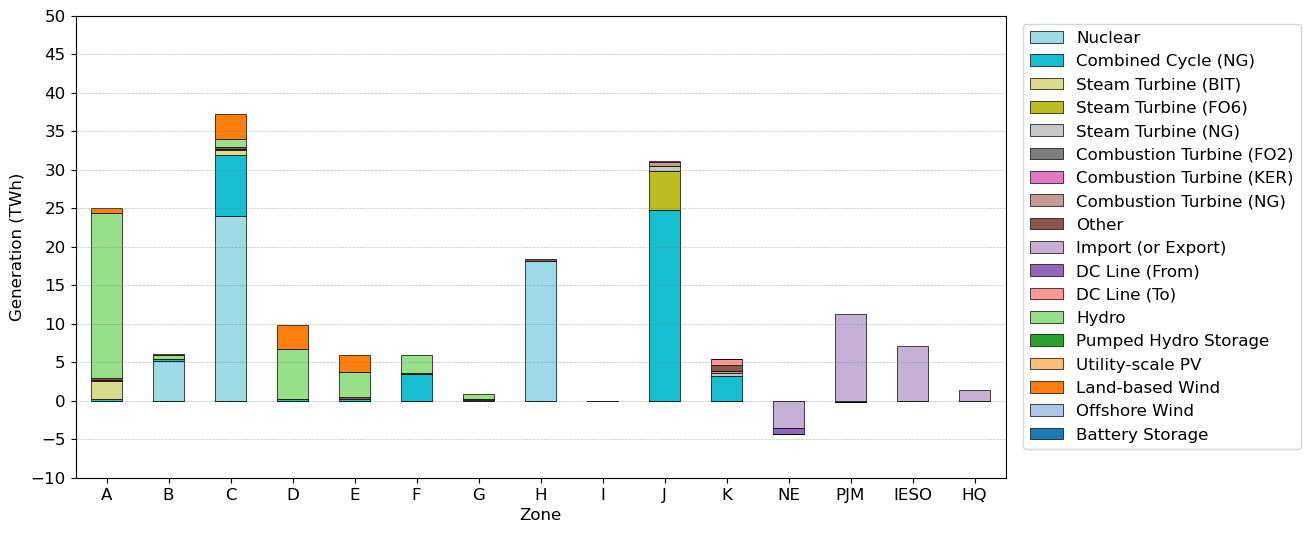

In [52]:
# A.
fig, ax = plt.subplots(figsize=(12, 6))
pg_by_fuel_sum_by_zone_2018NewParams.plot(ax=ax, kind='bar', stacked=True, figsize=(12, 6),
                            colormap='tab20_r', edgecolor='black', linewidth=0.5)
ax.set_xlabel('Zone', fontsize=12)
ax.set_ylabel('Generation (TWh)', fontsize=12)
ax.legend(bbox_to_anchor=(1.01, 1), loc='upper left',
          fontsize=12)
ax.tick_params(axis='x', rotation=0)
ax.tick_params(axis='both', labelsize=12)
ax.set_ylim(-10, 50)
ax.set_yticks(np.arange(-10, 51, 5))
ax.grid(axis='y', color='gray', lw=0.5, ls='--', alpha=0.5)
fig.savefig(os.path.join(fig_dir, 
                         'pg_by_fuel_sum_by_zone_2018NewParams.png'), 
            bbox_inches='tight')
plt.show()

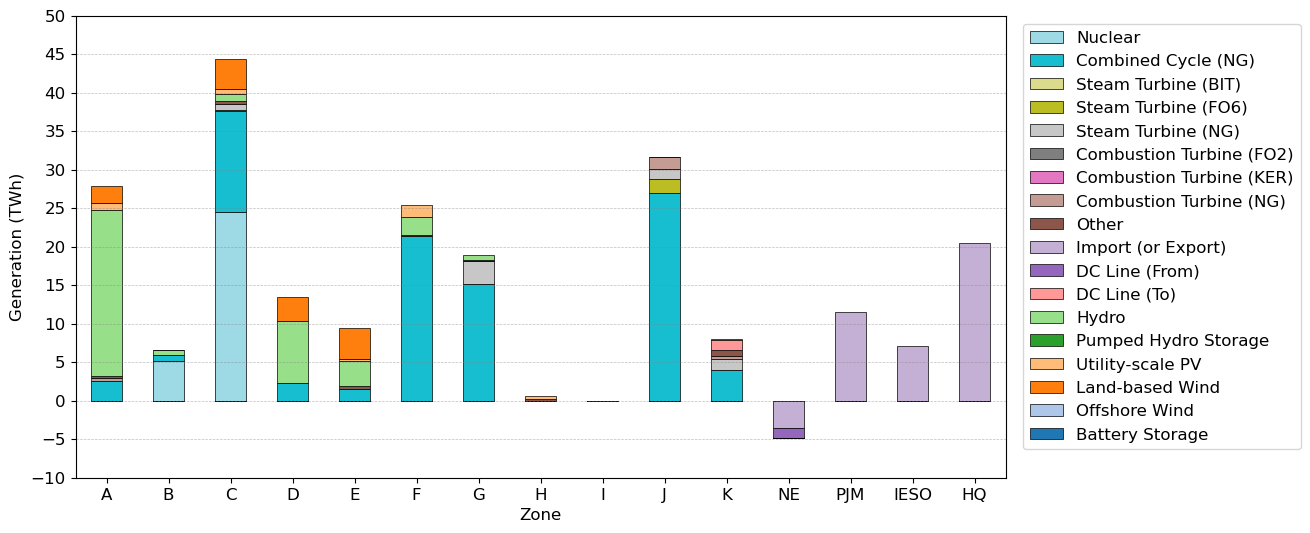

In [53]:
# B.0.
fig, ax = plt.subplots(figsize=(12, 6))
pg_by_fuel_sum_by_zone_2030BaselineCase.plot(ax=ax, kind='bar', stacked=True, figsize=(12, 6),
                            colormap='tab20_r', edgecolor='black', linewidth=0.5)
ax.set_xlabel('Zone', fontsize=12)
ax.set_ylabel('Generation (TWh)', fontsize=12)
ax.legend(bbox_to_anchor=(1.01, 1), loc='upper left',
          fontsize=12)
ax.tick_params(axis='x', rotation=0)
ax.tick_params(axis='both', labelsize=12)
ax.set_ylim(-10, 50)
ax.set_yticks(np.arange(-10, 51, 5))
ax.grid(axis='y', color='gray', lw=0.5, ls='--', alpha=0.5)
fig.savefig(os.path.join(fig_dir, 
                         'pg_by_fuel_sum_by_zone_2030BaselineCase.png'), 
            bbox_inches='tight')
plt.show()

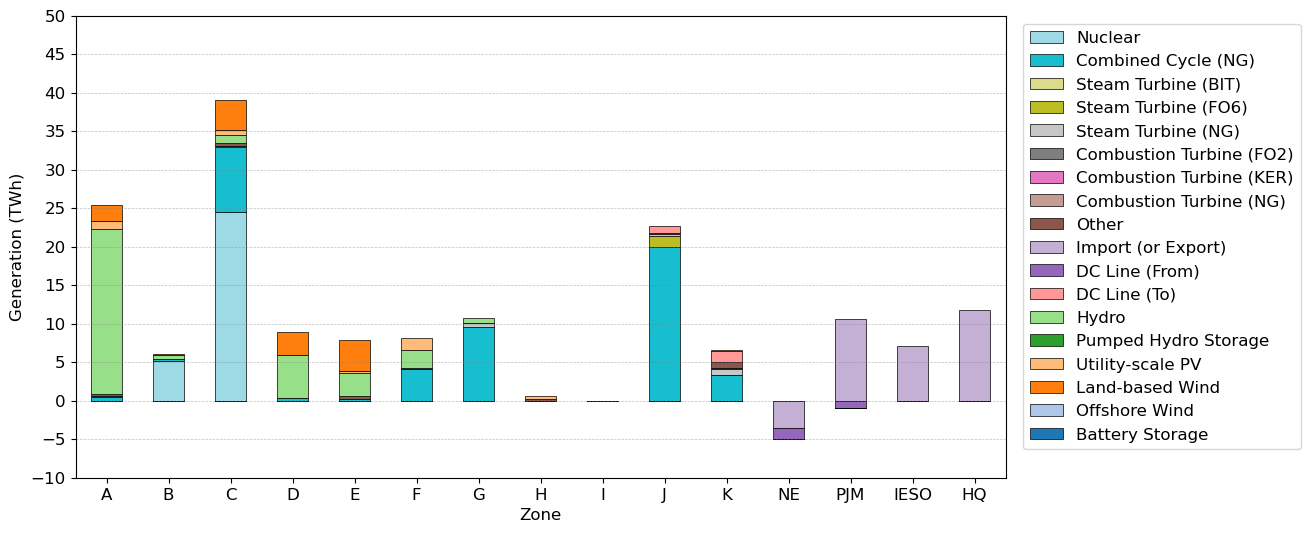

In [54]:
# B.1.
fig, ax = plt.subplots(figsize=(12, 6))
pg_by_fuel_sum_by_zone_2030BaselineCase_NoLargeLoad.plot(ax=ax, kind='bar', stacked=True, figsize=(12, 6),
                            colormap='tab20_r', edgecolor='black', linewidth=0.5)
ax.set_xlabel('Zone', fontsize=12)
ax.set_ylabel('Generation (TWh)', fontsize=12)
ax.legend(bbox_to_anchor=(1.01, 1), loc='upper left',
          fontsize=12)
ax.tick_params(axis='x', rotation=0)
ax.tick_params(axis='both', labelsize=12)
ax.set_ylim(-10, 50)
ax.set_yticks(np.arange(-10, 51, 5))
ax.grid(axis='y', color='gray', lw=0.5, ls='--', alpha=0.5)
fig.savefig(os.path.join(fig_dir, 
                         'pg_by_fuel_sum_by_zone_2030BaselineCase_NoLargeLoad.png'), 
            bbox_inches='tight')
plt.show()

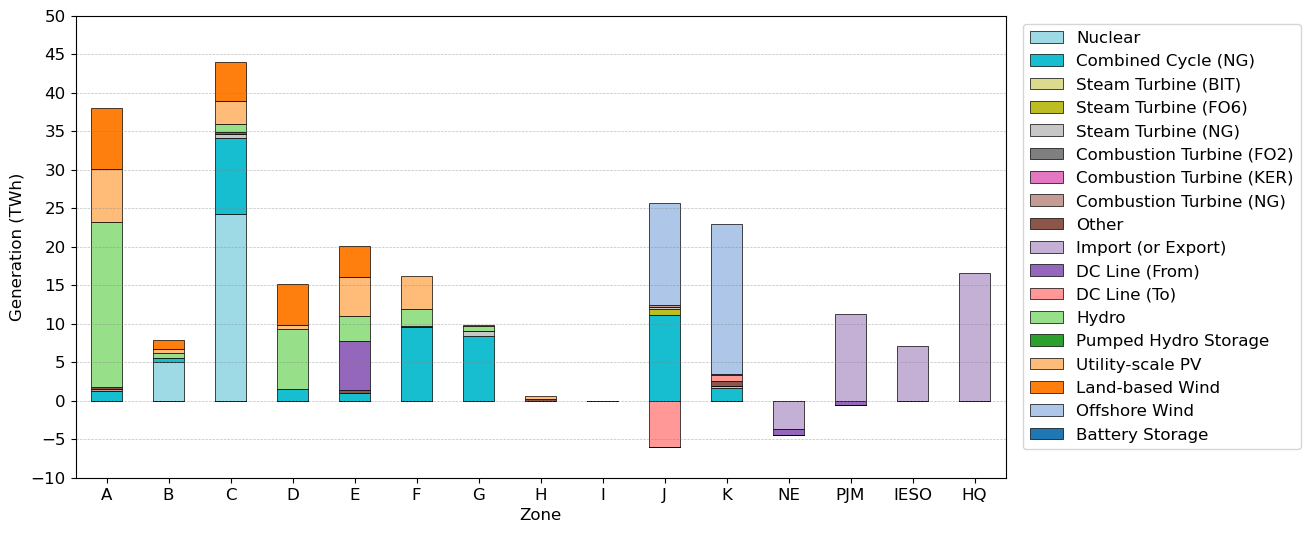

In [55]:
# C.0.
fig, ax = plt.subplots(figsize=(12, 6))
pg_by_fuel_sum_by_zone_2030ContractCase.plot(ax=ax, kind='bar', stacked=True, figsize=(12, 6),
                            colormap='tab20_r', edgecolor='black', linewidth=0.5)
ax.set_xlabel('Zone', fontsize=12)
ax.set_ylabel('Generation (TWh)', fontsize=12)
ax.legend(bbox_to_anchor=(1.01, 1), loc='upper left',
          fontsize=12)
ax.tick_params(axis='x', rotation=0)
ax.tick_params(axis='both', labelsize=12)
ax.set_ylim(-10, 50)
ax.set_yticks(np.arange(-10, 51, 5))
ax.grid(axis='y', color='gray', lw=0.5, ls='--', alpha=0.5)
fig.savefig(os.path.join(fig_dir, 
                         'pg_by_fuel_sum_by_zone_2030ContractCase.png'), 
            bbox_inches='tight')
plt.show()

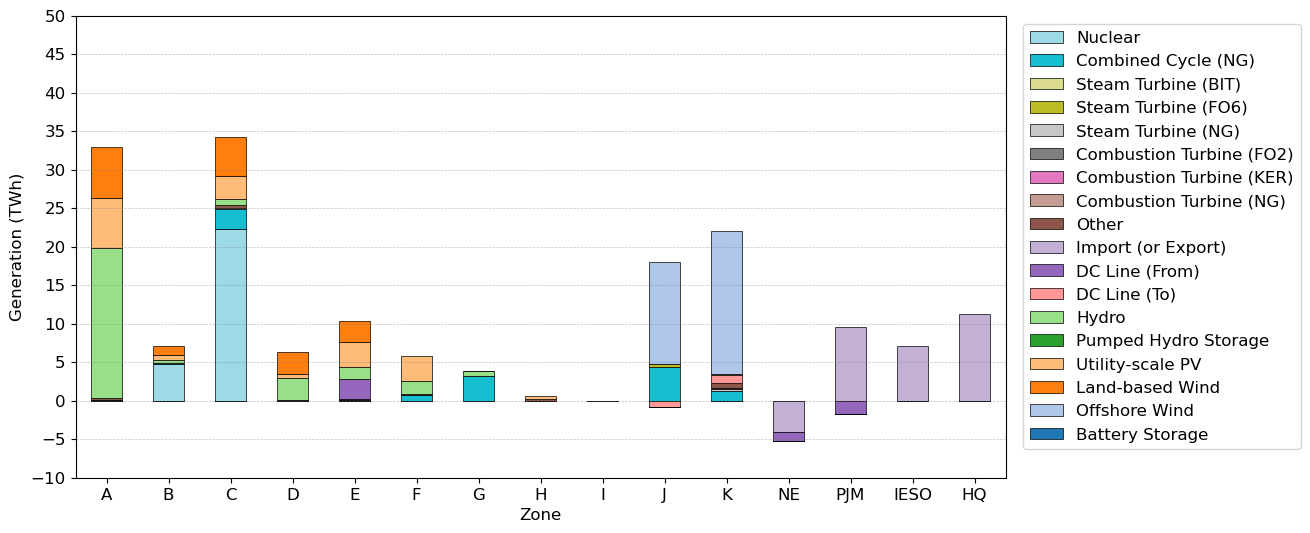

In [56]:
# C.1.
fig, ax = plt.subplots(figsize=(12, 6))
pg_by_fuel_sum_by_zone_2030ContractCase_NoLargeLoad.plot(ax=ax, kind='bar', stacked=True, figsize=(12, 6),
                            colormap='tab20_r', edgecolor='black', linewidth=0.5)
ax.set_xlabel('Zone', fontsize=12)
ax.set_ylabel('Generation (TWh)', fontsize=12)
ax.legend(bbox_to_anchor=(1.01, 1), loc='upper left',
          fontsize=12)
ax.tick_params(axis='x', rotation=0)
ax.tick_params(axis='both', labelsize=12)
ax.set_ylim(-10, 50)
ax.set_yticks(np.arange(-10, 51, 5))
ax.grid(axis='y', color='gray', lw=0.5, ls='--', alpha=0.5)
fig.savefig(os.path.join(fig_dir, 
                         'pg_by_fuel_sum_by_zone_2030ContractCase_NoLargeLoad.png'), 
            bbox_inches='tight')
plt.show()

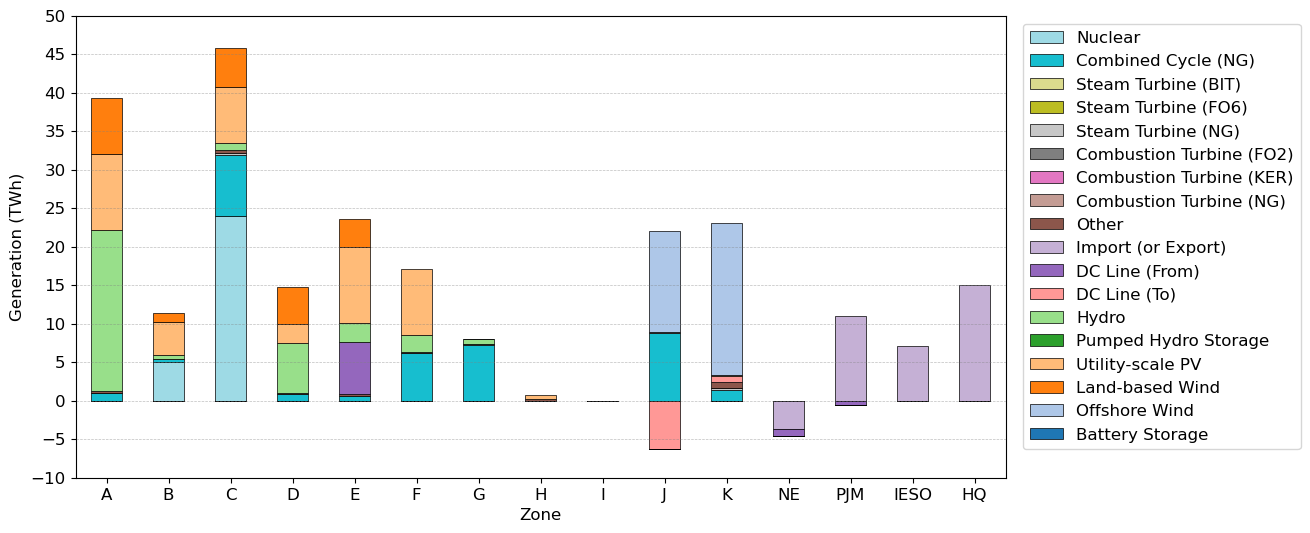

In [57]:
# D.0.
fig, ax = plt.subplots(figsize=(12, 6))
pg_by_fuel_sum_by_zone_2030StateScenario.plot(ax=ax, kind='bar', stacked=True, figsize=(12, 6),
                            colormap='tab20_r', edgecolor='black', linewidth=0.5)
ax.set_xlabel('Zone', fontsize=12)
ax.set_ylabel('Generation (TWh)', fontsize=12)
ax.legend(bbox_to_anchor=(1.01, 1), loc='upper left',
          fontsize=12)
ax.tick_params(axis='x', rotation=0)
ax.tick_params(axis='both', labelsize=12)
ax.set_ylim(-10, 50)
ax.set_yticks(np.arange(-10, 51, 5))
ax.grid(axis='y', color='gray', lw=0.5, ls='--', alpha=0.5)
fig.savefig(os.path.join(fig_dir, 
                         'pg_by_fuel_sum_by_zone_2030StateScenario.png'), 
            bbox_inches='tight')
plt.show()

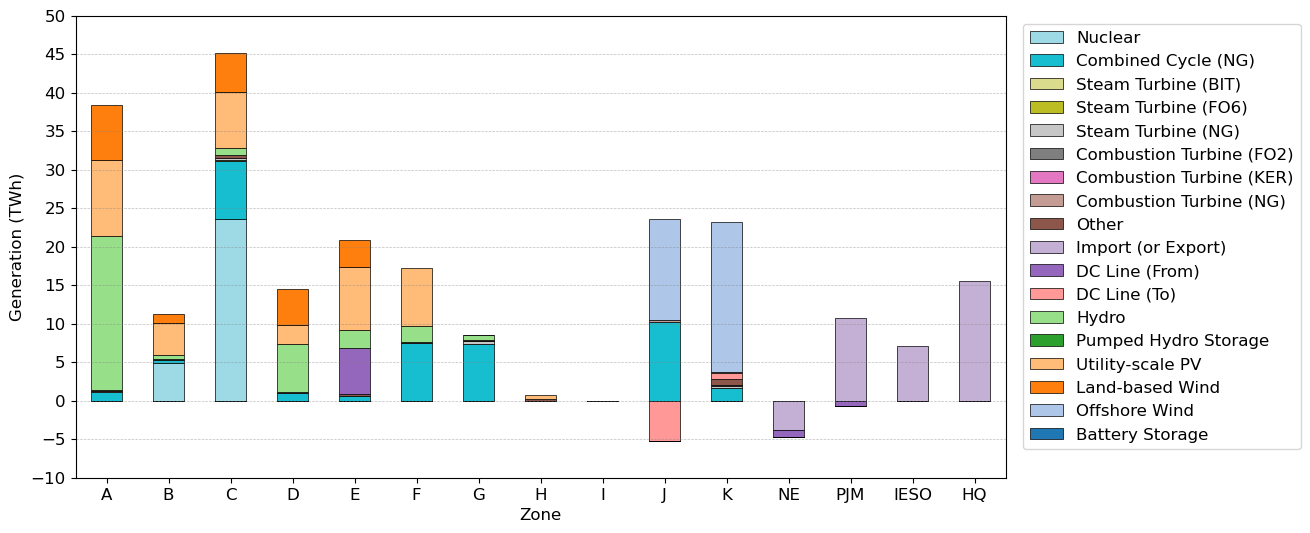

In [58]:
# D.1.
fig, ax = plt.subplots(figsize=(12, 6))
pg_by_fuel_sum_by_zone_2030StateScenario_FewerESR.plot(ax=ax, kind='bar', stacked=True, figsize=(12, 6),
                            colormap='tab20_r', edgecolor='black', linewidth=0.5)
ax.set_xlabel('Zone', fontsize=12)
ax.set_ylabel('Generation (TWh)', fontsize=12)
ax.legend(bbox_to_anchor=(1.01, 1), loc='upper left',
          fontsize=12)
ax.tick_params(axis='x', rotation=0)
ax.tick_params(axis='both', labelsize=12)
ax.set_ylim(-10, 50)
ax.set_yticks(np.arange(-10, 51, 5))
ax.grid(axis='y', color='gray', lw=0.5, ls='--', alpha=0.5)
fig.savefig(os.path.join(fig_dir, 
                         'pg_by_fuel_sum_by_zone_2030StateScenario_FewerESR.png'), 
            bbox_inches='tight')
plt.show()

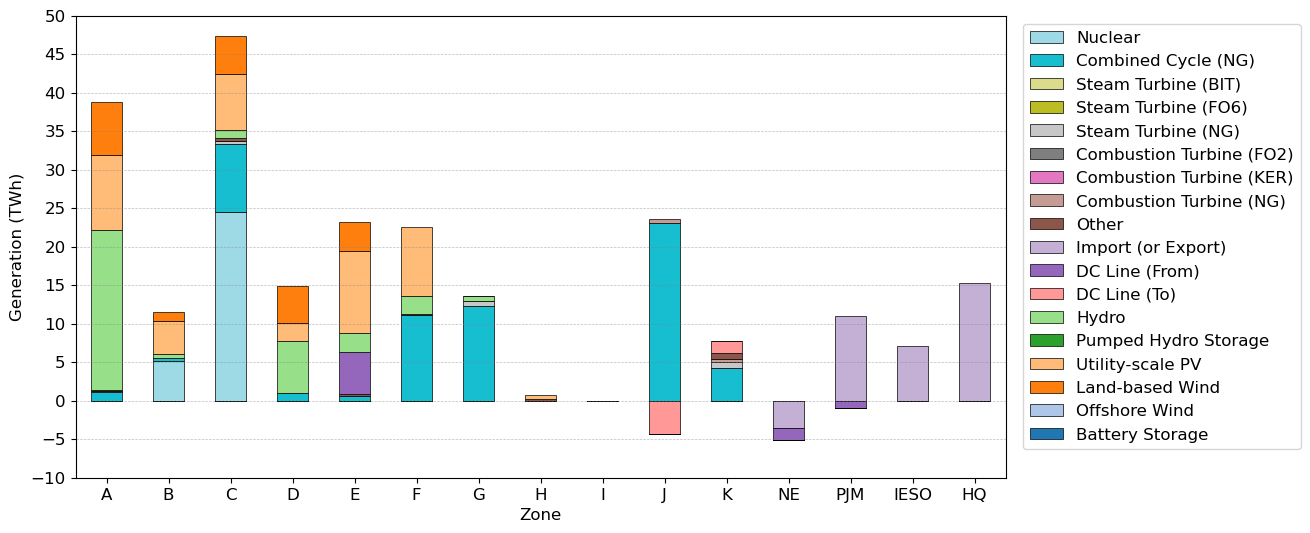

In [59]:
# D.2.
fig, ax = plt.subplots(figsize=(12, 6))
pg_by_fuel_sum_by_zone_2030StateScenario_FewerOSW.plot(ax=ax, kind='bar', stacked=True, figsize=(12, 6),
                            colormap='tab20_r', edgecolor='black', linewidth=0.5)
ax.set_xlabel('Zone', fontsize=12)
ax.set_ylabel('Generation (TWh)', fontsize=12)
ax.legend(bbox_to_anchor=(1.01, 1), loc='upper left',
          fontsize=12)
ax.tick_params(axis='x', rotation=0)
ax.tick_params(axis='both', labelsize=12)
ax.set_ylim(-10, 50)
ax.set_yticks(np.arange(-10, 51, 5))
ax.grid(axis='y', color='gray', lw=0.5, ls='--', alpha=0.5)
fig.savefig(os.path.join(fig_dir, 
                         'pg_by_fuel_sum_by_zone_2030StateScenario_FewerOSW.png'), 
            bbox_inches='tight')
plt.show()

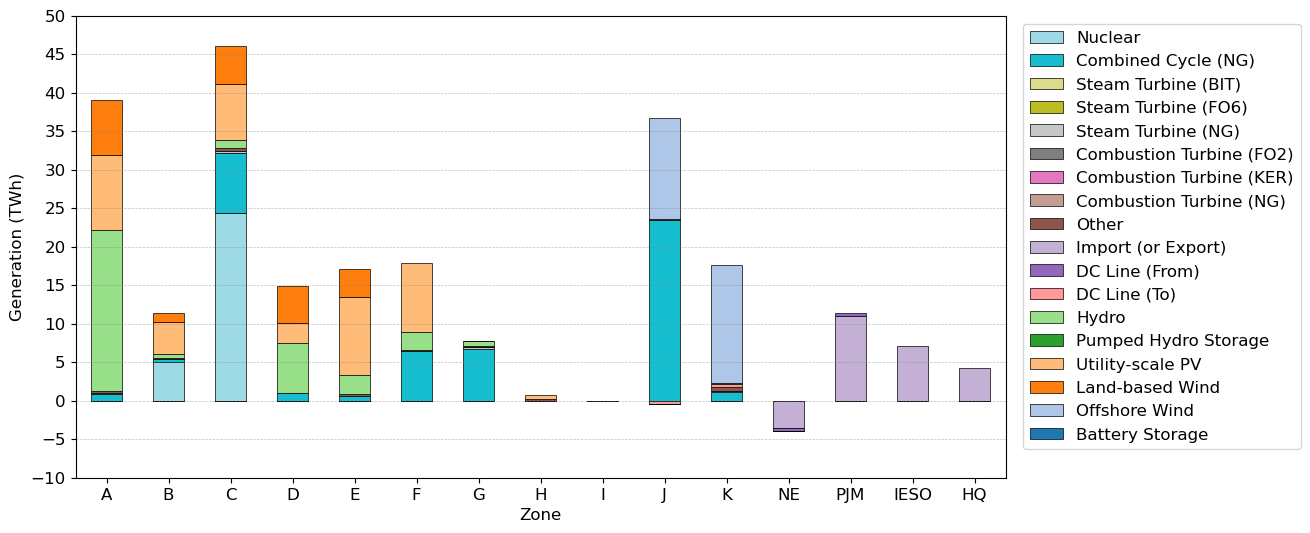

In [60]:
# D.3.
fig, ax = plt.subplots(figsize=(12, 6))
pg_by_fuel_sum_by_zone_2030StateScenario_NoTxUpgrade.plot(ax=ax, kind='bar', stacked=True, figsize=(12, 6),
                            colormap='tab20_r', edgecolor='black', linewidth=0.5)
ax.set_xlabel('Zone', fontsize=12)
ax.set_ylabel('Generation (TWh)', fontsize=12)
ax.legend(bbox_to_anchor=(1.01, 1), loc='upper left',
          fontsize=12)
ax.tick_params(axis='x', rotation=0)
ax.tick_params(axis='both', labelsize=12)
ax.set_ylim(-10, 50)
ax.set_yticks(np.arange(-10, 51, 5))
ax.grid(axis='y', color='gray', lw=0.5, ls='--', alpha=0.5)
fig.savefig(os.path.join(fig_dir, 
                         'pg_by_fuel_sum_by_zone_2030StateScenario_NoTxUpgrade.png'), 
            bbox_inches='tight')
plt.show()

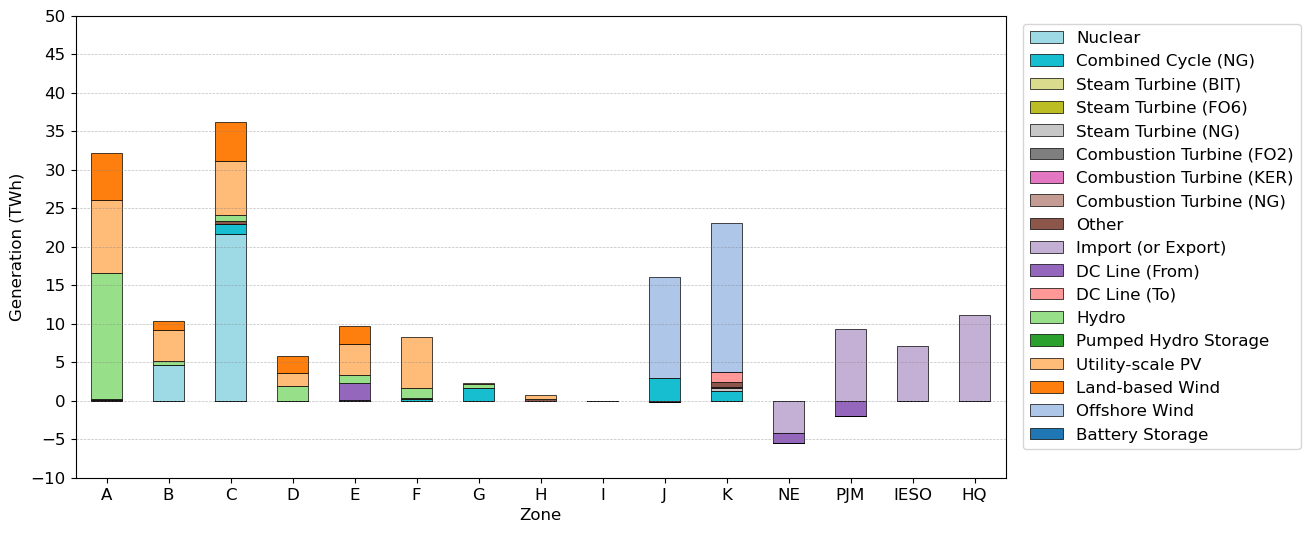

In [61]:
# D.4.
fig, ax = plt.subplots(figsize=(12, 6))
pg_by_fuel_sum_by_zone_2030StateScenario_NoLargeLoad.plot(ax=ax, kind='bar', stacked=True, figsize=(12, 6),
                            colormap='tab20_r', edgecolor='black', linewidth=0.5)
ax.set_xlabel('Zone', fontsize=12)
ax.set_ylabel('Generation (TWh)', fontsize=12)
ax.legend(bbox_to_anchor=(1.01, 1), loc='upper left',
          fontsize=12)
ax.tick_params(axis='x', rotation=0)
ax.tick_params(axis='both', labelsize=12)
ax.set_ylim(-10, 50)
ax.set_yticks(np.arange(-10, 51, 5))
ax.grid(axis='y', color='gray', lw=0.5, ls='--', alpha=0.5)
fig.savefig(os.path.join(fig_dir, 
                         'pg_by_fuel_sum_by_zone_2030StateScenario_NoLargeLoad.png'), 
            bbox_inches='tight')
plt.show()

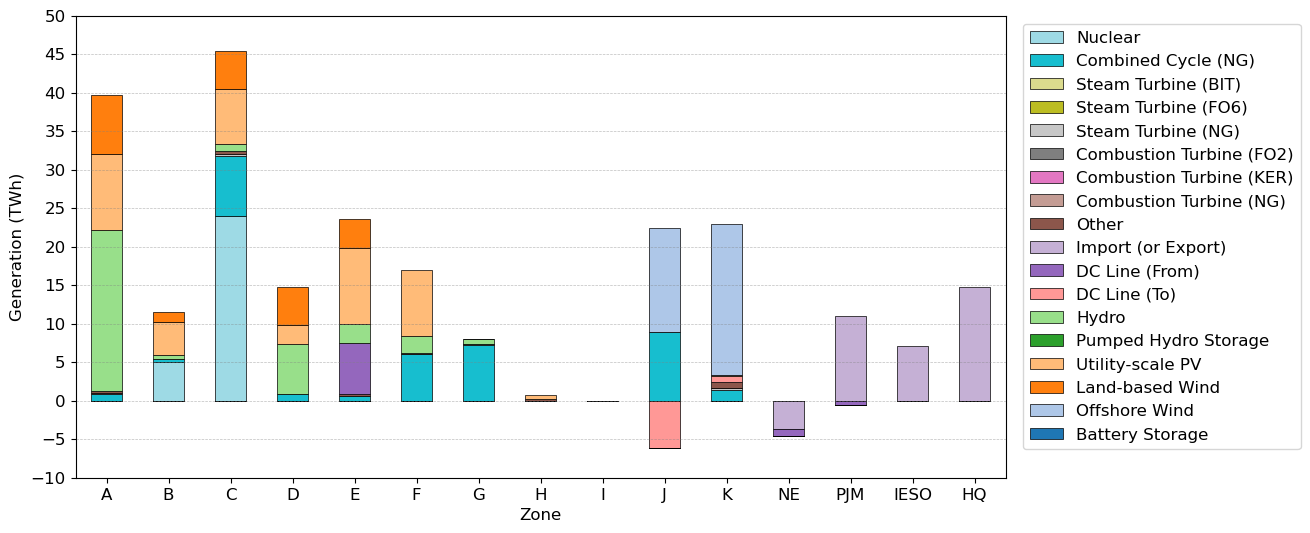

In [62]:
# D.5.
fig, ax = plt.subplots(figsize=(12, 6))
pg_by_fuel_sum_by_zone_2030StateScenario_AvgRenew.plot(ax=ax, kind='bar', stacked=True, figsize=(12, 6),
                            colormap='tab20_r', edgecolor='black', linewidth=0.5)
ax.set_xlabel('Zone', fontsize=12)
ax.set_ylabel('Generation (TWh)', fontsize=12)
ax.legend(bbox_to_anchor=(1.01, 1), loc='upper left',
          fontsize=12)
ax.tick_params(axis='x', rotation=0)
ax.tick_params(axis='both', labelsize=12)
ax.set_ylim(-10, 50)
ax.set_yticks(np.arange(-10, 51, 5))
ax.grid(axis='y', color='gray', lw=0.5, ls='--', alpha=0.5)
fig.savefig(os.path.join(fig_dir, 
                         'pg_by_fuel_sum_by_zone_2030StateScenario_AvgRenew.png'), 
            bbox_inches='tight')
plt.show()

In [63]:
pg_by_zone_sum_2018NewParams = pg_by_fuel_sum_by_zone_2018NewParams.sum(axis=1)

pg_by_zone_sum_2030BaselineCase = pg_by_fuel_sum_by_zone_2030BaselineCase.sum(axis=1)
pg_by_zone_sum_2030BaselineCase_NoLargeLoad = pg_by_fuel_sum_by_zone_2030BaselineCase_NoLargeLoad.sum(axis=1)

pg_by_zone_sum_2030ContractCase = pg_by_fuel_sum_by_zone_2030ContractCase.sum(axis=1)
pg_by_zone_sum_2030ContractCase_NoLargeLoad = pg_by_fuel_sum_by_zone_2030ContractCase_NoLargeLoad.sum(axis=1)

pg_by_zone_sum_2030StateScenario = pg_by_fuel_sum_by_zone_2030StateScenario.sum(axis=1)
pg_by_zone_sum_2030StateScenario_FewerESR = pg_by_fuel_sum_by_zone_2030StateScenario_FewerESR.sum(axis=1)
pg_by_zone_sum_2030StateScenario_FewerOSW = pg_by_fuel_sum_by_zone_2030StateScenario_FewerOSW.sum(axis=1)
pg_by_zone_sum_2030StateScenario_NoTxUpgrade = pg_by_fuel_sum_by_zone_2030StateScenario_NoTxUpgrade.sum(axis=1)
pg_by_zone_sum_2030StateScenario_NoLargeLoad = pg_by_fuel_sum_by_zone_2030StateScenario_NoLargeLoad.sum(axis=1)
pg_by_zone_sum_2030StateScenario_AvgRenew = pg_by_fuel_sum_by_zone_2030StateScenario_AvgRenew.sum(axis=1)

pg_by_zone_sum_summary = pd.DataFrame({
    '2018\nNewParams': pg_by_zone_sum_2018NewParams,
    '2030\nBaseline\nCase': pg_by_zone_sum_2030BaselineCase,
    '2030\nBaseline\nCase\nNoLargeLoad': pg_by_zone_sum_2030BaselineCase_NoLargeLoad,
    '2030\nContract\nCase': pg_by_zone_sum_2030ContractCase,
    '2030\nContract\nCase\nNoLargeLoad': pg_by_zone_sum_2030ContractCase_NoLargeLoad,
    '2030\nState\nScenario': pg_by_zone_sum_2030StateScenario,
    '2030\nState\nScenario\nFewerESR': pg_by_zone_sum_2030StateScenario_FewerESR,
    '2030\nState\nScenario\nNoOSW': pg_by_zone_sum_2030StateScenario_FewerOSW,
    '2030\nState\nScenario\nNoTxUpgrade': pg_by_zone_sum_2030StateScenario_NoTxUpgrade,
    '2030\nState\nScenario\nNoLargeLoad': pg_by_zone_sum_2030StateScenario_NoLargeLoad,
    # '2030\nState\nScenario\nAvgRenew': pg_by_zone_sum_2030StateScenario_AvgRenew,
})

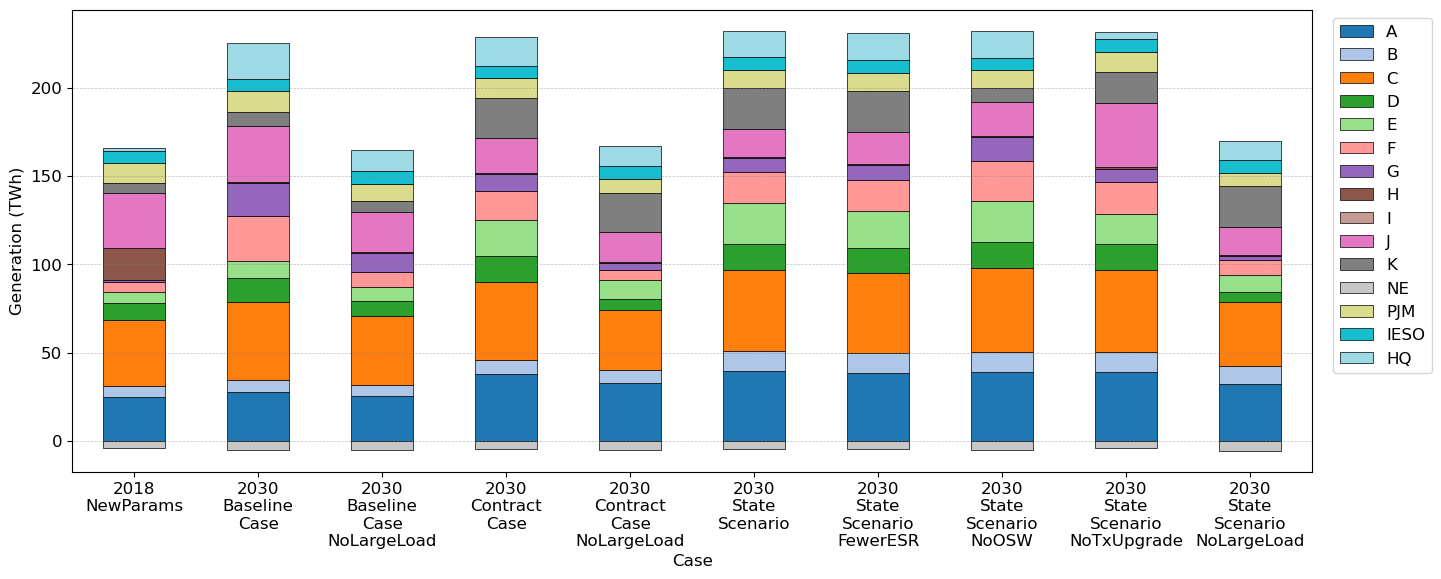

In [64]:
fig, ax = plt.subplots(figsize=(16, 6))
pg_by_zone_sum_summary.T.plot(ax=ax, kind='bar', stacked=True,
                            colormap='tab20', edgecolor='black', linewidth=0.5)
ax.set_xlabel('Case', fontsize=12)
ax.set_ylabel('Generation (TWh)', fontsize=12)
ax.legend(bbox_to_anchor=(1.01, 1), loc='upper left',
          fontsize=12)
ax.tick_params(axis='x', rotation=0)
ax.tick_params(axis='both', labelsize=12)
# ax.set_ylim(-50, 250)
# ax.set_yticks(np.arange(-2, 23, 2))
ax.grid(axis='y', color='gray', lw=0.5, ls='--', alpha=0.5)
fig.savefig(os.path.join(fig_dir, 
                         'pg_by_zone_sum_summary.png'), 
            bbox_inches='tight')
plt.show()

### 2. Power generation by fuel type by month

In [65]:
# A.
pg_by_fuel_sum_by_month_2018NewParams = calc_pg_by_fuel_sum_by_month(
    pg_by_fuel_dict_2018NewParams,
    gen_fuel_rename)

# B.0.
pg_by_fuel_sum_by_month_2030BaselineCase = calc_pg_by_fuel_sum_by_month(
    pg_by_fuel_dict_2030BaselineCase,
    gen_fuel_rename)

# B.1.
pg_by_fuel_sum_by_month_2030BaselineCase_NoLargeLoad = calc_pg_by_fuel_sum_by_month(
    pg_by_fuel_dict_2030BaselineCase_NoLargeLoad,
    gen_fuel_rename)

# C.0.
pg_by_fuel_sum_by_month_2030ContractCase = calc_pg_by_fuel_sum_by_month(
    pg_by_fuel_dict_2030ContractCase,
    gen_fuel_rename)

# C.1.
pg_by_fuel_sum_by_month_2030ContractCase_NoLargeLoad = calc_pg_by_fuel_sum_by_month(
    pg_by_fuel_dict_2030ContractCase_NoLargeLoad,
    gen_fuel_rename)

# D.0.
pg_by_fuel_sum_by_month_2030StateScenario = calc_pg_by_fuel_sum_by_month(
    pg_by_fuel_dict_2030StateScenario,
    gen_fuel_rename)

# D.1.
pg_by_fuel_sum_by_month_2030StateScenario_FewerESR = calc_pg_by_fuel_sum_by_month(
    pg_by_fuel_dict_2030StateScenario_FewerESR,
    gen_fuel_rename)

# D.2.
pg_by_fuel_sum_by_month_2030StateScenario_FewerOSW = calc_pg_by_fuel_sum_by_month(
    pg_by_fuel_dict_2030StateScenario_FewerOSW,
    gen_fuel_rename)

# D.3.
pg_by_fuel_sum_by_month_2030StateScenario_NoTxUpgrade = calc_pg_by_fuel_sum_by_month(
    pg_by_fuel_dict_2030StateScenario_NoTxUpgrade,
    gen_fuel_rename)

# D.4.
pg_by_fuel_sum_by_month_2030StateScenario_NoLargeLoad = calc_pg_by_fuel_sum_by_month(
    pg_by_fuel_dict_2030StateScenario_NoLargeLoad,
    gen_fuel_rename)

# D.5.
pg_by_fuel_sum_by_month_2030StateScenario_AvgRenew = calc_pg_by_fuel_sum_by_month(
    pg_by_fuel_dict_2030StateScenario_AvgRenew,
    gen_fuel_rename)

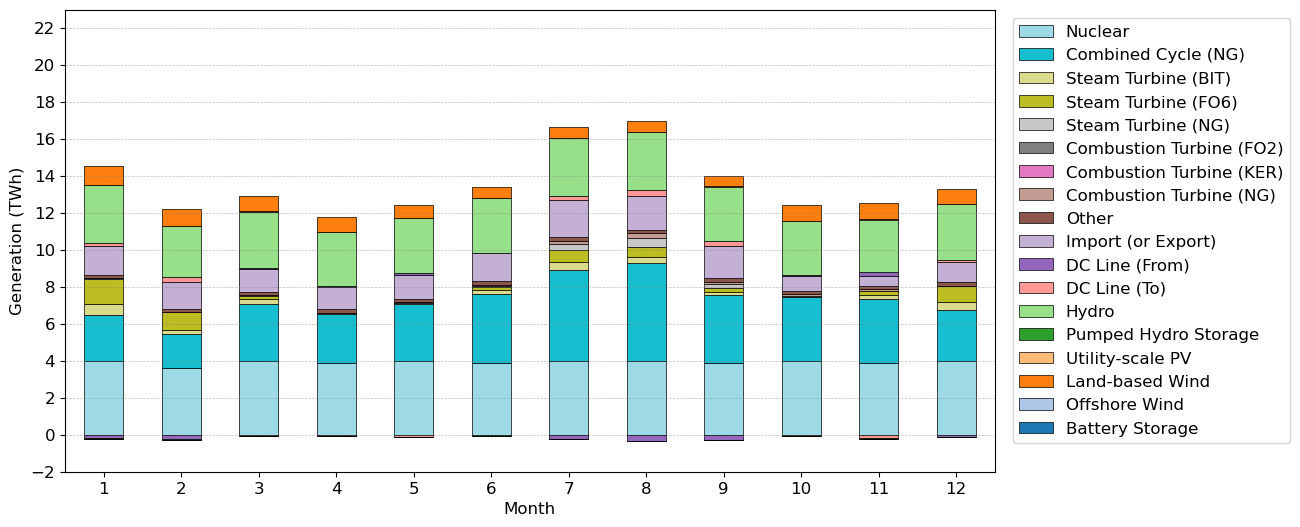

In [66]:
# A.
fig, ax = plt.subplots(figsize=(12, 6))
pg_by_fuel_sum_by_month_2018NewParams.plot(ax=ax, kind='bar', stacked=True, figsize=(12, 6),
                            colormap='tab20_r', edgecolor='black', linewidth=0.5)
ax.set_xlabel('Month', fontsize=12)
ax.set_ylabel('Generation (TWh)', fontsize=12)
ax.legend(bbox_to_anchor=(1.01, 1), loc='upper left',
          fontsize=12)
ax.tick_params(axis='x', rotation=0)
ax.tick_params(axis='both', labelsize=12)
ax.set_ylim(-2, 23)
ax.set_yticks(np.arange(-2, 23, 2))
ax.grid(axis='y', color='gray', lw=0.5, ls='--', alpha=0.5)
fig.savefig(os.path.join(fig_dir, 
                         'pg_by_fuel_sum_by_month_2018NewParams.png'), 
            bbox_inches='tight')
plt.show()

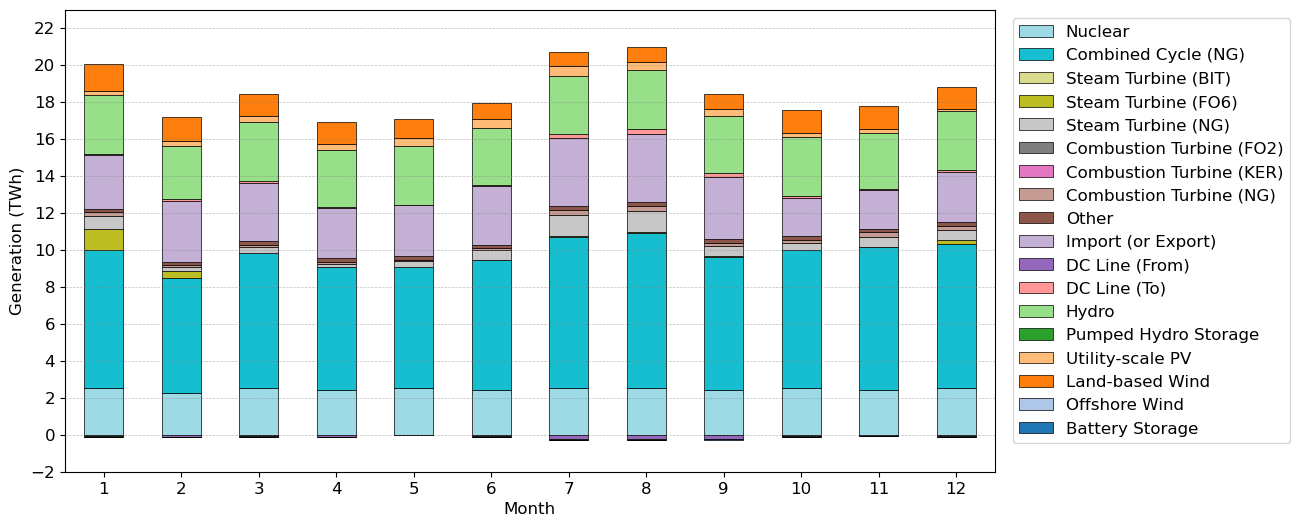

In [67]:
# B.0.
fig, ax = plt.subplots(figsize=(12, 6))
pg_by_fuel_sum_by_month_2030BaselineCase.plot(ax=ax, kind='bar', stacked=True, figsize=(12, 6),
                            colormap='tab20_r', edgecolor='black', linewidth=0.5)
ax.set_xlabel('Month', fontsize=12)
ax.set_ylabel('Generation (TWh)', fontsize=12)
ax.legend(bbox_to_anchor=(1.01, 1), loc='upper left',
          fontsize=12)
ax.tick_params(axis='x', rotation=0)
ax.tick_params(axis='both', labelsize=12)
ax.set_ylim(-2, 23)
ax.set_yticks(np.arange(-2, 23, 2))
ax.grid(axis='y', color='gray', lw=0.5, ls='--', alpha=0.5)
fig.savefig(os.path.join(fig_dir, 
                         'pg_by_fuel_sum_by_month_2030BaselineCase.png'), 
            bbox_inches='tight')
plt.show()

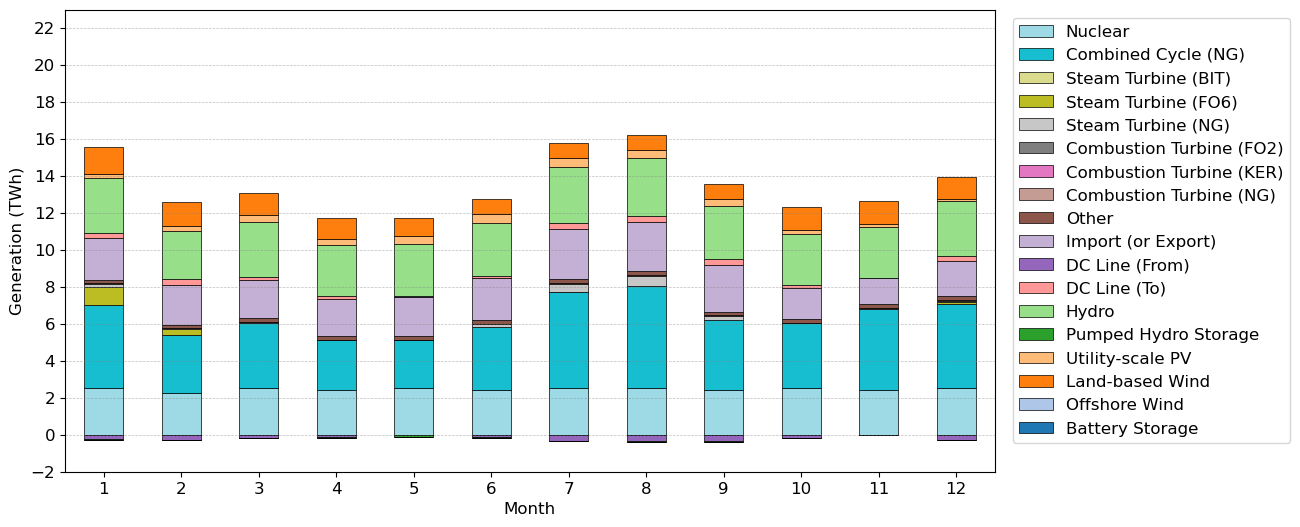

In [68]:
# B.1.
fig, ax = plt.subplots(figsize=(12, 6))
pg_by_fuel_sum_by_month_2030BaselineCase_NoLargeLoad.plot(ax=ax, kind='bar', stacked=True, figsize=(12, 6),
                            colormap='tab20_r', edgecolor='black', linewidth=0.5)
ax.set_xlabel('Month', fontsize=12)
ax.set_ylabel('Generation (TWh)', fontsize=12)
ax.legend(bbox_to_anchor=(1.01, 1), loc='upper left',
          fontsize=12)
ax.tick_params(axis='x', rotation=0)
ax.tick_params(axis='both', labelsize=12)
ax.set_ylim(-2, 23)
ax.set_yticks(np.arange(-2, 23, 2))
ax.grid(axis='y', color='gray', lw=0.5, ls='--', alpha=0.5)
fig.savefig(os.path.join(fig_dir, 
                         'pg_by_fuel_sum_by_month_2030BaselineCase_NoLargeLoad.png'), 
            bbox_inches='tight')
plt.show()

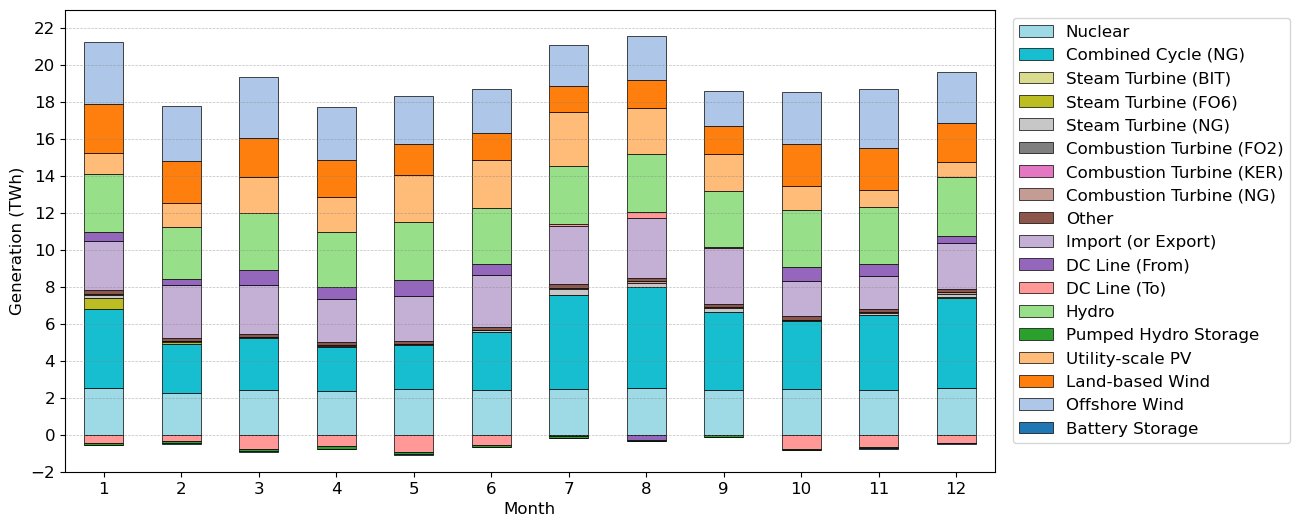

In [69]:
# C.0.
fig, ax = plt.subplots(figsize=(12, 6))
pg_by_fuel_sum_by_month_2030ContractCase.plot(ax=ax, kind='bar', stacked=True, figsize=(12, 6),
                            colormap='tab20_r', edgecolor='black', linewidth=0.5)
ax.set_xlabel('Month', fontsize=12)
ax.set_ylabel('Generation (TWh)', fontsize=12)
ax.legend(bbox_to_anchor=(1.01, 1), loc='upper left',
          fontsize=12)
ax.tick_params(axis='x', rotation=0)
ax.tick_params(axis='both', labelsize=12)
ax.set_ylim(-2, 23)
ax.set_yticks(np.arange(-2, 23, 2))
ax.grid(axis='y', color='gray', lw=0.5, ls='--', alpha=0.5)
fig.savefig(os.path.join(fig_dir, 
                         'pg_by_fuel_sum_by_month_2030ContractCase.png'), 
            bbox_inches='tight')
plt.show()

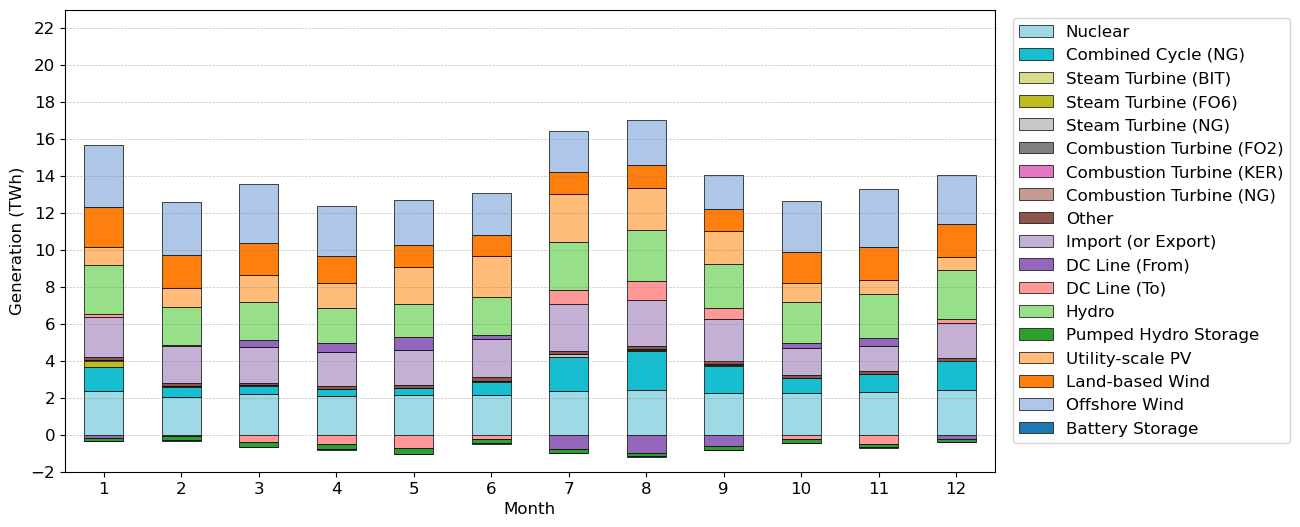

In [70]:
# C.1.
fig, ax = plt.subplots(figsize=(12, 6))
pg_by_fuel_sum_by_month_2030ContractCase_NoLargeLoad.plot(ax=ax, kind='bar', stacked=True, figsize=(12, 6),
                            colormap='tab20_r', edgecolor='black', linewidth=0.5)
ax.set_xlabel('Month', fontsize=12)
ax.set_ylabel('Generation (TWh)', fontsize=12)
ax.legend(bbox_to_anchor=(1.01, 1), loc='upper left',
          fontsize=12)
ax.tick_params(axis='x', rotation=0)
ax.tick_params(axis='both', labelsize=12)
ax.set_ylim(-2, 23)
ax.set_yticks(np.arange(-2, 23, 2))
ax.grid(axis='y', color='gray', lw=0.5, ls='--', alpha=0.5)
fig.savefig(os.path.join(fig_dir, 
                         'pg_by_fuel_sum_by_month_2030ContractCase_NoLargeLoad.png'), 
            bbox_inches='tight')
plt.show()

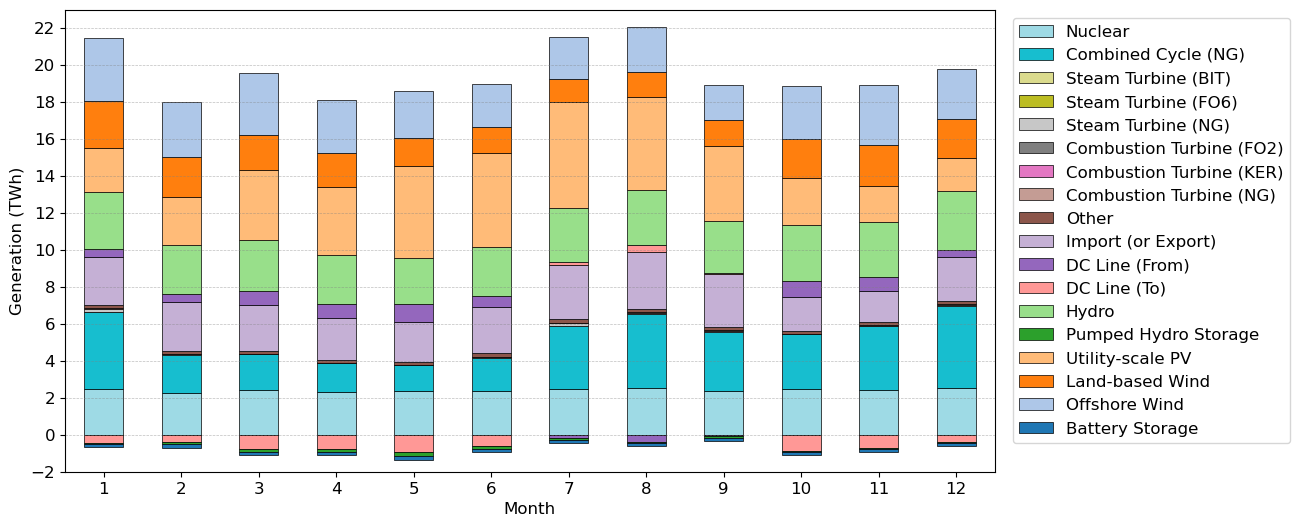

In [71]:
# D.0.
fig, ax = plt.subplots(figsize=(12, 6))
pg_by_fuel_sum_by_month_2030StateScenario.plot(ax=ax, kind='bar', stacked=True, figsize=(12, 6),
                            colormap='tab20_r', edgecolor='black', linewidth=0.5)
ax.set_xlabel('Month', fontsize=12)
ax.set_ylabel('Generation (TWh)', fontsize=12)
ax.legend(bbox_to_anchor=(1.01, 1), loc='upper left',
          fontsize=12)
ax.tick_params(axis='x', rotation=0)
ax.tick_params(axis='both', labelsize=12)
ax.set_ylim(-2, 23)
ax.set_yticks(np.arange(-2, 23, 2))
ax.grid(axis='y', color='gray', lw=0.5, ls='--', alpha=0.5)
fig.savefig(os.path.join(fig_dir, 
                         'pg_by_fuel_sum_by_month_2030StateScenario.png'), 
            bbox_inches='tight')
plt.show()

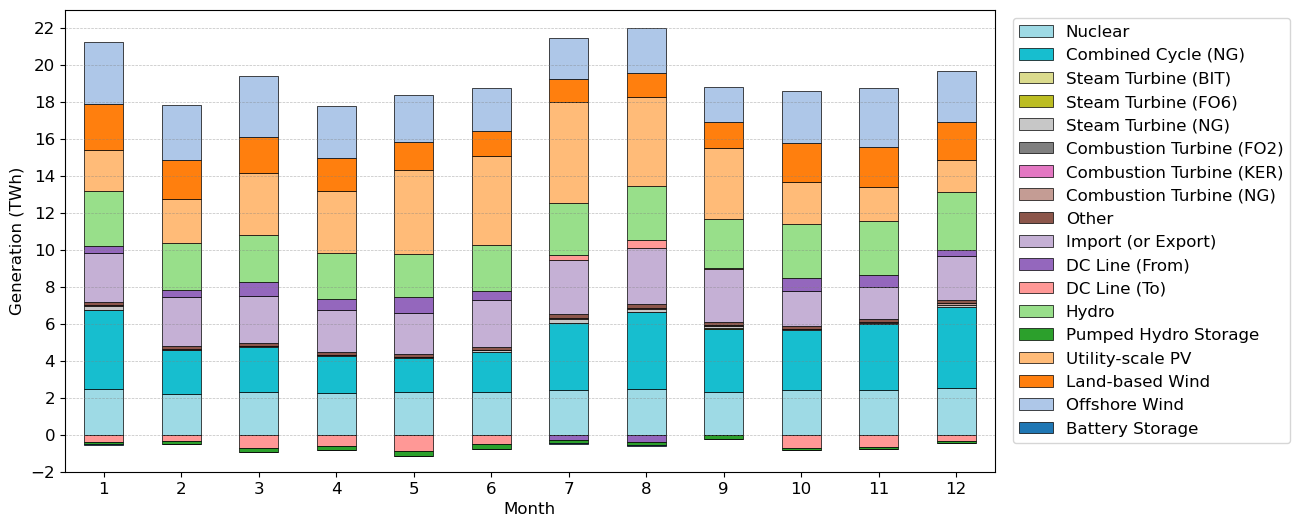

In [72]:
# D.1.
fig, ax = plt.subplots(figsize=(12, 6))
pg_by_fuel_sum_by_month_2030StateScenario_FewerESR.plot(ax=ax, kind='bar', stacked=True, figsize=(12, 6),
                            colormap='tab20_r', edgecolor='black', linewidth=0.5)
ax.set_xlabel('Month', fontsize=12)
ax.set_ylabel('Generation (TWh)', fontsize=12)
ax.legend(bbox_to_anchor=(1.01, 1), loc='upper left',
          fontsize=12)
ax.tick_params(axis='x', rotation=0)
ax.tick_params(axis='both', labelsize=12)
ax.set_ylim(-2, 23)
ax.set_yticks(np.arange(-2, 23, 2))
ax.grid(axis='y', color='gray', lw=0.5, ls='--', alpha=0.5)
fig.savefig(os.path.join(fig_dir, 
                         'pg_by_fuel_sum_by_month_2030StateScenario_FewerESR.png'), 
            bbox_inches='tight')
plt.show()

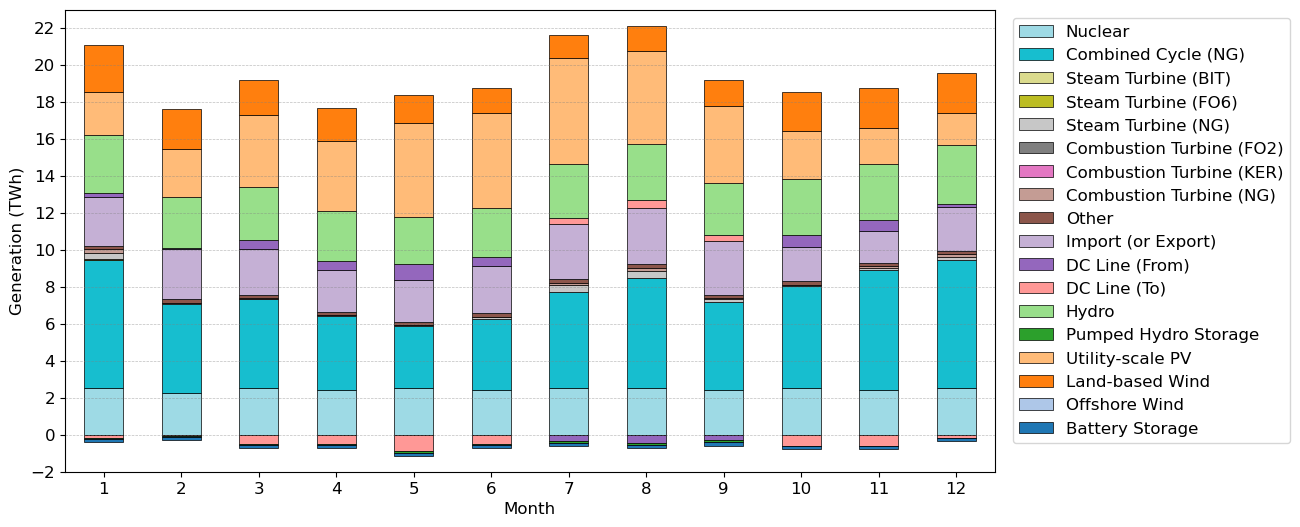

In [73]:
# D.2.
fig, ax = plt.subplots(figsize=(12, 6))
pg_by_fuel_sum_by_month_2030StateScenario_FewerOSW.plot(ax=ax, kind='bar', stacked=True, figsize=(12, 6),
                            colormap='tab20_r', edgecolor='black', linewidth=0.5)
ax.set_xlabel('Month', fontsize=12)
ax.set_ylabel('Generation (TWh)', fontsize=12)
ax.legend(bbox_to_anchor=(1.01, 1), loc='upper left',
          fontsize=12)
ax.tick_params(axis='x', rotation=0)
ax.tick_params(axis='both', labelsize=12)
ax.set_ylim(-2, 23)
ax.set_yticks(np.arange(-2, 23, 2))
ax.grid(axis='y', color='gray', lw=0.5, ls='--', alpha=0.5)
fig.savefig(os.path.join(fig_dir, 
                         'pg_by_fuel_sum_by_month_2030StateScenario_FewerOSW.png'), 
            bbox_inches='tight')
plt.show()

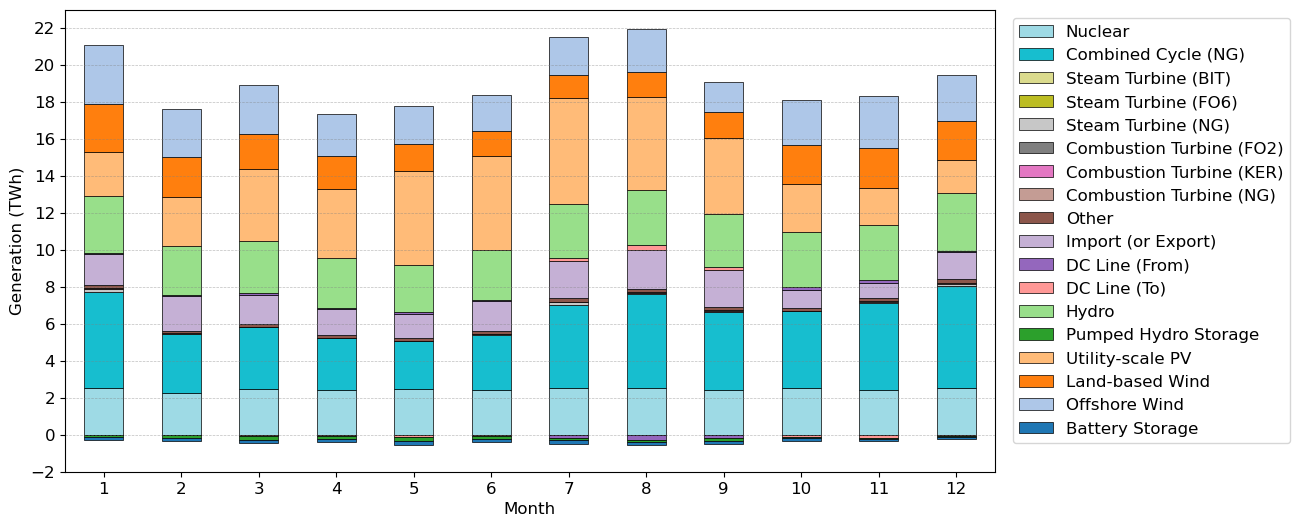

In [74]:
# D.3.
fig, ax = plt.subplots(figsize=(12, 6))
pg_by_fuel_sum_by_month_2030StateScenario_NoTxUpgrade.plot(ax=ax, kind='bar', stacked=True, figsize=(12, 6),
                            colormap='tab20_r', edgecolor='black', linewidth=0.5)
ax.set_xlabel('Month', fontsize=12)
ax.set_ylabel('Generation (TWh)', fontsize=12)
ax.legend(bbox_to_anchor=(1.01, 1), loc='upper left',
          fontsize=12)
ax.tick_params(axis='x', rotation=0)
ax.tick_params(axis='both', labelsize=12)
ax.set_ylim(-2, 23)
ax.set_yticks(np.arange(-2, 23, 2))
ax.grid(axis='y', color='gray', lw=0.5, ls='--', alpha=0.5)
fig.savefig(os.path.join(fig_dir, 
                         'pg_by_fuel_sum_by_month_2030StateScenario_NoTxUpgrade.png'), 
            bbox_inches='tight')
plt.show()

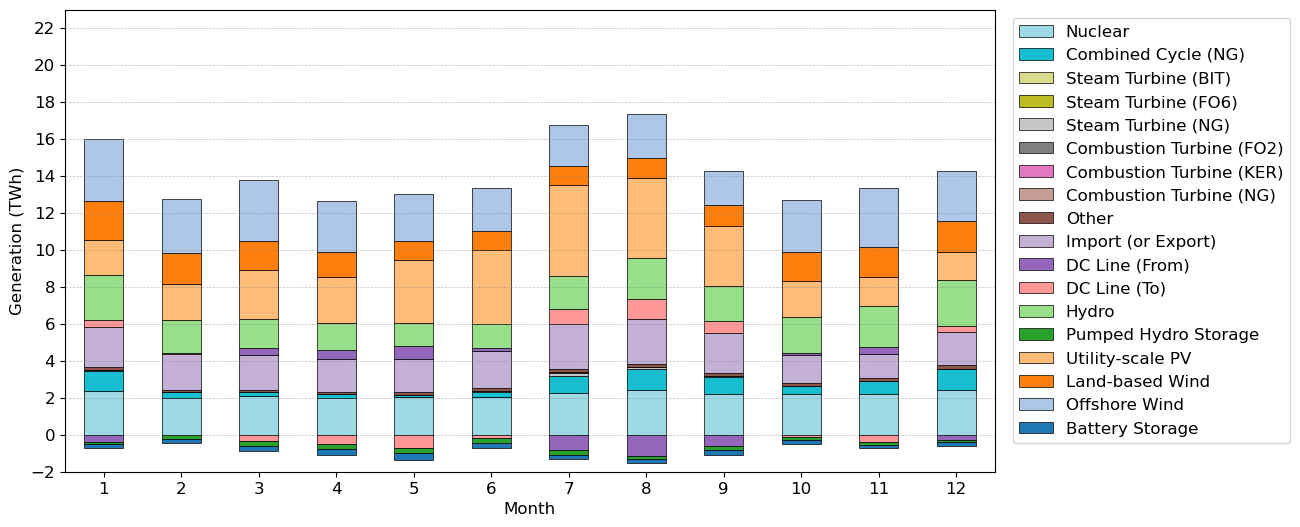

In [75]:
# D.4.
fig, ax = plt.subplots(figsize=(12, 6))
pg_by_fuel_sum_by_month_2030StateScenario_NoLargeLoad.plot(ax=ax, kind='bar', stacked=True, figsize=(12, 6),
                            colormap='tab20_r', edgecolor='black', linewidth=0.5)
ax.set_xlabel('Month', fontsize=12)
ax.set_ylabel('Generation (TWh)', fontsize=12)
ax.legend(bbox_to_anchor=(1.01, 1), loc='upper left',
          fontsize=12)
ax.tick_params(axis='x', rotation=0)
ax.tick_params(axis='both', labelsize=12)
ax.set_ylim(-2, 23)
ax.set_yticks(np.arange(-2, 23, 2))
ax.grid(axis='y', color='gray', lw=0.5, ls='--', alpha=0.5)
fig.savefig(os.path.join(fig_dir, 
                         'pg_by_fuel_sum_by_month_2030StateScenario_NoLargeLoad.png'), 
            bbox_inches='tight')
plt.show()

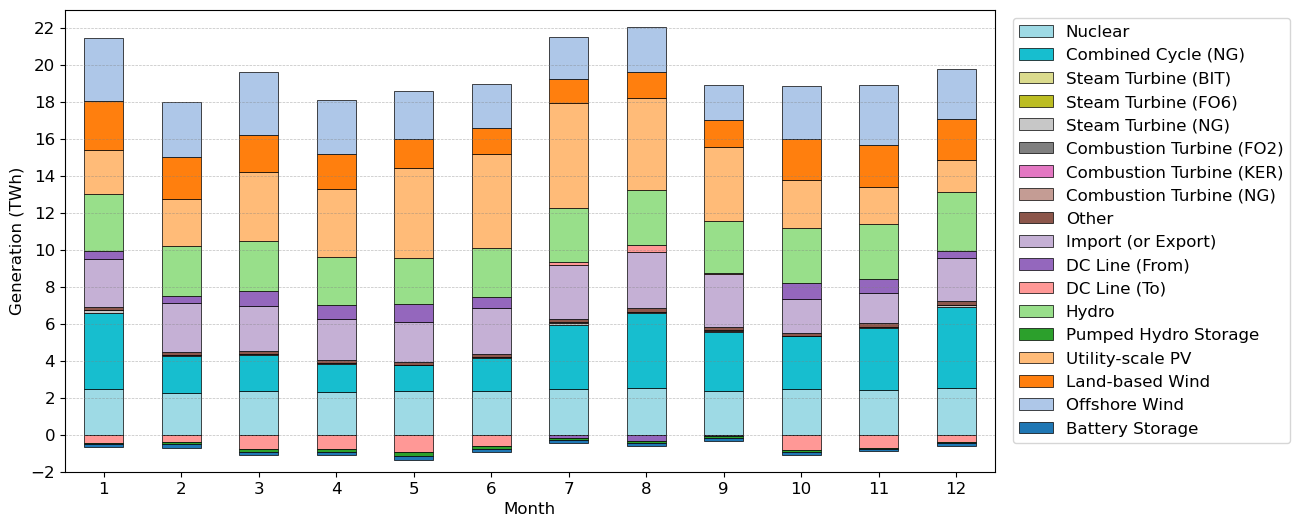

In [76]:
# D.5.
fig, ax = plt.subplots(figsize=(12, 6))
pg_by_fuel_sum_by_month_2030StateScenario_AvgRenew.plot(ax=ax, kind='bar', stacked=True, figsize=(12, 6),
                            colormap='tab20_r', edgecolor='black', linewidth=0.5)
ax.set_xlabel('Month', fontsize=12)
ax.set_ylabel('Generation (TWh)', fontsize=12)
ax.legend(bbox_to_anchor=(1.01, 1), loc='upper left',
          fontsize=12)
ax.tick_params(axis='x', rotation=0)
ax.tick_params(axis='both', labelsize=12)
ax.set_ylim(-2, 23)
ax.set_yticks(np.arange(-2, 23, 2))
ax.grid(axis='y', color='gray', lw=0.5, ls='--', alpha=0.5)
fig.savefig(os.path.join(fig_dir, 
                         'pg_by_fuel_sum_by_month_2030StateScenario_AvgRenew.png'), 
            bbox_inches='tight')
plt.show()

In [77]:
pg_by_fuel_sum_2018NewParams = pg_by_fuel_sum_by_month_2018NewParams.sum(axis=0)

pg_by_fuel_sum_2030BaselineCase = pg_by_fuel_sum_by_month_2030BaselineCase.sum(axis=0)
pg_by_fuel_sum_2030BaselineCase_NoLargeLoad = pg_by_fuel_sum_by_month_2030BaselineCase_NoLargeLoad.sum(axis=0)

pg_by_fuel_sum_2030ContractCase = pg_by_fuel_sum_by_month_2030ContractCase.sum(axis=0)
pg_by_fuel_sum_2030ContractCase_NoLargeLoad = pg_by_fuel_sum_by_month_2030ContractCase_NoLargeLoad.sum(axis=0)

pg_by_fuel_sum_2030StateScenario = pg_by_fuel_sum_by_month_2030StateScenario.sum(axis=0)
pg_by_fuel_sum_2030StateScenario_FewerESR = pg_by_fuel_sum_by_month_2030StateScenario_FewerESR.sum(axis=0)
pg_by_fuel_sum_2030StateScenario_FewerOSW = pg_by_fuel_sum_by_month_2030StateScenario_FewerOSW.sum(axis=0)
pg_by_fuel_sum_2030StateScenario_NoTxUpgrade = pg_by_fuel_sum_by_month_2030StateScenario_NoTxUpgrade.sum(axis=0)
pg_by_fuel_sum_2030StateScenario_NoLargeLoad = pg_by_fuel_sum_by_month_2030StateScenario_NoLargeLoad.sum(axis=0)
pg_by_fuel_sum_2030StateScenario_AvgRenew = pg_by_fuel_sum_by_month_2030StateScenario_AvgRenew.sum(axis=0)

pg_by_fuel_sum_summary = pd.DataFrame({
    '2018\nNew\nParams': pg_by_fuel_sum_2018NewParams,
    '2030\nBaseline\nCase': pg_by_fuel_sum_2030BaselineCase,
    '2030\nBaseline\nCase\nNoLargeLoad': pg_by_fuel_sum_2030BaselineCase_NoLargeLoad,
    '2030\nContract\nCase': pg_by_fuel_sum_2030ContractCase,
    '2030\nContract\nCase\nNoLargeLoad': pg_by_fuel_sum_2030ContractCase_NoLargeLoad,
    '2030\nState\nScenario': pg_by_fuel_sum_2030StateScenario,
    '2030\nState\nScenario\nFewerESR': pg_by_fuel_sum_2030StateScenario_FewerESR,
    '2030\nState\nScenario\nNoOSW': pg_by_fuel_sum_2030StateScenario_FewerOSW,
    '2030\nState\nScenario\nNoTxUpgrade': pg_by_fuel_sum_2030StateScenario_NoTxUpgrade,
    '2030\nState\nScenario\nNoLargeLoad': pg_by_fuel_sum_2030StateScenario_NoLargeLoad,
    # '2030\nState\nScenario\nAvgRenew': pg_by_fuel_sum_2030StateScenario_AvgRenew,
})

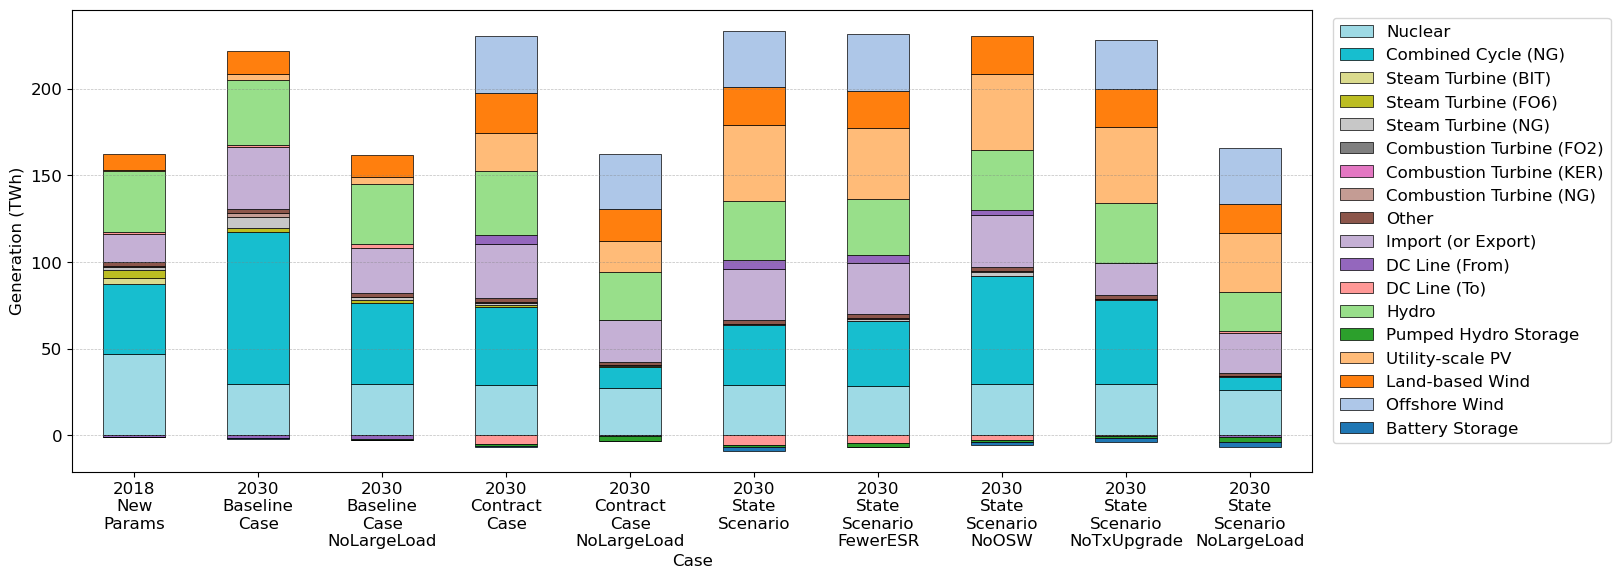

In [78]:
fig, ax = plt.subplots(figsize=(16, 6))
pg_by_fuel_sum_summary.T.plot(ax=ax, kind='bar', stacked=True,
                            colormap='tab20_r', edgecolor='black', linewidth=0.5)
ax.set_xlabel('Case', fontsize=12)
ax.set_ylabel('Generation (TWh)', fontsize=12)
ax.legend(bbox_to_anchor=(1.01, 1), loc='upper left',
          fontsize=12)
ax.tick_params(axis='x', rotation=0)
ax.tick_params(axis='both', labelsize=12)
# ax.set_ylim(-2, 23)
# ax.set_yticks(np.arange(-2, 23, 2))
ax.grid(axis='y', color='gray', lw=0.5, ls='--', alpha=0.5)
fig.savefig(os.path.join(fig_dir, 
                         'pg_by_fuel_sum_summary.png'), 
            bbox_inches='tight')
plt.show()

### 3. Renewable curtailment

In [79]:
def calc_curtail_by_zone_by_month(pg_by_fuel_dict,
                                  grid_prop,
                                  grid_profile,
                                  gen_fuel_name,
                                  zone_order):
    
    # Change HQ import zone from 'D' and 'J' to 'HQ'
    gen_prop = grid_prop['gen_prop'].copy()
    hq_idx = gen_prop[(gen_prop['GEN_ZONE'].isin(['D','J'])) & (gen_prop['UNIT_TYPE'] == 'Import')].index
    gen_prop.loc[hq_idx, 'GEN_ZONE'] = 'HQ'

    gen2zone_dict = gen_prop.set_index('GEN_NAME')[
        'GEN_ZONE'].to_dict()
    
    if gen_fuel_name == 'Load_Load':
        # Large Load curtailment (as negative generation)
        gen_index = grid_prop["gen_fuel"]["GEN_FUEL"].isin([gen_fuel_name]).to_numpy()
        gen_max_profile = grid_profile['genmin_profile'].loc[:, gen_index] * -1
        gen_profile = pg_by_fuel_dict[gen_fuel_name] * -1

    else:
        # Maximum available UPV generation
        gen_index = grid_prop["gen_fuel"]["GEN_FUEL"].isin([gen_fuel_name]).to_numpy()
        gen_max_profile = grid_profile['genmax_profile'].loc[:, gen_index]
        gen_profile = pg_by_fuel_dict[gen_fuel_name]

    # Aggregate UPV available generation by zone
    gen_max_zone = gen_max_profile.groupby(
        [gen2zone_dict], axis=1).sum()

    # Aggregate by month
    gen_max_zone_month = gen_max_zone.groupby(
        gen_max_zone.index.month).sum()

    # Calculate UPV curtailment
    gen_curtailment = gen_max_profile - gen_profile

    # Remove negative curtailment
    gen_curtailment[gen_curtailment < 0] = 0

    # Aggregate UPV curtailment by zone
    gen_curtailment_zone = gen_curtailment.groupby(
        [gen2zone_dict], axis=1).sum()

    # Aggregate by month
    gen_curtailment_zone_month = gen_curtailment_zone.groupby(
        gen_curtailment_zone.index.month).sum()

    # Calculate curtailment percentage
    gen_curtailment_pct_zone_month = gen_curtailment_zone_month / gen_max_zone_month * 100

    # Convert to GWh
    gen_curtailment_zone_month = gen_curtailment_zone_month

    # Add missing zones
    for zone in zone_order[:11]:
        if zone not in gen_curtailment_zone_month.columns:
            gen_curtailment_zone_month[zone] = np.nan
            gen_curtailment_pct_zone_month[zone] = np.nan

    # Reorder columns
    gen_curtailment_zone_month = gen_curtailment_zone_month[zone_order[:11]]
    gen_curtailment_pct_zone_month = gen_curtailment_pct_zone_month[zone_order[:11]]

    return (gen_curtailment_zone_month, 
            gen_max_zone_month, 
            gen_curtailment_pct_zone_month)

In [80]:
# A.
upv_curtailment_zone_month_2018NewParams, \
upv_max_zone_month_2018NewParams, \
    upv_curtailment_pct_zone_month_2018NewParams = calc_curtail_by_zone_by_month(
    pg_by_fuel_dict_2018NewParams,
    grid_prop_2018NewParams,
    grid_profile_2018NewParams,
    'PV_SUN',
    zone_order)

# B.0.
upv_curtailment_zone_month_2030BaselineCase, \
    upv_max_zone_month_2030BaselineCase, \
    upv_curtailment_pct_zone_month_2030BaselineCase = calc_curtail_by_zone_by_month(
    pg_by_fuel_dict_2030BaselineCase,
    grid_prop_2030BaselineCase,
    grid_profile_2030BaselineCase,
    'PV_SUN',
    zone_order)

# B.1.
upv_curtailment_zone_month_2030BaselineCase_NoLargeLoad, \
    upv_max_zone_month_2030BaselineCase_NoLargeLoad, \
    upv_curtailment_pct_zone_month_2030BaselineCase_NoLargeLoad = calc_curtail_by_zone_by_month(
    pg_by_fuel_dict_2030BaselineCase_NoLargeLoad,
    grid_prop_2030BaselineCase_NoLargeLoad,
    grid_profile_2030BaselineCase_NoLargeLoad,
    'PV_SUN',
    zone_order)

# C.0.
upv_curtailment_zone_month_2030ContractCase, \
    upv_max_zone_month_2030ContractCase, \
    upv_curtailment_pct_zone_month_2030ContractCase = calc_curtail_by_zone_by_month(
    pg_by_fuel_dict_2030ContractCase,
    grid_prop_2030ContractCase,
    grid_profile_2030ContractCase,
    'PV_SUN',
    zone_order)

# C.1.
upv_curtailment_zone_month_2030ContractCase_NoLargeLoad, \
    upv_max_zone_month_2030ContractCase_NoLargeLoad, \
    upv_curtailment_pct_zone_month_2030ContractCase_NoLargeLoad = calc_curtail_by_zone_by_month(
    pg_by_fuel_dict_2030ContractCase_NoLargeLoad,
    grid_prop_2030ContractCase_NoLargeLoad,
    grid_profile_2030ContractCase_NoLargeLoad,
    'PV_SUN',
    zone_order)

# D.0.
upv_curtailment_zone_month_2030StateScenario, \
    upv_max_zone_month_2030StateScenario, \
    upv_curtailment_pct_zone_month_2030StateScenario = calc_curtail_by_zone_by_month(
    pg_by_fuel_dict_2030StateScenario,
    grid_prop_2030StateScenario,
    grid_profile_2030StateScenario,
    'PV_SUN',
    zone_order)

# D.1.
upv_curtailment_zone_month_2030StateScenario_FewerESR, \
    upv_max_zone_month_2030StateScenario_FewerESR, \
    upv_curtailment_pct_zone_month_2030StateScenario_FewerESR = calc_curtail_by_zone_by_month(
    pg_by_fuel_dict_2030StateScenario_FewerESR,
    grid_prop_2030StateScenario_FewerESR,
    grid_profile_2030StateScenario_FewerESR,
    'PV_SUN',
    zone_order)

# D.2.
upv_curtailment_zone_month_2030StateScenario_FewerOSW, \
    upv_max_zone_month_2030StateScenario_FewerOSW, \
    upv_curtailment_pct_zone_month_2030StateScenario_FewerOSW = calc_curtail_by_zone_by_month(
    pg_by_fuel_dict_2030StateScenario_FewerOSW,
    grid_prop_2030StateScenario_FewerOSW,
    grid_profile_2030StateScenario_FewerOSW,
    'PV_SUN',
    zone_order)

# D.3.
upv_curtailment_zone_month_2030StateScenario_NoTxUpgrade, \
    upv_max_zone_month_2030StateScenario_NoTxUpgrade, \
    upv_curtailment_pct_zone_month_2030StateScenario_NoTxUpgrade = calc_curtail_by_zone_by_month(
    pg_by_fuel_dict_2030StateScenario_NoTxUpgrade,
    grid_prop_2030StateScenario_NoTxUpgrade,
    grid_profile_2030StateScenario_NoTxUpgrade,
    'PV_SUN',
    zone_order)

# D.4.
upv_curtailment_zone_month_2030StateScenario_NoLargeLoad, \
    upv_max_zone_month_2030StateScenario_NoLargeLoad, \
    upv_curtailment_pct_zone_month_2030StateScenario_NoLargeLoad = calc_curtail_by_zone_by_month(
    pg_by_fuel_dict_2030StateScenario_NoLargeLoad,
    grid_prop_2030StateScenario_NoLargeLoad,
    grid_profile_2030StateScenario_NoLargeLoad,
    'PV_SUN',
    zone_order)

# D.5.
upv_curtailment_zone_month_2030StateScenario_AvgRenew, \
    upv_max_zone_month_2030StateScenario_AvgRenew, \
    upv_curtailment_pct_zone_month_2030StateScenario_AvgRenew = calc_curtail_by_zone_by_month(
    pg_by_fuel_dict_2030StateScenario_AvgRenew,
    grid_prop_2030StateScenario_AvgRenew,
    grid_profile_2030StateScenario_AvgRenew,
    'PV_SUN',
    zone_order)

In [81]:
# A.
wind_curtailment_zone_month_2018NewParams, \
    wind_max_zone_month_2018NewParams, \
    wind_curtailment_pct_zone_month_2018NewParams = calc_curtail_by_zone_by_month(
    pg_by_fuel_dict_2018NewParams,
    grid_prop_2018NewParams,
    grid_profile_2018NewParams,
    'WT_WND',
    zone_order)

# B.0.
wind_curtailment_zone_month_2030BaselineCase, \
    wind_max_zone_month_2030BaselineCase, \
    wind_curtailment_pct_zone_month_2030BaselineCase = calc_curtail_by_zone_by_month(
    pg_by_fuel_dict_2030BaselineCase,
    grid_prop_2030BaselineCase,
    grid_profile_2030BaselineCase,
    'WT_WND',
    zone_order)

# B.1.
wind_curtailment_zone_month_2030BaselineCase_NoLargeLoad, \
    wind_max_zone_month_2030BaselineCase_NoLargeLoad, \
    wind_curtailment_pct_zone_month_2030BaselineCase_NoLargeLoad = calc_curtail_by_zone_by_month(
    pg_by_fuel_dict_2030BaselineCase_NoLargeLoad,
    grid_prop_2030BaselineCase_NoLargeLoad,
    grid_profile_2030BaselineCase_NoLargeLoad,
    'WT_WND',
    zone_order)

# C.0.
wind_curtailment_zone_month_2030ContractCase, \
    wind_max_zone_month_2030ContractCase, \
    wind_curtailment_pct_zone_month_2030ContractCase = calc_curtail_by_zone_by_month(
    pg_by_fuel_dict_2030ContractCase,
    grid_prop_2030ContractCase,
    grid_profile_2030ContractCase,
    'WT_WND',
    zone_order)

# C.1.
wind_curtailment_zone_month_2030ContractCase_NoLargeLoad, \
    wind_max_zone_month_2030ContractCase_NoLargeLoad, \
    wind_curtailment_pct_zone_month_2030ContractCase_NoLargeLoad = calc_curtail_by_zone_by_month(
    pg_by_fuel_dict_2030ContractCase_NoLargeLoad,
    grid_prop_2030ContractCase_NoLargeLoad,
    grid_profile_2030ContractCase_NoLargeLoad,
    'WT_WND',
    zone_order)

# D.0.
wind_curtailment_zone_month_2030StateScenario, \
    wind_max_zone_month_2030StateScenario, \
    wind_curtailment_pct_zone_month_2030StateScenario = calc_curtail_by_zone_by_month(
    pg_by_fuel_dict_2030StateScenario,
    grid_prop_2030StateScenario,
    grid_profile_2030StateScenario,
    'WT_WND',
    zone_order)

# D.1.
wind_curtailment_zone_month_2030StateScenario_FewerESR, \
    wind_max_zone_month_2030StateScenario_FewerESR, \
    wind_curtailment_pct_zone_month_2030StateScenario_FewerESR = calc_curtail_by_zone_by_month(
    pg_by_fuel_dict_2030StateScenario_FewerESR,
    grid_prop_2030StateScenario_FewerESR,
    grid_profile_2030StateScenario_FewerESR,
    'WT_WND',
    zone_order)

# D.2.
wind_curtailment_zone_month_2030StateScenario_FewerOSW, \
    wind_max_zone_month_2030StateScenario_FewerOSW, \
    wind_curtailment_pct_zone_month_2030StateScenario_FewerOSW = calc_curtail_by_zone_by_month(
    pg_by_fuel_dict_2030StateScenario_FewerOSW,
    grid_prop_2030StateScenario_FewerOSW,
    grid_profile_2030StateScenario_FewerOSW,
    'WT_WND',
    zone_order)

# D.3.
wind_curtailment_zone_month_2030StateScenario_NoTxUpgrade, \
    wind_max_zone_month_2030StateScenario_NoTxUpgrade, \
    wind_curtailment_pct_zone_month_2030StateScenario_NoTxUpgrade = calc_curtail_by_zone_by_month(
    pg_by_fuel_dict_2030StateScenario_NoTxUpgrade,
    grid_prop_2030StateScenario_NoTxUpgrade,
    grid_profile_2030StateScenario_NoTxUpgrade,
    'WT_WND',
    zone_order)

# D.4.
wind_curtailment_zone_month_2030StateScenario_NoLargeLoad, \
    wind_max_zone_month_2030StateScenario_NoLargeLoad, \
    wind_curtailment_pct_zone_month_2030StateScenario_NoLargeLoad = calc_curtail_by_zone_by_month(
    pg_by_fuel_dict_2030StateScenario_NoLargeLoad,
    grid_prop_2030StateScenario_NoLargeLoad,
    grid_profile_2030StateScenario_NoLargeLoad,
    'WT_WND',
    zone_order)

# D.5.
wind_curtailment_zone_month_2030StateScenario_AvgRenew, \
    wind_max_zone_month_2030StateScenario_AvgRenew, \
    wind_curtailment_pct_zone_month_2030StateScenario_AvgRenew = calc_curtail_by_zone_by_month(
    pg_by_fuel_dict_2030StateScenario_AvgRenew,
    grid_prop_2030StateScenario_AvgRenew,
    grid_profile_2030StateScenario_AvgRenew,
    'WT_WND',
    zone_order)

In [82]:
# B.0.
load_curtailment_zone_month_2030BaselineCase, \
    load_max_zone_month_2030BaselineCase, \
    load_curtailment_pct_zone_month_2030BaselineCase = calc_curtail_by_zone_by_month(
    pg_by_fuel_dict_2030BaselineCase,
    grid_prop_2030BaselineCase,
    grid_profile_2030BaselineCase,
    'Load_Load',
    zone_order)

# C.0.
load_curtailment_zone_month_2030ContractCase, \
    load_max_zone_month_2030ContractCase, \
    load_curtailment_pct_zone_month_2030ContractCase = calc_curtail_by_zone_by_month(
    pg_by_fuel_dict_2030ContractCase,
    grid_prop_2030ContractCase,
    grid_profile_2030ContractCase,
    'Load_Load',
    zone_order)

# D.0.
load_curtailment_zone_month_2030StateScenario, \
    load_max_zone_month_2030StateScenario, \
    load_curtailment_pct_zone_month_2030StateScenario = calc_curtail_by_zone_by_month(
    pg_by_fuel_dict_2030StateScenario,
    grid_prop_2030StateScenario,
    grid_profile_2030StateScenario,
    'Load_Load',
    zone_order)

# D.1.
load_curtailment_zone_month_2030StateScenario_FewerESR, \
    load_max_zone_month_2030StateScenario_FewerESR, \
    load_curtailment_pct_zone_month_2030StateScenario_FewerESR = calc_curtail_by_zone_by_month(
    pg_by_fuel_dict_2030StateScenario_FewerESR,
    grid_prop_2030StateScenario_FewerESR,
    grid_profile_2030StateScenario_FewerESR,
    'Load_Load',
    zone_order)

# D.2.
load_curtailment_zone_month_2030StateScenario_FewerOSW, \
    load_max_zone_month_2030StateScenario_FewerOSW, \
    load_curtailment_pct_zone_month_2030StateScenario_FewerOSW = calc_curtail_by_zone_by_month(
    pg_by_fuel_dict_2030StateScenario_FewerOSW,
    grid_prop_2030StateScenario_FewerOSW,
    grid_profile_2030StateScenario_FewerOSW,
    'Load_Load',
    zone_order)

# D.3.
load_curtailment_zone_month_2030StateScenario_NoTxUpgrade, \
    load_max_zone_month_2030StateScenario_NoTxUpgrade, \
    load_curtailment_pct_zone_month_2030StateScenario_NoTxUpgrade = calc_curtail_by_zone_by_month(
    pg_by_fuel_dict_2030StateScenario_NoTxUpgrade,
    grid_prop_2030StateScenario_NoTxUpgrade,
    grid_profile_2030StateScenario_NoTxUpgrade,
    'Load_Load',
    zone_order)

# D.5.
load_curtailment_zone_month_2030StateScenario_AvgRenew, \
    load_max_zone_month_2030StateScenario_AvgRenew, \
    load_curtailment_pct_zone_month_2030StateScenario_AvgRenew = calc_curtail_by_zone_by_month(
    pg_by_fuel_dict_2030StateScenario_AvgRenew,
    grid_prop_2030StateScenario_AvgRenew,
    grid_profile_2030StateScenario_AvgRenew,
    'Load_Load',
    zone_order)

In [83]:
upv_curtailment_pct_zone_2018NewParams = \
    upv_curtailment_zone_month_2018NewParams.sum(axis=0) \
    /upv_max_zone_month_2018NewParams.sum(axis=0) * 100

upv_curtailment_pct_zone_2030BaselineCase = \
    upv_curtailment_zone_month_2030BaselineCase.sum(axis=0) \
    /upv_max_zone_month_2030BaselineCase.sum(axis=0) * 100

upv_curtailment_pct_zone_2030BaselineCase_NoLargeLoad = \
    upv_curtailment_zone_month_2030BaselineCase_NoLargeLoad.sum(axis=0) \
    /upv_max_zone_month_2030BaselineCase_NoLargeLoad.sum(axis=0) * 100

upv_curtailment_pct_zone_2030ContractCase = \
    upv_curtailment_zone_month_2030ContractCase.sum(axis=0) \
    /upv_max_zone_month_2030ContractCase.sum(axis=0) * 100

upv_curtailment_pct_zone_2030ContractCase_NoLargeLoad = \
    upv_curtailment_zone_month_2030ContractCase_NoLargeLoad.sum(axis=0) \
    /upv_max_zone_month_2030ContractCase_NoLargeLoad.sum(axis=0) * 100

upv_curtailment_pct_zone_2030StateScenario = \
    upv_curtailment_zone_month_2030StateScenario.sum(axis=0) \
    /upv_max_zone_month_2030StateScenario.sum(axis=0) * 100

upv_curtailment_pct_zone_2030StateScenario_FewerESR = \
    upv_curtailment_zone_month_2030StateScenario_FewerESR.sum(axis=0) \
    /upv_max_zone_month_2030StateScenario_FewerESR.sum(axis=0) * 100

upv_curtailment_pct_zone_2030StateScenario_FewerOSW = \
    upv_curtailment_zone_month_2030StateScenario_FewerOSW.sum(axis=0) \
    /upv_max_zone_month_2030StateScenario_FewerOSW.sum(axis=0) * 100

upv_curtailment_pct_zone_2030StateScenario_NoTxUpgrade = \
    upv_curtailment_zone_month_2030StateScenario_NoTxUpgrade.sum(axis=0) \
    /upv_max_zone_month_2030StateScenario_NoTxUpgrade.sum(axis=0) * 100

upv_curtailment_pct_zone_2030StateScenario_NoLargeLoad = \
    upv_curtailment_zone_month_2030StateScenario_NoLargeLoad.sum(axis=0) \
    /upv_max_zone_month_2030StateScenario_NoLargeLoad.sum(axis=0) * 100

upv_curtailment_pct_zone_2030StateScenario_AvgRenew = \
    upv_curtailment_zone_month_2030StateScenario_AvgRenew.sum(axis=0) \
    /upv_max_zone_month_2030StateScenario_AvgRenew.sum(axis=0) * 100

In [84]:
upv_curtailment_pct_zone_summary = pd.DataFrame({
    '2018\nNew\nParams': upv_curtailment_pct_zone_2018NewParams,
    '2030\nBaseline\nCase': upv_curtailment_pct_zone_2030BaselineCase,
    '2030\nBaseline\nCase\nNoLargeLoad': upv_curtailment_pct_zone_2030BaselineCase_NoLargeLoad,
    '2030\nContract\nCase': upv_curtailment_pct_zone_2030ContractCase,
    '2030\nContract\nCase\nNoLargeLoad': upv_curtailment_pct_zone_2030ContractCase_NoLargeLoad,
    '2030\nState\nScenario': upv_curtailment_pct_zone_2030StateScenario,
    '2030\nState\nScenario\nFewerESR': upv_curtailment_pct_zone_2030StateScenario_FewerESR,
    '2030\nState\nScenario\nNoOSW': upv_curtailment_pct_zone_2030StateScenario_FewerOSW,
    '2030\nState\nScenario\nNoTxUpgrade': upv_curtailment_pct_zone_2030StateScenario_NoTxUpgrade,
    '2030\nState\nScenario\nNoLargeLoad': upv_curtailment_pct_zone_2030StateScenario_NoLargeLoad,
    # '2030\nState\nScenario\nAvgRenew': upv_curtailment_pct_zone_2030StateScenario_AvgRenew,
})

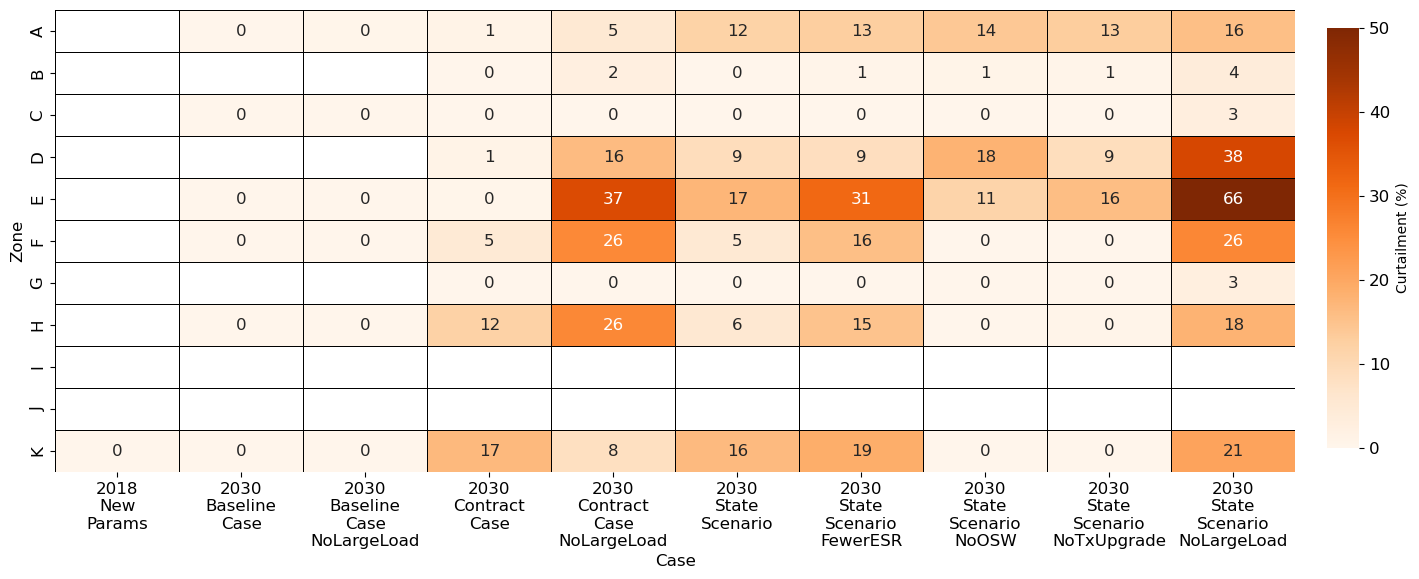

In [85]:
fig, ax = plt.subplots(figsize=(16, 6))
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
sns.heatmap(upv_curtailment_pct_zone_summary,
            ax=ax, cmap='Oranges',
            cbar_kws={'label': 'Curtailment (%)'},
            linewidths=0.5, linecolor='black',
            mask=upv_curtailment_pct_zone_summary.isnull(),
            annot=True, fmt=".0f", annot_kws={"size": 12},
            vmax=50, vmin=0, cbar_ax=cbar_ax)
ax.set_xlabel('Case', fontsize=12)
ax.set_ylabel('Zone', fontsize=12)
ax.tick_params(axis='both', labelsize=12)
cbar_ax.tick_params(axis='both', labelsize=12)
fig.savefig(os.path.join(fig_dir,
                         'upv_curtailment_pct_zone_summary.png'),
            bbox_inches='tight')

In [86]:
wind_curtailment_pct_zone_2018NewParams = \
    wind_curtailment_zone_month_2018NewParams.sum(axis=0) \
    /wind_max_zone_month_2018NewParams.sum(axis=0) * 100

wind_curtailment_pct_zone_2030BaselineCase = \
    wind_curtailment_zone_month_2030BaselineCase.sum(axis=0) \
    /wind_max_zone_month_2030BaselineCase.sum(axis=0) * 100

wind_curtailment_pct_zone_2030BaselineCase_NoLargeLoad = \
    wind_curtailment_zone_month_2030BaselineCase_NoLargeLoad.sum(axis=0) \
    /wind_max_zone_month_2030BaselineCase_NoLargeLoad.sum(axis=0) * 100

wind_curtailment_pct_zone_2030ContractCase = \
    wind_curtailment_zone_month_2030ContractCase.sum(axis=0) \
    /wind_max_zone_month_2030ContractCase.sum(axis=0) * 100

wind_curtailment_pct_zone_2030ContractCase_NoLargeLoad = \
    wind_curtailment_zone_month_2030ContractCase_NoLargeLoad.sum(axis=0) \
    /wind_max_zone_month_2030ContractCase_NoLargeLoad.sum(axis=0) * 100

wind_curtailment_pct_zone_2030StateScenario = \
    wind_curtailment_zone_month_2030StateScenario.sum(axis=0) \
    /wind_max_zone_month_2030StateScenario.sum(axis=0) * 100

wind_curtailment_pct_zone_2030StateScenario_FewerESR = \
    wind_curtailment_zone_month_2030StateScenario_FewerESR.sum(axis=0) \
    /wind_max_zone_month_2030StateScenario_FewerESR.sum(axis=0) * 100

wind_curtailment_pct_zone_2030StateScenario_FewerOSW = \
    wind_curtailment_zone_month_2030StateScenario_FewerOSW.sum(axis=0) \
    /wind_max_zone_month_2030StateScenario_FewerOSW.sum(axis=0) * 100

wind_curtailment_pct_zone_2030StateScenario_NoTxUpgrade = \
    wind_curtailment_zone_month_2030StateScenario_NoTxUpgrade.sum(axis=0) \
    /wind_max_zone_month_2030StateScenario_NoTxUpgrade.sum(axis=0) * 100

wind_curtailment_pct_zone_2030StateScenario_NoLargeLoad = \
    wind_curtailment_zone_month_2030StateScenario_NoLargeLoad.sum(axis=0) \
    /wind_max_zone_month_2030StateScenario_NoLargeLoad.sum(axis=0) * 100

wind_curtailment_pct_zone_2030StateScenario_AvgRenew = \
    wind_curtailment_zone_month_2030StateScenario_AvgRenew.sum(axis=0) \
    /wind_max_zone_month_2030StateScenario_AvgRenew.sum(axis=0) * 100

In [87]:
wind_curtailment_pct_zone_summary = pd.DataFrame({
    '2018\nNew\nParams': wind_curtailment_pct_zone_2018NewParams,
    '2030\nBaseline\nCase': wind_curtailment_pct_zone_2030BaselineCase,
    '2030\nBaseline\nCase\nNoLargeLoad': wind_curtailment_pct_zone_2030BaselineCase_NoLargeLoad,
    '2030\nContract\nCase': wind_curtailment_pct_zone_2030ContractCase,
    '2030\nContract\nCase\nNoLargeLoad': wind_curtailment_pct_zone_2030ContractCase_NoLargeLoad,
    '2030\nState\nScenario': wind_curtailment_pct_zone_2030StateScenario,
    '2030\nState\nScenario\nFewerESR': wind_curtailment_pct_zone_2030StateScenario_FewerESR,
    '2030\nState\nScenario\nNoOSW': wind_curtailment_pct_zone_2030StateScenario_FewerOSW,
    '2030\nState\nScenario\nNoTxUpgrade': wind_curtailment_pct_zone_2030StateScenario_NoTxUpgrade,
    '2030\nState\nScenario\nNoLargeLoad': wind_curtailment_pct_zone_2030StateScenario_NoLargeLoad,
    # '2030\nState\nScenario\nAvgRenew': wind_curtailment_pct_zone_2030StateScenario_AvgRenew,
})

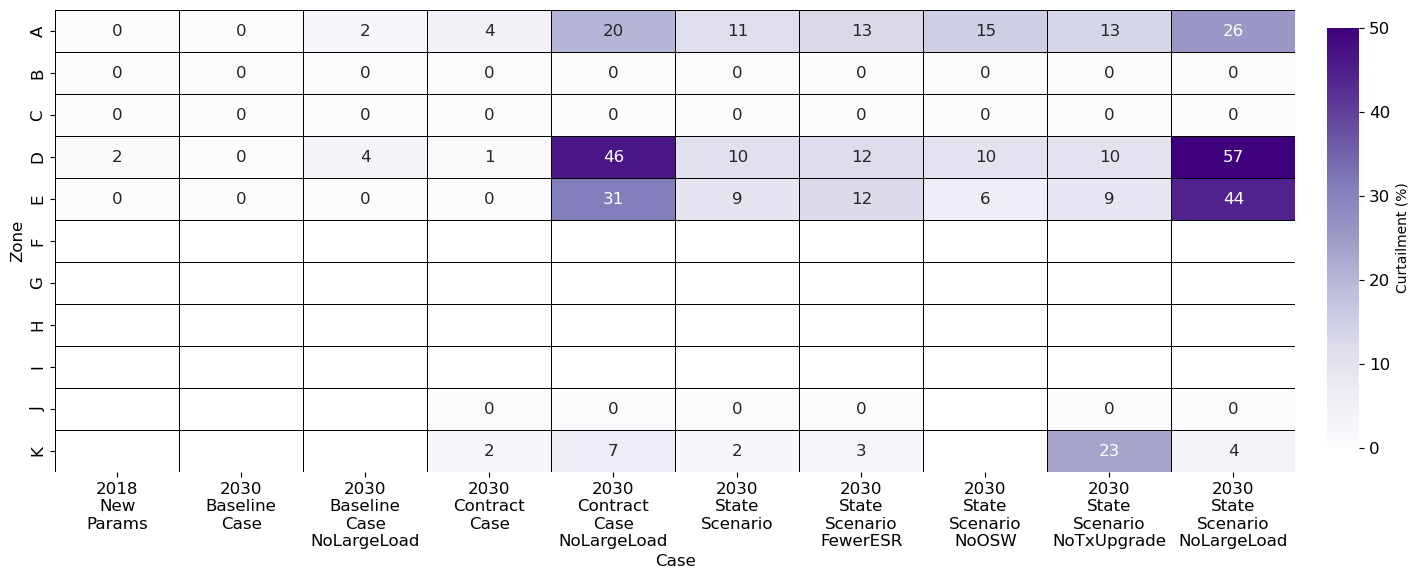

In [88]:
fig, ax = plt.subplots(figsize=(16, 6))
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
sns.heatmap(wind_curtailment_pct_zone_summary,
            ax=ax, cmap='Purples',
            cbar_kws={'label': 'Curtailment (%)'},
            linewidths=0.5, linecolor='black',
            mask=wind_curtailment_pct_zone_summary.isnull(),
            annot=True, fmt=".0f", annot_kws={"size": 12},
            vmax=50, vmin=0, cbar_ax=cbar_ax)
ax.set_xlabel('Case', fontsize=12)
ax.set_ylabel('Zone', fontsize=12)
ax.tick_params(axis='both', labelsize=12)
cbar_ax.tick_params(axis='both', labelsize=12)
fig.savefig(os.path.join(fig_dir,
                         'wind_curtailment_pct_zone_summary.png'),
            bbox_inches='tight')

In [89]:
load_curtailment_pct_zone_2030BaselineCase = \
    load_curtailment_zone_month_2030BaselineCase.sum(axis=0) \
    /load_max_zone_month_2030BaselineCase.sum(axis=0) * 100

load_curtailment_pct_zone_2030ContractCase = \
    load_curtailment_zone_month_2030ContractCase.sum(axis=0) \
    /load_max_zone_month_2030ContractCase.sum(axis=0) * 100

load_curtailment_pct_zone_2030StateScenario = \
    load_curtailment_zone_month_2030StateScenario.sum(axis=0) \
    /load_max_zone_month_2030StateScenario.sum(axis=0) * 100

load_curtailment_pct_zone_2030StateScenario_FewerESR = \
    load_curtailment_zone_month_2030StateScenario_FewerESR.sum(axis=0) \
    /load_max_zone_month_2030StateScenario_FewerESR.sum(axis=0) * 100

load_curtailment_pct_zone_2030StateScenario_FewerOSW = \
    load_curtailment_zone_month_2030StateScenario_FewerOSW.sum(axis=0) \
    /load_max_zone_month_2030StateScenario_FewerOSW.sum(axis=0) * 100

load_curtailment_pct_zone_2030StateScenario_NoTxUpgrade = \
    load_curtailment_zone_month_2030StateScenario_NoTxUpgrade.sum(axis=0) \
    /load_max_zone_month_2030StateScenario_NoTxUpgrade.sum(axis=0) * 100

load_curtailment_pct_zone_2030StateScenario_AvgRenew = \
    load_curtailment_zone_month_2030StateScenario_AvgRenew.sum(axis=0) \
    /load_max_zone_month_2030StateScenario_AvgRenew.sum(axis=0) * 100

In [90]:
load_curtailment_pct_zone_summary = pd.DataFrame({
    '2030\nBaseline\nCase': load_curtailment_pct_zone_2030BaselineCase,
    '2030\nContract\nCase': load_curtailment_pct_zone_2030ContractCase,
    '2030\nState\nScenario': load_curtailment_pct_zone_2030StateScenario,
    '2030\nState\nScenario\nFewerESR': load_curtailment_pct_zone_2030StateScenario_FewerESR,
    '2030\nState\nScenario\nNoOSW': load_curtailment_pct_zone_2030StateScenario_FewerOSW,
    '2030\nState\nScenario\nNoTxUpgrade': load_curtailment_pct_zone_2030StateScenario_NoTxUpgrade,
    # '2030\nState\nScenario\nAvgRenew': load_curtailment_pct_zone_2030StateScenario_AvgRenew,
})

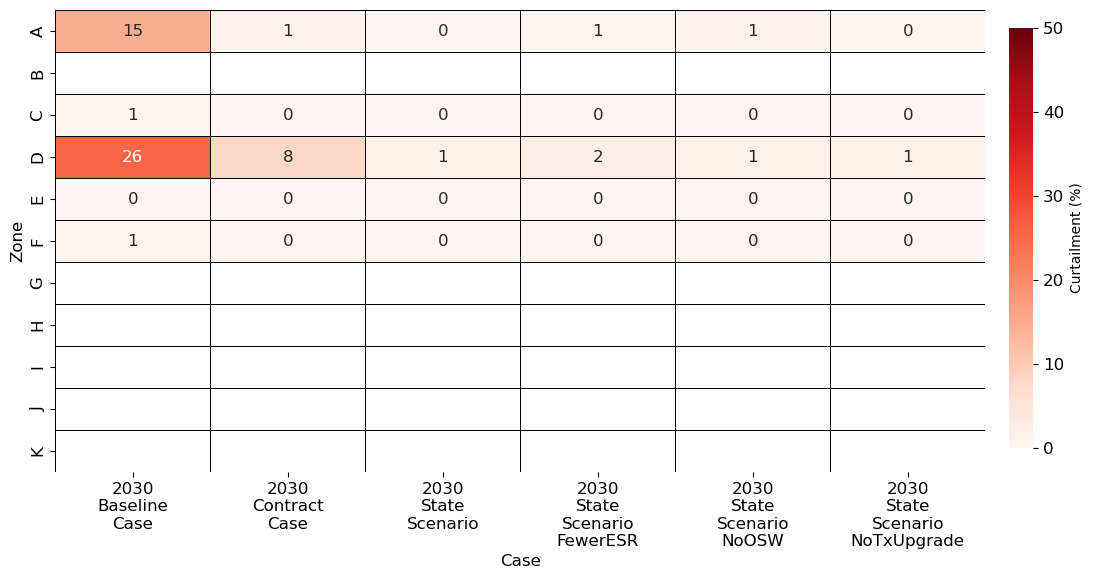

In [91]:
fig, ax = plt.subplots(figsize=(12, 6))
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
sns.heatmap(load_curtailment_pct_zone_summary,
            ax=ax, cmap='Reds',
            cbar_kws={'label': 'Curtailment (%)'},
            linewidths=0.5, linecolor='black',
            mask=load_curtailment_pct_zone_summary.isnull(),
            annot=True, fmt=".0f", annot_kws={"size": 12},
            vmax=50, vmin=0, cbar_ax=cbar_ax)
ax.set_xlabel('Case', fontsize=12)
ax.set_ylabel('Zone', fontsize=12)
ax.tick_params(axis='both', labelsize=12)
cbar_ax.tick_params(axis='both', labelsize=12)
fig.savefig(os.path.join(fig_dir,
                         'load_curtailment_pct_zone_summary.png'),
            bbox_inches='tight')

## Compare site-wise vs. average renewable profile

In [131]:
def calc_curtail_by_zone(pg_by_fuel_dict,
                         grid_prop,
                         grid_profile,
                         gen_fuel_name,
                         zone_order):

    # Change HQ import zone from 'D' and 'J' to 'HQ'
    gen_prop = grid_prop['gen_prop'].copy()
    hq_idx = gen_prop[(gen_prop['GEN_ZONE'].isin(['D', 'J']))
                      & (gen_prop['UNIT_TYPE'] == 'Import')].index
    gen_prop.loc[hq_idx, 'GEN_ZONE'] = 'HQ'

    gen2zone_dict = gen_prop.set_index('GEN_NAME')[
        'GEN_ZONE'].to_dict()

    if gen_fuel_name == 'Load_Load':
        # Large Load curtailment (as negative generation)
        gen_index = grid_prop["gen_fuel"]["GEN_FUEL"].isin(
            [gen_fuel_name]).to_numpy()
        gen_max_profile = grid_profile['genmin_profile'].loc[:, gen_index] * -1
        gen_profile = pg_by_fuel_dict[gen_fuel_name] * -1

    else:
        # Maximum available UPV generation
        gen_index = grid_prop["gen_fuel"]["GEN_FUEL"].isin(
            [gen_fuel_name]).to_numpy()
        gen_max_profile = grid_profile['genmax_profile'].loc[:, gen_index]
        gen_profile = pg_by_fuel_dict[gen_fuel_name]

    # Aggregate UPV available generation by zone
    gen_max_zone = gen_max_profile.groupby(
        [gen2zone_dict], axis=1).sum()
    
    # Aggregate UPV generation by zone
    gen_zone = gen_profile.groupby(
        [gen2zone_dict], axis=1).sum()

    # Calculate UPV curtailment
    gen_curtailment = gen_max_profile - gen_profile

    # Remove negative curtailment
    gen_curtailment[gen_curtailment < 0] = 0

    # Aggregate UPV curtailment by zone
    gen_curtailment_zone = gen_curtailment.groupby(
        [gen2zone_dict], axis=1).sum()

    # Calculate curtailment percentage
    gen_curtailment_pct_zone = gen_curtailment_zone / gen_max_zone * 100

    # Add missing zones
    for zone in zone_order[:11]:
        if zone not in gen_curtailment_zone.columns:
            gen_curtailment_zone[zone] = np.nan
            gen_curtailment_pct_zone[zone] = np.nan

    # Reorder columns
    gen_curtailment_zone = gen_curtailment_zone[zone_order[:11]]
    gen_curtailment_pct_zone = gen_curtailment_pct_zone[zone_order[:11]]

    return (gen_zone,
            gen_curtailment_zone,
            gen_max_zone,
            gen_curtailment_pct_zone)

In [132]:
# D.0.
upv_gen_zone_2030StateScenario, \
    upv_curtailment_zone_2030StateScenario, \
    upv_max_zone_2030StateScenario, \
    upv_curtailment_pct_zone_2030StateScenario = calc_curtail_by_zone(
    pg_by_fuel_dict_2030StateScenario,
    grid_prop_2030StateScenario,
    grid_profile_2030StateScenario,
    'PV_SUN',
    zone_order)

# D.5.
upv_gen_zone_2030StateScenario_AvgRenew, \
    upv_curtailment_zone_2030StateScenario_AvgRenew, \
    upv_max_zone_2030StateScenario_AvgRenew, \
    upv_curtailment_pct_zone_2030StateScenario_AvgRenew = calc_curtail_by_zone(
    pg_by_fuel_dict_2030StateScenario_AvgRenew,
    grid_prop_2030StateScenario_AvgRenew,
    grid_profile_2030StateScenario_AvgRenew,
    'PV_SUN',
    zone_order)

# D.0.
wind_gen_zone_2030StateScenario, \
    wind_curtailment_zone_2030StateScenario, \
    wind_max_zone_2030StateScenario, \
    wind_curtailment_pct_zone_2030StateScenario = calc_curtail_by_zone(
    pg_by_fuel_dict_2030StateScenario,
    grid_prop_2030StateScenario,
    grid_profile_2030StateScenario,
    'WT_WND',
    zone_order)

# D.5.
wind_gen_zone_2030StateScenario_AvgRenew, \
wind_curtailment_zone_2030StateScenario_AvgRenew, \
    wind_max_zone_2030StateScenario_AvgRenew, \
    wind_curtailment_pct_zone_2030StateScenario_AvgRenew = calc_curtail_by_zone(
    pg_by_fuel_dict_2030StateScenario_AvgRenew,
    grid_prop_2030StateScenario_AvgRenew,
    grid_profile_2030StateScenario_AvgRenew,
    'WT_WND',
    zone_order)


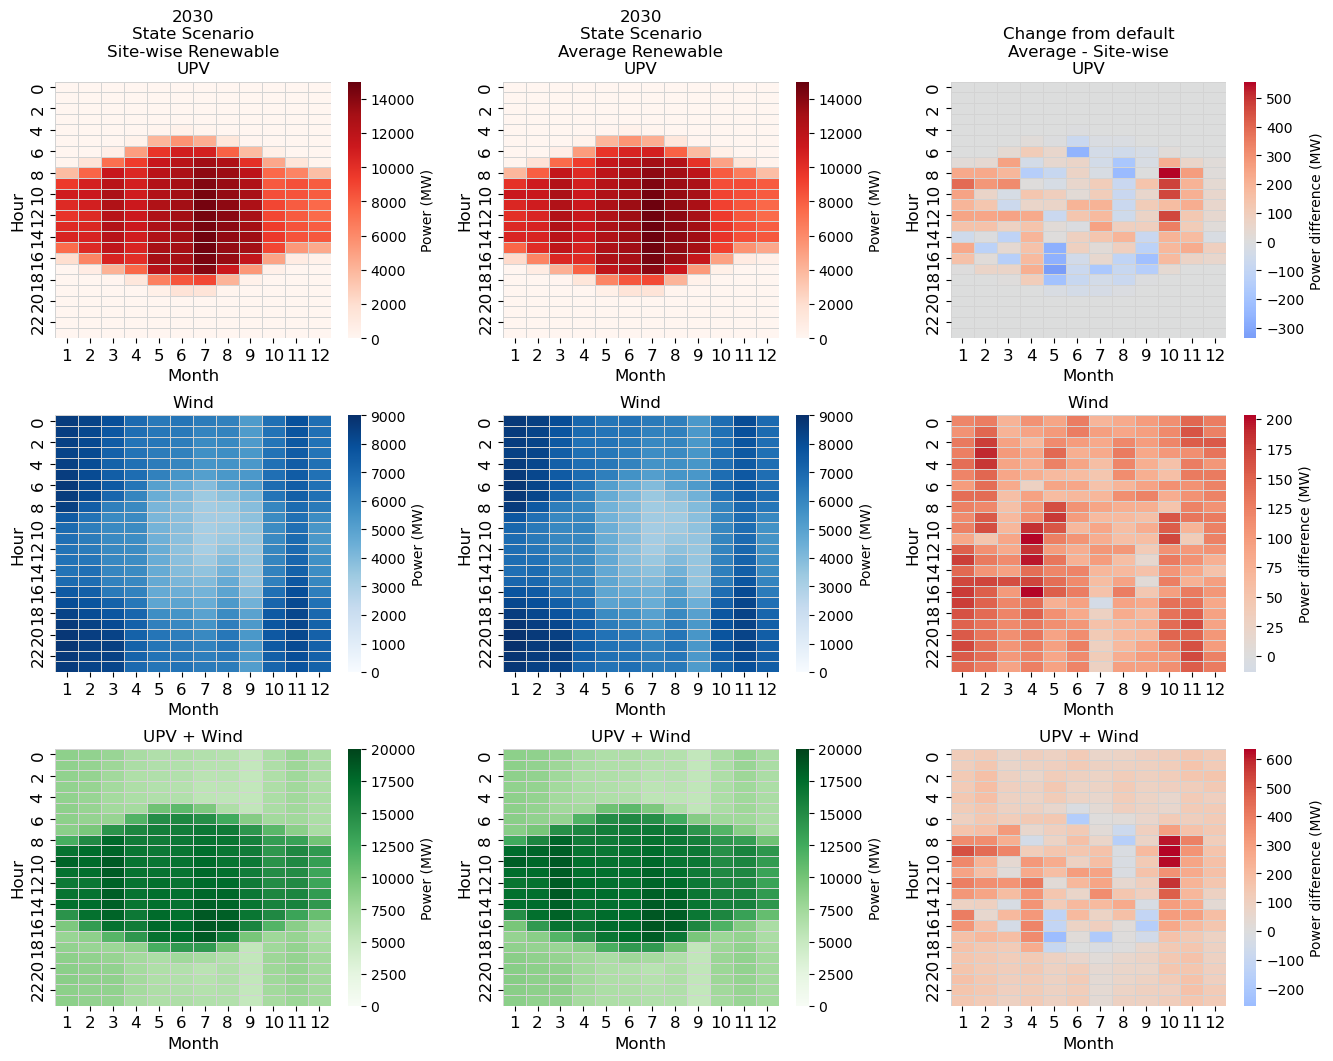

In [153]:
fig, axs = plt.subplots(3, 3, figsize=(16, 12))

#### UPV ####
vmax = 15000
vmin = 0
vmax_diff = 0.05
vmin_diff = -0.05

upv_gen_2030StateScenario = upv_gen_zone_2030StateScenario.sum(axis=1)
upv_gen_by_month_hour_2030StateScenario = upv_gen_2030StateScenario.groupby([
    upv_gen_2030StateScenario.index.month, upv_gen_2030StateScenario.index.hour]).mean()
upv_gen_by_month_hour_2030StateScenario = upv_gen_by_month_hour_2030StateScenario.unstack(level=0)
# Set values smaller than 1 to 0
upv_gen_by_month_hour_2030StateScenario[upv_gen_by_month_hour_2030StateScenario < 1] = 0
sns.heatmap(upv_gen_by_month_hour_2030StateScenario, 
            ax=axs[0, 0],
            vmax=vmax, vmin=vmin,
            cmap='Reds', cbar_kws={'label': 'Power (MW)'},
            # annot=True, fmt=".1f", annot_kws={"size": 10},
            linewidths=0.5, linecolor='lightgray',
            # cbar=False
            )
axs[0, 0].set_title('2030\nState Scenario\nSite-wise Renewable\nUPV')

upv_gen_2030StateScenario_AvgRenew = upv_gen_zone_2030StateScenario_AvgRenew.sum(axis=1)
upv_gen_by_month_hour_2030StateScenario_AvgRenew = upv_gen_2030StateScenario_AvgRenew.groupby([
    upv_gen_2030StateScenario_AvgRenew.index.month, upv_gen_2030StateScenario_AvgRenew.index.hour]).mean()
upv_gen_by_month_hour_2030StateScenario_AvgRenew = upv_gen_by_month_hour_2030StateScenario_AvgRenew.unstack(level=0)
# Set values smaller than 1 to 0
upv_gen_by_month_hour_2030StateScenario_AvgRenew[upv_gen_by_month_hour_2030StateScenario_AvgRenew < 1] = 0
sns.heatmap(upv_gen_by_month_hour_2030StateScenario_AvgRenew, 
            ax=axs[0, 1],
            vmax=vmax, vmin=vmin,
            cmap='Reds', cbar_kws={'label': 'Power (MW)'},
            # annot=True, fmt=".1f", annot_kws={"size": 10},
            linewidths=0.5, linecolor='lightgray',
            # cbar=False
            )
axs[0, 1].set_title('2030\nState Scenario\nAverage Renewable\nUPV')

sns.heatmap(((upv_gen_by_month_hour_2030StateScenario_AvgRenew
             - upv_gen_by_month_hour_2030StateScenario)
            #  / upv_gen_by_month_hour_2030StateScenario * 100
             ), 
            ax=axs[0, 2],
            # vmax=vmax, vmin=vmin,
            cmap='coolwarm', center=0, 
            cbar_kws={'label': 'Power difference (MW)'},
            # cbar_kws={'label': 'Power difference (%)'},
            # annot=True, fmt=".1f", annot_kws={"size": 10},
            linewidths=0.5, linecolor='lightgray',
            # cbar=False
            )
axs[0, 2].set_title('Change from default\nAverage - Site-wise\nUPV')

#### Wind ####
vmax = 9000
vmin = 0
vmax_diff = 0.05
vmin_diff = -0.05

wind_gen_2030StateScenario = wind_gen_zone_2030StateScenario.sum(axis=1)
wind_gen_by_month_hour_2030StateScenario = wind_gen_2030StateScenario.groupby([
    wind_gen_2030StateScenario.index.month, wind_gen_2030StateScenario.index.hour]).mean()
wind_gen_by_month_hour_2030StateScenario = wind_gen_by_month_hour_2030StateScenario.unstack(level=0)
# Set values smaller than 1 to 0
wind_gen_by_month_hour_2030StateScenario[wind_gen_by_month_hour_2030StateScenario < 1] = 0
sns.heatmap(wind_gen_by_month_hour_2030StateScenario, 
            ax=axs[1, 0],
            vmax=vmax, vmin=vmin,
            cmap='Blues', cbar_kws={'label': 'Power (MW)'},
            # annot=True, fmt=".1f", annot_kws={"size": 10},
            linewidths=0.5, linecolor='lightgray',
            # cbar=False
            )
axs[1, 0].set_title('Wind')

wind_gen_2030StateScenario_AvgRenew = wind_gen_zone_2030StateScenario_AvgRenew.sum(axis=1)
wind_gen_by_month_hour_2030StateScenario_AvgRenew = wind_gen_2030StateScenario_AvgRenew.groupby([
    wind_gen_2030StateScenario_AvgRenew.index.month, wind_gen_2030StateScenario_AvgRenew.index.hour]).mean()
wind_gen_by_month_hour_2030StateScenario_AvgRenew = wind_gen_by_month_hour_2030StateScenario_AvgRenew.unstack(level=0)
# Set values smaller than 1 to 0
wind_gen_by_month_hour_2030StateScenario_AvgRenew[wind_gen_by_month_hour_2030StateScenario_AvgRenew < 1] = 0
sns.heatmap(wind_gen_by_month_hour_2030StateScenario_AvgRenew, 
            ax=axs[1, 1],
            vmax=vmax, vmin=vmin,
            cmap='Blues', cbar_kws={'label': 'Power (MW)'},
            # annot=True, fmt=".1f", annot_kws={"size": 10},
            linewidths=0.5, linecolor='lightgray',
            # cbar=False
            )
axs[1, 1].set_title('Wind')

sns.heatmap(((wind_gen_by_month_hour_2030StateScenario_AvgRenew
             - wind_gen_by_month_hour_2030StateScenario)
            #  / wind_gen_by_month_hour_2030StateScenario* 100
             ), 
            ax=axs[1, 2],
            # vmax=vmax, vmin=vmin,
            cmap='coolwarm', center=0, 
            cbar_kws={'label': 'Power difference (MW)'},
            # cbar_kws={'label': 'Power difference (%)'},
            # annot=True, fmt=".1f", annot_kws={"size": 10},
            linewidths=0.5, linecolor='lightgray',
            # cbar=False
            )
axs[1, 2].set_title('Wind')

#### UPV + Wind ####
vmax = 20000
vmin = 0
vmax_diff = 0.05
vmin_diff = -0.05

renew_gen_2030StateScenario = (upv_gen_zone_2030StateScenario.sum(axis=1)
                               + wind_gen_zone_2030StateScenario.sum(axis=1))
renew_gen_by_month_hour_2030StateScenario = renew_gen_2030StateScenario.groupby([
    renew_gen_2030StateScenario.index.month, renew_gen_2030StateScenario.index.hour]).mean()
renew_gen_by_month_hour_2030StateScenario = renew_gen_by_month_hour_2030StateScenario.unstack(level=0)
# Set values smaller than 1 to 0
renew_gen_by_month_hour_2030StateScenario[renew_gen_by_month_hour_2030StateScenario < 1] = 0
sns.heatmap(renew_gen_by_month_hour_2030StateScenario, 
            ax=axs[2, 0],
            vmax=vmax, vmin=vmin,
            cmap='Greens', cbar_kws={'label': 'Power (MW)'},
            # annot=True, fmt=".1f", annot_kws={"size": 10},
            linewidths=0.5, linecolor='lightgray',
            # cbar=False
            )
axs[2, 0].set_title('UPV + Wind')

renew_gen_2030StateScenario_AvgRenew = (upv_gen_zone_2030StateScenario_AvgRenew.sum(axis=1)
                                        + wind_gen_zone_2030StateScenario_AvgRenew.sum(axis=1))
renew_gen_by_month_hour_2030StateScenario_AvgRenew = renew_gen_2030StateScenario_AvgRenew.groupby([
    renew_gen_2030StateScenario_AvgRenew.index.month, renew_gen_2030StateScenario_AvgRenew.index.hour]).mean()
renew_gen_by_month_hour_2030StateScenario_AvgRenew = renew_gen_by_month_hour_2030StateScenario_AvgRenew.unstack(level=0)
# Set values smaller than 1 to 0
renew_gen_by_month_hour_2030StateScenario_AvgRenew[renew_gen_by_month_hour_2030StateScenario_AvgRenew < 1] = 0
sns.heatmap(renew_gen_by_month_hour_2030StateScenario_AvgRenew, 
            ax=axs[2, 1],
            vmax=vmax, vmin=vmin,
            cmap='Greens', cbar_kws={'label': 'Power (MW)'},
            # annot=True, fmt=".1f", annot_kws={"size": 10},
            linewidths=0.5, linecolor='lightgray',
            # cbar=False
            )
axs[2, 1].set_title('UPV + Wind')

sns.heatmap(((renew_gen_by_month_hour_2030StateScenario_AvgRenew
             - renew_gen_by_month_hour_2030StateScenario)
            #  / renew_gen_by_month_hour_2030StateScenario * 100
             ), 
            ax=axs[2, 2],
            # vmax=vmax, vmin=vmin,
            cmap='coolwarm', center=0, 
            cbar_kws={'label': 'Power difference (MW)'},
            # cbar_kws={'label': 'Power difference (%)'},
            # annot=True, fmt=".1f", annot_kws={"size": 10},
            linewidths=0.5, linecolor='lightgray',
            # cbar=False
            )
axs[2, 2].set_title('UPV + Wind')


####
for ax in axs.flat:
    ax.set_xlabel('Month', fontsize=12)
    ax.set_ylabel('Hour', fontsize=12)
    ax.tick_params(axis='both', labelsize=12)

fig.subplots_adjust(hspace=0.3, wspace=0.3)
fig.savefig(os.path.join(fig_dir,
                            'compare_renew_gen_by_month_hour.png'),
                bbox_inches='tight')

plt.show()